In [1]:
import os
import sys
import glob
import zlib
import math
import copy
import pickle
import pymzml
import importlib.util
import numpy as np
import scipy as sp
import pandas as pd
import seaborn as sns
import _pickle as cpickle
import matplotlib.pyplot as plt
from bokeh.plotting import figure, show
from bokeh.io import output_notebook
from importlib import reload
from scipy.signal import find_peaks
from collections import defaultdict as ddict
from scipy.ndimage.filters import gaussian_filter
from tensorly.decomposition import non_negative_parafac as nnp

from bokeh.plotting import figure
from bokeh.palettes import Spectral6
from bokeh.transform import linear_cmap
from bokeh.layouts import gridplot, column
from bokeh.models import HoverTool, ColorBar, Text, Div, Whisker
from bokeh.models.glyphs import MultiLine, Line
from bokeh.io import save, output_file
from bokeh.models.callbacks import CustomJS
from bokeh.models.sources import ColumnDataSource, CDSView
from bokeh.models.filters import Filter, GroupFilter, IndexFilter

#Tensor label-generation constants
hd_mass_diff = 1.006277
c13_mass_diff = 1.00335

#config params
low_mass_margin = 10
high_mass_margin = 17
ppm_radius = 30

sys.path.append(os.getcwd()+"/workflow/scripts/auxiliary/")
import molmass
import hxtools
import LC_IM_MS_TensorAnalysis as hx

n_undeut_runs = 3

library_info = pd.read_csv("resources/library_info/library_info.csv")
library_info['Drift Time MS1'] = library_info['im_mono'] / 200.0 * 13.781163434903 

old_data_dir = "/projects/p30802/digs_old/HX/180604_mix2_MES/hx_fits/"
names_and_seqs = pd.read_csv("resources/library_info/new_HX_order.csv")

timepoints = [0, 10, 16, 26, 40, 65, 105, 160, 270, 430, 690, 1050, 1680, 2640, 4200, 6600, 11400, 18900, 33600, 62220, 100800]
tp_names = ["UN", "10s", "16s", "26s", "40s", "65s", "105s", "160s", "4m30", "7m10", "11m30s", "17m30s", "28m", "44m", "70m", "1hr50", "3hr10", "5hr15", "9hr20", "17hr45", "28hr"]

output_notebook()

Loading BokehJS ...

In [ ]:
names = sorted(list(set(library_info.sort_values('name')['name'].values)))
lines = dict.fromkeys(names)

for name in names:
    lines[name] = list(library_info.loc[library_info['name'] == name]['idx'].values)

In [3]:
#Generate rt-group ics
#for name in names[0:2]:

In [4]:
name = names[0]

In [5]:
paths = []
for i in lines[name]:
    [paths.append(fn) for fn in glob.glob("resources/tensors/"+str(i)+"_*")]

tp_inputs = [[fn for fn in paths if tp_name in fn] for tp_name in tp_names]

name = library_info.loc[library_info['idx'] == i]['name'].values[0]

t = hx.TensorGenerator(name, library_info, tp_inputs, timepoints, keep_tensors = True)
t.generate_tensors()

Starting 0 seconds, 1 of 21
Sourcefile: resources/tensors/0_180604_Mix2_MES_nonlin_UN.mzML.gz.cpickle.zlib, 1 of 3
File: resources/tensors/0_180604_Mix2_MES_nonlin_UN.mzML.gz.cpickle.zlib
Beginning Factorization...


/projects/b1107/wes/HDX_LIMIT-Pipeline/workflow/scripts/auxiliary/LC_IM_MS_TensorAnalysis.py:149: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  self.seq_out = np.array(kwargs['seq_out'])


Done: T+10.847429275512695
Sourcefile: resources/tensors/0_180604_Mix2_MES_nonlin_UN3.mzML.gz.cpickle.zlib, 2 of 3
File: resources/tensors/0_180604_Mix2_MES_nonlin_UN3.mzML.gz.cpickle.zlib
Beginning Factorization...
Done: T+10.882846117019653
Sourcefile: resources/tensors/0_180604_Mix2_MES_nonlin_UN2.mzML.gz.cpickle.zlib, 3 of 3
File: resources/tensors/0_180604_Mix2_MES_nonlin_UN2.mzML.gz.cpickle.zlib
Beginning Factorization...
Done: T+10.690881490707397
Starting 10 seconds, 2 of 21
Sourcefile: resources/tensors/0_180604_Mix2_MES_nonlin_10s.mzML.gz.cpickle.zlib, 1 of 1
File: resources/tensors/0_180604_Mix2_MES_nonlin_10s.mzML.gz.cpickle.zlib
Beginning Factorization...
Done: T+11.218761205673218
Starting 16 seconds, 3 of 21
Sourcefile: resources/tensors/0_180604_Mix2_MES_nonlin_16s.mzML.gz.cpickle.zlib, 1 of 1
File: resources/tensors/0_180604_Mix2_MES_nonlin_16s.mzML.gz.cpickle.zlib
Beginning Factorization...
Done: T+11.310205459594727
Starting 26 seconds, 4 of 21
Sourcefile: resources/

In [6]:
fatc = []
for tp in t.all_tp_clusters:
    fatc.append([ic for ic in tp if ic.baseline_peak_error/ic.baseline_auc < 0.1])

hx.limit_write(fatc, "resources/ic_time_series/"+t.name+"_all_tp_clusters.cpickle.zlib")

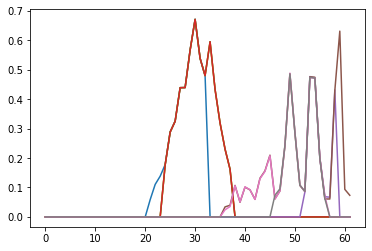

In [7]:
for ic in fatc[1]:
    plt.plot(ic.baseline_integrated_mz)

In [8]:
#peak bounding by n% max
def rel_height_peak_bounds(centers, int_mz, bound=5):
    out = []
    baseline = max(int_mz)*0.15 #TODO HARDCODE
    for center in centers:
        if int_mz[center] > baseline:
            i, j = center, center
            cutoff = int_mz[center]*(bound/100)
            while (center-i <= 10 and i-1 != -1):
                i -= 1
                if int_mz[i] < cutoff:
                    break
            while (j-center <= 10 and j+1 != len(int_mz)): 
                j += 1
                if int_mz[j] < cutoff:
                    break 
            out.append((i,j))
    return out

In [19]:
out = sp.signal.find_peaks(t.tensor_archive[1][0].factors[1].integrated_mz_data, prominence = 0.01, width = 0.5)
peaks = out[0]

In [20]:
peaks

array([ 2,  5,  7, 10, 12, 15, 18, 20, 24, 28, 30, 32, 35, 38, 40, 45, 49,
       53, 59])

In [21]:
test = rel_height_peak_bounds(peaks, t.tensor_archive[1][0].factors[1].integrated_mz_data)

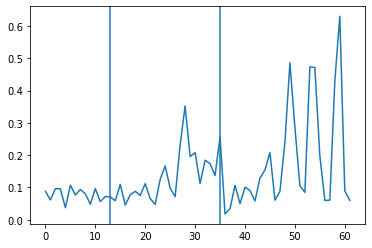

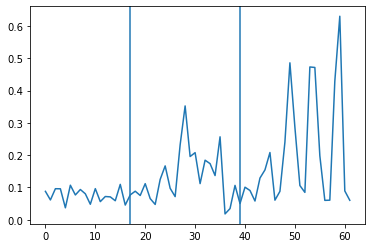

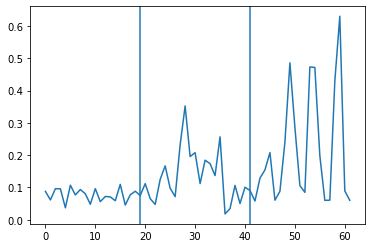

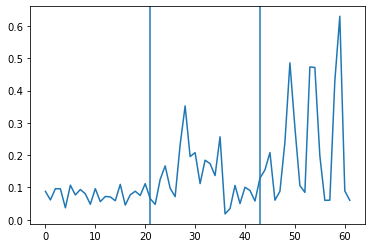

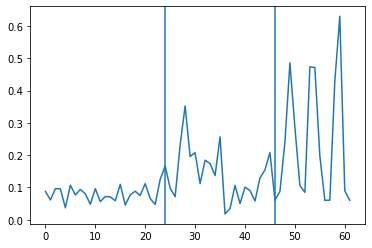

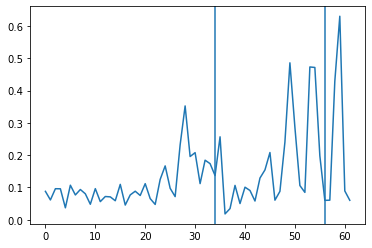

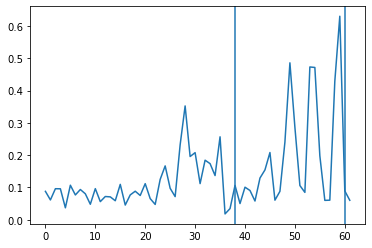

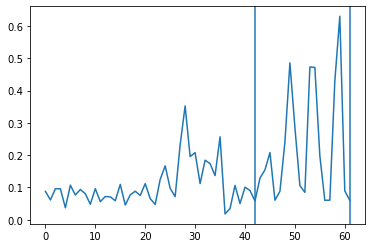

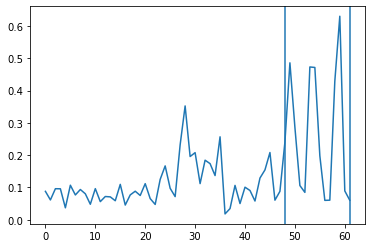

In [22]:
for tup in test:
    i, j = tup
    plt.plot(t.tensor_archive[1][0].factors[1].integrated_mz_data)
    plt.axvline(i)
    plt.axvline(j)
    plt.show()
    plt.close()

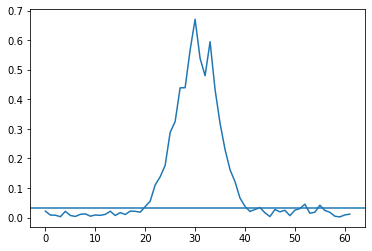

In [23]:
plt.plot(t.tensor_archive[1][0].factors[0].integrated_mz_data)
plt.axhline(0.0335)

In [9]:
proc = glob.glob("./resources/ic_time_series/*all_tp_clusters*")

In [10]:
i = 0

In [11]:
name = "_".join(proc[i].split('/')[-1].split('_')[:-3])
atc = hx.limit_read(proc[i])

In [12]:
#filter by bpe
fatc = []
for tp in atc:
    fatc.append([ic for ic in tp if ic.baseline_peak_error/ic.baseline_auc < 0.2])

17


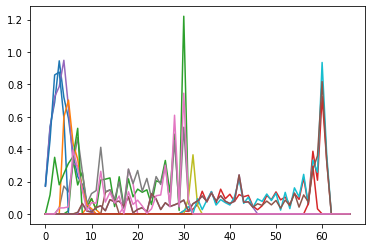

7


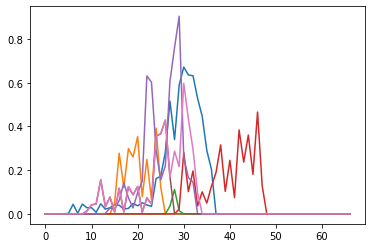

7


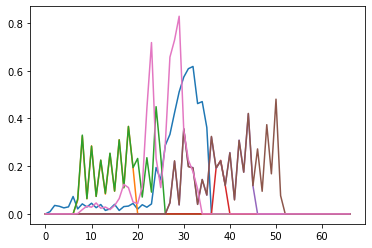

8


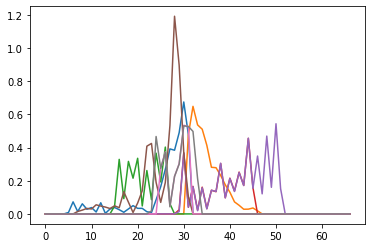

5


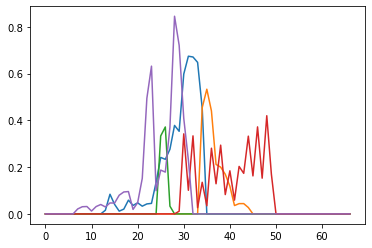

3


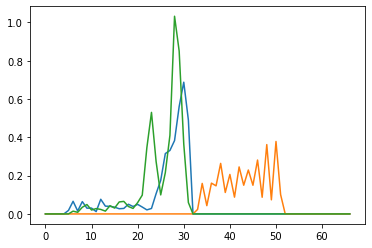

7


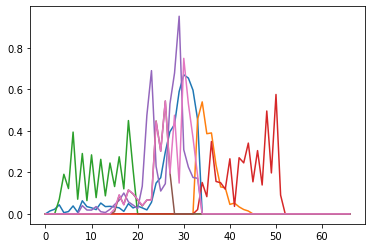

8


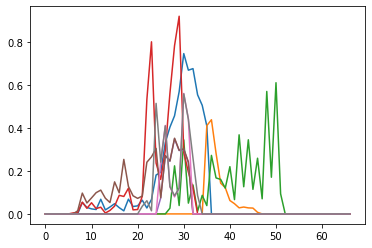

4


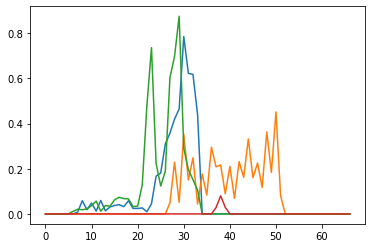

8


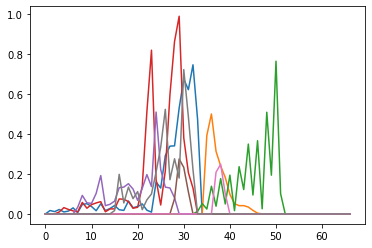

7


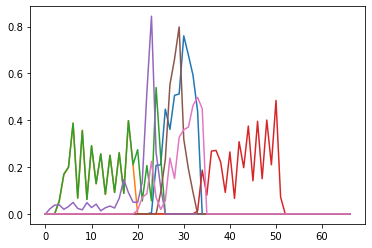

9


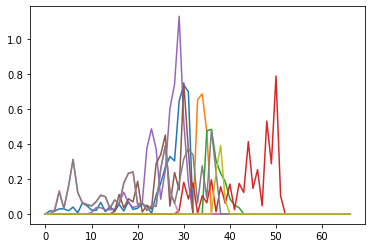

4


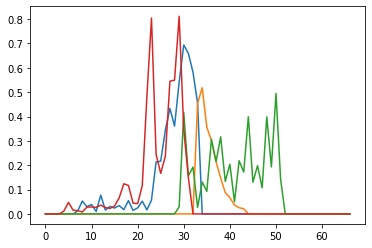

4


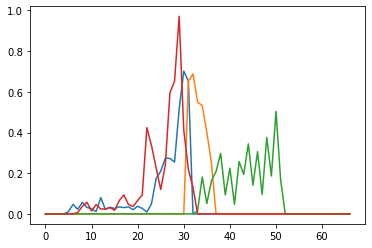

5


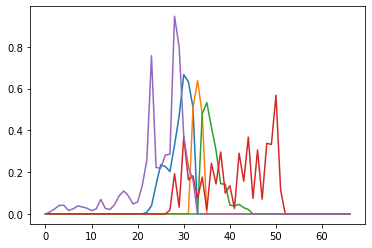

4


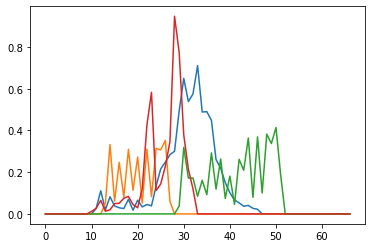

13


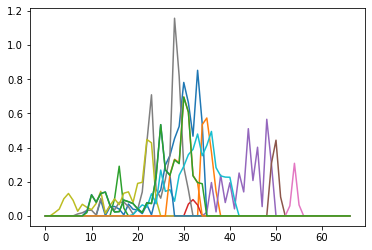

10


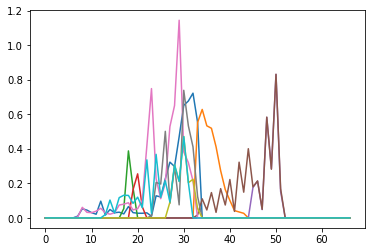

4


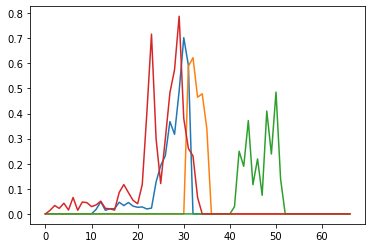

6


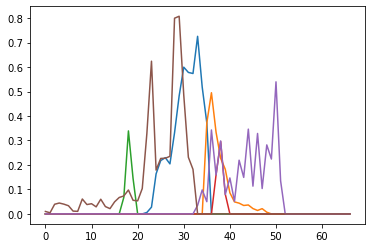

8


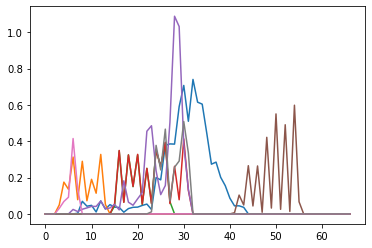

In [13]:
#see filter-passing int mzs
for tp in fatc:
    print(len(tp))
    plt.figure()
    for ic in tp:
        plt.plot(ic.baseline_integrated_mz)
    plt.show()
    plt.close()

In [14]:
po = hx.PathOptimizer(name, fatc, library_info, timepoints, n_undeut_runs = 3, old_data_dir = "resources/old_data/")

/home/rwl0960/.conda/envs/dask_lab/lib/python3.7/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


In [15]:
po.optimize_paths()

In [16]:
po.bokeh_plot("results/plots/ic_time_series/html/"+name+"_time_series.html")

old_data timepoints: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22]
old_data timepoints: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22]
old_data timepoints: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22]


In [19]:
def manual_cmap(value, low, high, palette):
    interval = (high-low)/len(palette)
    n_colors = len(palette)
    if value <= interval:
        return palette[0]
    else:
        if value > (n_colors-1)*interval:
            return palette[n_colors-1]
        else:
            for i in range(1, n_colors-2):
                if value > interval*i and value <= interval*i+1:
                    return palette[i]

In [20]:
def winner_added_mass_plotter(source, tooltips, old_source = None):
    p = figure(title = 'Winning Timeseries Mean Added-Mass, Colored by RTxDT Error in ms', plot_height = 400, plot_width = 1275, background_fill_color = 'whitesmoke', x_range = (-1, max([int(tp) for tp in source.data['timepoint']])+1), tools = 'pan,wheel_zoom,reset,help', tooltips = tooltips)
    winner_view = CDSView(source = source, filters = [GroupFilter(column_name = "winner_or_runner", group = str(0))])
    err_mapper = linear_cmap(field_name = 'rtxdt_err', palette = Spectral6, low = 0, high = 1)
    color_bar = ColorBar(color_mapper = err_mapper['transform'], width = 10,  location = (0,0))

    #Get mean value from source and map value to Spectral6
    mean_rtxdt_err = source.data['rtxdt_err'][0]
    mean_color = manual_cmap(mean_rtxdt_err, 0, 2, Spectral6)
    p.multi_line(xs = 'whisker_x', ys = 'whisker_y', source = source, view = winner_view, line_color = 'black', line_width = 1.5)
    #p.line(x = 'timepoint', y = 'baseline_integrated_mz_com', line_color = mean_color, source = source, view = winner_view, line_width = 3)
    p.circle(x = 'timepoint', y = 'baseline_integrated_mz_com', source = source, view = winner_view, line_color = err_mapper, color = err_mapper, fill_alpha = 1, size = 12)
    #p.add_layout(Whisker(source = source, base = "timepoint", view = winner_view, upper = "upper_added_mass", lower = "lower_added_mass"))

    if old_source is not None: #plot added-masses of all charges of protein
        old_hover = HoverTool(tooltips = [
            ("Charge", "@charge"),
            ("Delta MZ Rate Score", "@delta_mz_rate"),
            ("Fit of Undeuterated Added-Mass Distribution to Theoretical Distribution", "@fit_to_theo_dist")
            ],
            names = ['old'])

        old_ics = Line(x = 'timepoint', y = 'added_mass_centroid', line_color = 'wheat', line_width = 1.5)
        old_tp_view = CDSView(source = old_source, filters = [GroupFilter(column_name = 'type', group = 'ic')])
        old_renderer = p.add_glyph(old_source, old_ics, view = old_tp_view, name = 'old')
        #p.add_layout(Whisker(source = old_source, base = "added_mass_xs", upper = "uppers", lower = "lowers")) #TODO Change alt color
        p.add_tools(old_hover)

    p.xaxis.axis_label = "Timepoint Index"
    p.yaxis.axis_label = "Mean Added-Mass Units"
    p.min_border_top = 100
    p.min_border_left = 100
    p.min_border_right = 100
    p.add_layout(color_bar, 'right')
    return p  

In [21]:
def winner_added_mass_plotter(source, tooltips, old_source = None):
    p = figure(title = 'Winning Timeseries Mean Added-Mass, Colored by RTxDT Error in ms', plot_height = 400, plot_width = 1275, background_fill_color = 'whitesmoke', x_range = (-1, max([int(tp) for tp in source.data['timepoint']])+1), tools = 'pan,wheel_zoom,reset,help', tooltips = tooltips)
    err_mapper = linear_cmap(field_name = 'rtxdt_err', palette = Spectral6, low = 0, high = 1)
    color_bar = ColorBar(color_mapper = err_mapper['transform'], width = 10,  location = (0,0))

    #Get mean value from source and map value to Spectral6
    mean_rtxdt_err = source.data['rtxdt_err'][0]
    mean_color = manual_cmap(mean_rtxdt_err, 0, 2, Spectral6)
    p.multi_line(xs = 'whisker_x', ys = 'whisker_y', source = source, line_color = 'black', line_width = 1.5)
    p.line(x = 'timepoint', y = 'baseline_integrated_mz_com', line_color = mean_color, source = source, line_width = 3)
    p.circle(x = 'timepoint', y = 'baseline_integrated_mz_com', source = source, line_color = err_mapper, color = err_mapper, fill_alpha = 1, size = 12)

    if old_source is not None: #plot added-masses of all charges of protein
        old_hover = HoverTool(tooltips = [
            ("Charge", "@charge"),
            ("Delta MZ Rate Score", "@delta_mz_rate"),
            ("Fit of Undeuterated Added-Mass Distribution to Theoretical Distribution", "@fit_to_theo_dist")
            ],
            names = ['old'])

        old_ics = Line(x = 'timepoint', y = 'added_mass_centroid', line_color = 'wheat', line_width = 1.5)
        old_renderer = p.add_glyph(old_source, old_ics, name = 'old')
        p.add_tools(old_hover)
        
    p.xaxis.axis_label = "Timepoint Index"
    p.yaxis.axis_label = "Mean Added-Mass Units"
    p.min_border_top = 100
    p.min_border_left = 100
    p.min_border_right = 100
    p.add_layout(color_bar, 'right')
    
    return p    

In [22]:
show(winner_added_mass_plotter(wds, mass_added_tts, old_source = gds))

NameError: name 'wds' is not defined

In [18]:
def contiguous_check(tidxs):
    
    check = []
    
    for i in range(len(tidxs)):
        
        if i == 0:
            if tidxs[i+1] == tidxs[i]+1:
                check.append(True)
            else:
                check.append(False)
        
        else:
            
            if i == len(tidxs)-1:
                if tidxs[i-1] == tidxs[i]-1:
                    check.append(True)
                else:
                    check.append(False)
            
            else:
                if tidxs[i-1] == tidxs[i]-1 or tidxs[i+1] == tidxs[i]+1:
                    check.append(True)
                else:
                    check.append(False)
   
    contig_tidxs = [tidxs[i] for i in range(len(check)) if check[i] == True]
    
    t0, t1 = contig_tidxs[0], contig_tidxs[-1]
    
    return t0, t1

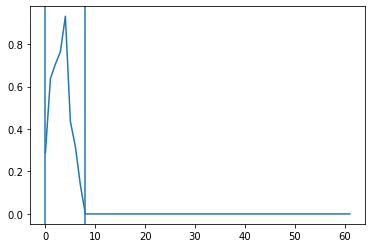

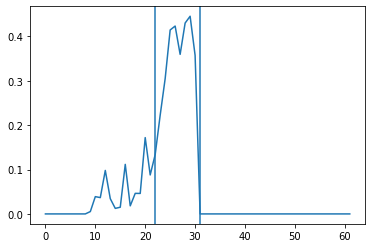

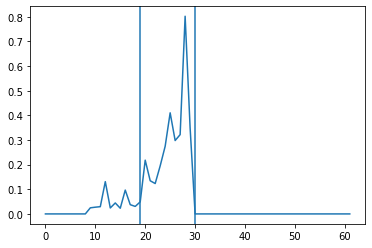

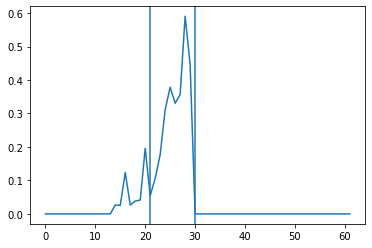

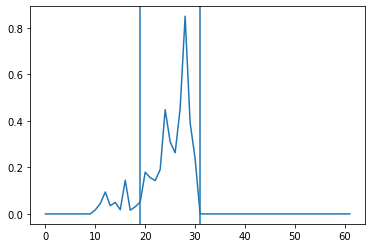

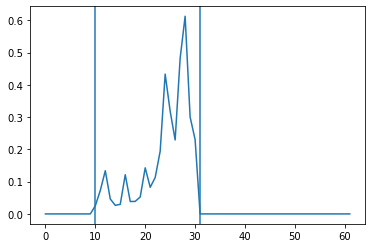

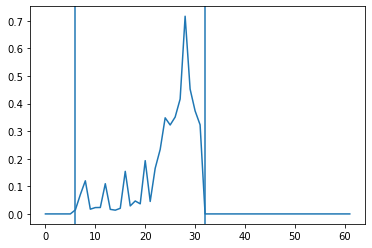

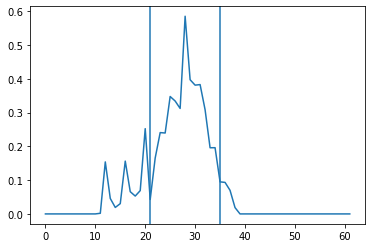

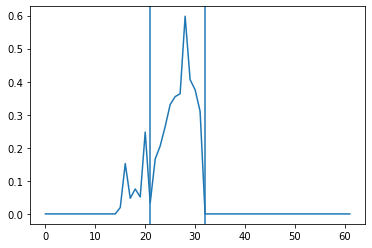

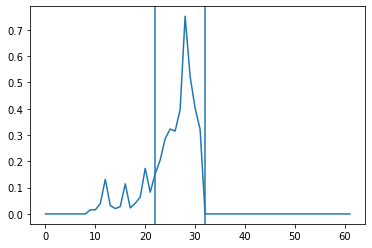

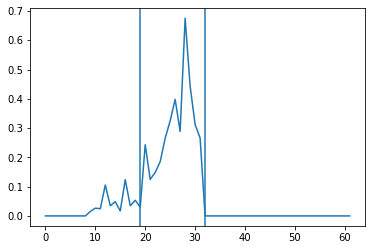

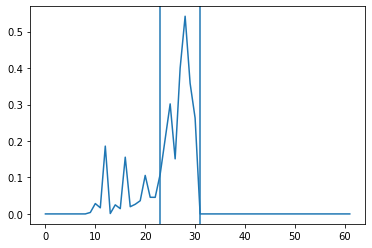

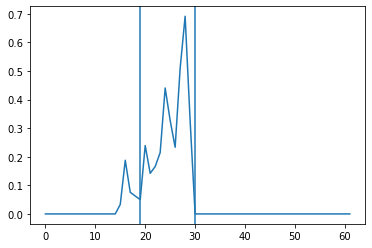

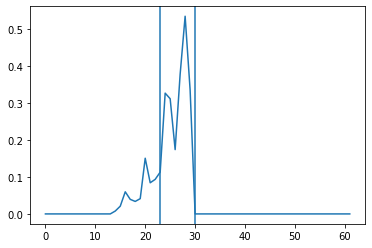

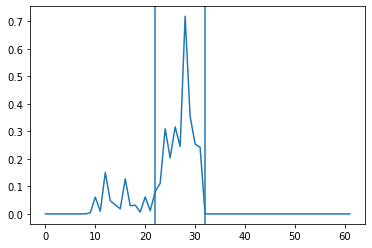

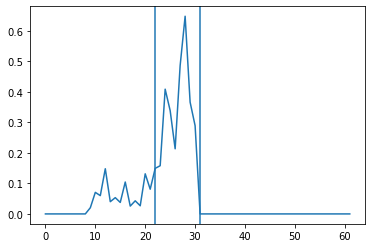

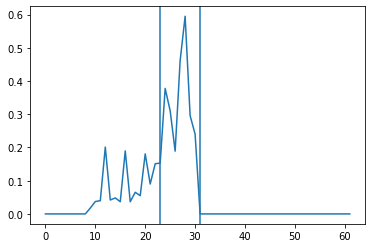

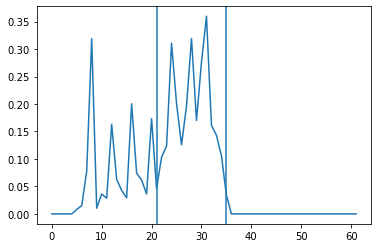

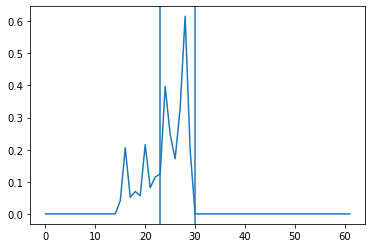

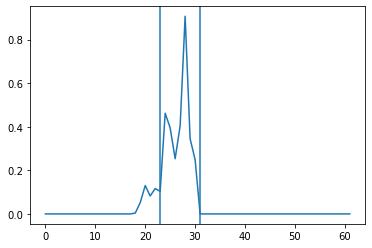

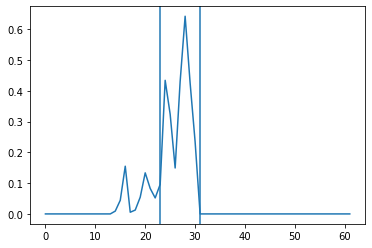

In [27]:
for i in range(len(po.winner)):
    int_mz_mask = abs(np.gradient(po.winner[i].baseline_integrated_mz)) > 0.035
    tidxs = [i for i in range(len(int_mz_mask)) if (int_mz_mask[i] == True)]
    t0, t1 = contiguous_check(tidxs)
    plt.figure()
    plt.plot(po.winner[i].baseline_integrated_mz)
    plt.axvline(t0)
    plt.axvline(t1)
    plt.show()
    plt.close()

In [27]:
def winner_rtdt_plotter(source, tooltips):
    #set top margin
    p = figure(title = "Winning Timeseries RT and DT Center-of-Mass Error to Undeuterated Isotopic Cluster", plot_height = 300, plot_width = 1275, x_range = (-3.5, 70), y_range = (-0.1, 2), background_fill_color = 'whitesmoke', tools = 'pan,wheel_zoom,box_zoom,hover,reset,help', tooltips = tooltips)
    winner_view = CDSView(source = source, filters = [GroupFilter(column_name = "winner_or_runner", group = str(0))])
    p.x(x = 'rt_ground_err', y = 'dt_ground_err', source = source, view = winner_view, fill_alpha = 1, size = 5, color = "black")
    p.xaxis.axis_label = "RT Error (ms)"
    p.yaxis.axis_label = "DT Error (ms)"
    p.min_border_left = 100
    p.min_border_right = 100

    glyph = Text(x = "rt_ground_err", y = "dt_ground_err", text = "timepoint")
    p.add_glyph(source, glyph)
    return p

In [28]:
def winner_rtdt_plotter(source, tooltips):
    #set top margin
    p = figure(title = "Winning Timeseries RT and DT Center-of-Mass Error to Undeuterated Isotopic Cluster", plot_height = 300, plot_width = 1275, x_range = (-3.5, 70), y_range = (-0.1, 2), background_fill_color = 'whitesmoke', tools = 'pan,wheel_zoom,box_zoom,hover,reset,help', tooltips = tooltips)
    p.x(x = 'rt_ground_err', y = 'dt_ground_err', source = source, fill_alpha = 1, size = 5, color = "black")
    p.xaxis.axis_label = "RT Error (ms)"
    p.yaxis.axis_label = "DT Error (ms)"
    p.min_border_left = 100
    p.min_border_right = 100
    glyph = Text(x = "rt_ground_err", y = "dt_ground_err", text = "timepoint")
    p.add_glyph(source, glyph)
    return p

In [29]:
show(winner_rtdt_plotter(wds, winner_rtdt_tts))

NameError: name 'wds' is not defined

In [30]:
def winner_plotter(source, i, tooltips, old_source = None):
    if i == max([int(tp) for tp in source.data['timepoint']]):
        p = figure(title = "Timepoint "+str(i)+": Winning Isotopic-Cluster Added-Mass Distribution", plot_height = 400, plot_width = 450, y_range = (0, 1), background_fill_color = 'whitesmoke', tools = 'pan,wheel_zoom,hover,reset,help')
        p.min_border_bottom = 100
    else:
        p = figure(title = "Timepoint "+str(i)+": Winning Isotopic Cluster Added-Mass Distribution", plot_height = 300, plot_width = 450, y_range = (0, 1), background_fill_color = 'whitesmoke', tools = 'pan,wheel_zoom,hover,reset,help')
    p.title.text_font_size = "8pt"

    #Have a figure by here, use glyph plotting from here
    new_hover = HoverTool(tooltips = tooltips, names = ['new'])
    index_view = CDSView(source = source, filters = [IndexFilter(indices = [i])])
    new_ics = MultiLine(xs = 'int_mz_x', ys = 'int_mz_rescale', line_color = "blue", line_width = 1.5)
    new_ics_hover = MultiLine(xs = 'int_mz_x', ys = 'int_mz_rescale', line_color = "red", line_width = 1.5)
    new_renderer = p.add_glyph(source, new_ics, view = index_view, name = 'new', hover_glyph=new_ics_hover)
    p.add_tools(new_hover)

    if old_source is not None: #plot ics matching the timepoint from old data
        old_hover = HoverTool(tooltips = [("Charge", '@charge'), ("Added-Mass Distribution Centroid", "@"),("Width", '@width')], names = ['old'])
        old_ics = MultiLine(xs = 'int_mz_xs', ys = 'int_mz_rescale', line_color = 'wheat', line_width = 1.5)
        old_ics_hover = MultiLine(xs = 'int_mz_xs', ys = 'int_mz_rescale', line_color = 'red', line_width = 1.5)
        old_tp_view = CDSView(source = old_source, filters = [GroupFilter(column_name = 'type', group = 'ic'), GroupFilter(column_name = 'timepoint', group = str(i))])
        old_renderer = p.add_glyph(old_source, old_ics, view = old_tp_view, hover_glyph = old_ics_hover, name = 'old')
        p.add_tools(old_hover)

    p.xaxis.axis_label = "Added-Mass Units"
    p.yaxis.axis_label = "Relative Intensity"
    p.min_border_left = 100
    return p

In [31]:
def runner_plotter(source, i, tooltips):
    if i == max([int(tp) for tp in source.data['timepoint']]):
        p = figure(title = "Runner-Up Isotopic Cluster Added-Mass Distributions", plot_height = 400, plot_width = 375, y_range = (0, 1), background_fill_color = 'whitesmoke', tools = 'pan,wheel_zoom,hover,reset,help', tooltips = tooltips)
        p.min_border_bottom = 100
    else:
        p = figure(title = "Runner-Up Isotopic Cluster Added-Mass Distributions", plot_height = 300, plot_width = 375, y_range = (0, 1), background_fill_color = 'whitesmoke', tools = 'pan,wheel_zoom,hover,reset,help', tooltips = tooltips)
    p.title.text_font_size = "8pt"
    runner_timepoint_view = CDSView(source = source, filters = [GroupFilter(column_name = "timepoint", group = str(i)), GroupFilter(column_name = "winner_or_runner", group = str(1))])
    p.multi_line(xs = 'int_mz_x', ys = 'int_mz_rescale', source = source, view = runner_timepoint_view, line_color = "blue", alpha = 0.5, hover_color = 'red', hover_alpha = 1, line_width = 1.5)
    p.xaxis.axis_label = "Added-Mass Units"
    p.yaxis.axis_label = "Relative Intensity"
    return p

In [32]:
def rtdt_plotter(source, i, tooltips):
    if i == max([int(tp) for tp in source.data['timepoint']]):
        p = figure(title = "RT and DT Error from Undeuterated", plot_height = 400, plot_width = 450, background_fill_color = 'whitesmoke', x_range = (-3.5, 70), y_range = (-0.1,2), tools = 'pan,wheel_zoom,hover,reset,help', tooltips = tooltips)
        p.min_border_bottom = 100
    else:
        p = figure(title = "Retention and Drift Center-of-Mass Error to Undeuterated", plot_height = 300, plot_width = 450, background_fill_color = 'whitesmoke', x_range = (-3.5, 70), y_range = (-0.1,2), tools = 'pan,wheel_zoom,hover,reset,help', tooltips = tooltips)
    p.title.text_font_size = "8pt"
    timepoint_runner_view = CDSView(source=source, filters = [GroupFilter(column_name = "timepoint", group = str(i)), GroupFilter(column_name = 'winner_or_runner', group = str(1))])
    p.circle(x = "rt_ground_err", y = 'dt_ground_err', source = source, view = timepoint_runner_view, line_color = 'blue', hover_color = 'red', alpha = 0.25, hover_alpha = 1, size = 5)
    timepoint_winner_view = CDSView(source = source, filters = [GroupFilter(column_name = "timepoint", group = str(i)), GroupFilter(column_name = 'winner_or_runner', group = str(0))])
    p.circle(x = "rt_ground_err", y = 'dt_ground_err', source = source, view = timepoint_winner_view, line_color = 'black', fill_color = "black", hover_color = 'red', size = 5)
    p.xaxis.axis_label = "RT COM Error from Ground (ms)"
    p.yaxis.axis_label = "DT COM Error from Ground (ms)"
    p.min_border_right = 100 
    return p

In [33]:
#Start old_data source creation
if po.old_data_dir is not None:

    #create bokeh datasource from gabe's hx_fits

    #divide source by data-types: single-tp ic-level data and charge-state time-series level data
    #old_charges will be used for plotting added-mass and time-series stats

    #init dicts with columns for plotting
    old_ics = dict.fromkeys(['timepoint', 'added_mass_centroid', 'added_mass_width', 'int_mz_ys', 'int_mz_xs', 'type', "int_mz_rescale"])
    for key in old_ics.keys():
        old_ics[key] = []

    old_charges = dict.fromkeys(['major_species_integrated_intensities', 'centroid', 'major_species_widths', 'fit_to_theo_dist', 'delta_mz_rate', 'added_mass_xs', 'lowers', 'uppers', 'type', 'charge'])
    for key in old_charges.keys():
        old_charges[key] = []

    #set switch to pull values that only need to be computed once, append each old_file's values to old_data{}
    old_switch = None
    for ts in po.old_data:


        int_mz_xs = list(range(len(ts['major_species_integrated_intensities'][0])))
        timepoints = list(range(len(ts['major_species_centroid'])))
        print("old_data timepoints: "+str(timepoints))


        #Add line to old_charges for each charge file
        for key in ['major_species_integrated_intensities', 'centroid', 'fit_to_theo_dist', 'delta_mz_rate', 'charge']:
            old_charges[key].append(ts[key])

        old_charges['added_mass_xs'].append(timepoints)
        old_charges['major_species_widths'].append([len(np.nonzero(ic)[0]) for ic in ts['major_species_integrated_intensities']])
        old_charges['lowers'].append([ts['major_species_centroid'][tp]-(ts['major_species_widths'][tp]/2) for tp in timepoints])
        old_charges['uppers'].append([ts['major_species_centroid'][tp]+(ts['major_species_widths'][tp]/2) for tp in timepoints])
        old_charges['type'].append('ts')

        #Add line to old_ics for each hdx timepoint in each charge file
        for tp in timepoints:
            if tp < 3:
                old_ics['timepoint'].append(str(0))
            else:
                old_ics['timepoint'].append(str(tp-2))
            old_ics['added_mass_centroid'].append(ts['major_species_centroid'][tp])
            old_ics['added_mass_width'].append(len(np.nonzero(ts['major_species_integrated_intensities'][tp])[0]))
            old_ics['int_mz_ys'].append(ts['major_species_integrated_intensities'][tp])
            old_ics['int_mz_rescale'].append(ts['major_species_integrated_intensities'][tp]/max(ts['major_species_integrated_intensities'][tp]))
            old_ics['int_mz_xs'].append(int_mz_xs)
            old_ics['type'].append("ic")

    ts_df = pd.DataFrame.from_dict(old_charges) #len = number of identified charge states for given protein name
    ic_df = pd.DataFrame.from_dict(old_ics) #len = n_charges * n_hdx_timepoints

    po.old_undeut_ground_dot_products = dict.fromkeys(ts_df['charge'].values)
    for charge in po.old_undeut_ground_dot_products.keys():
        po.old_undeut_ground_dot_products[charge] = ts_df.loc[ts_df['charge'] == charge]['fit_to_theo_dist'].values

    old_df = pd.concat([ts_df, ic_df])
    po.old_df = old_df
    #make cds from df
    gds = ColumnDataSource(old_df)

else:
    old_df = pd.DataFrame()

#End old_data source creation

#TODO: Eventually all the info tuples should be dicts for ease of use in pandas and bokeh, change this style of source construction to dicts of lists
#This has also just become a clusterfuck and needs to be cleaned up
winner_data = []
runner_data = [] 
all_data = []

winner_rtxdt_rmse = np.sqrt(np.mean([((ic.bokeh_tuple[18]*0.07)*ic.bokeh_tuple[19])**2 for ic in po.winner]))
for tp in range(len(po.winner)):
    edit_buffer = copy.copy(po.winner[tp].bokeh_tuple)
    edit_buffer = edit_buffer[:18]+(edit_buffer[18]*0.07,)+edit_buffer[19:]+(str(tp), np.nonzero(edit_buffer[17])[0][-1], np.nonzero(edit_buffer[17])[0][0], "0", ((edit_buffer[18]*0.07)*edit_buffer[19]), winner_rtxdt_rmse, np.asarray([tp, tp]), np.asarray([np.nonzero(edit_buffer[17])[0][0], np.nonzero(edit_buffer[17])[0][-1]]), edit_buffer[17]/max(edit_buffer[17])) #0.07 is adjustment from bins to ms
    winner_data.append(edit_buffer)
    all_data.append(edit_buffer)
    
for tp in range(len(po.filtered_runners)):
    for ic in po.filtered_runners[tp]:
        edit_buffer = copy.copy(ic.bokeh_tuple)
        edit_buffer = edit_buffer[:18]+(edit_buffer[18]*0.07,)+edit_buffer[19:]+(str(tp), np.nonzero(edit_buffer[17])[0][-1], np.nonzero(edit_buffer[17])[0][0], "1", ((edit_buffer[18]*0.07)*edit_buffer[19]), "NA", np.asarray([tp, tp]), np.asarray([np.nonzero(edit_buffer[17])[0][0], np.nonzero(edit_buffer[17])[0][-1]]), edit_buffer[17]/max(edit_buffer[17])) #0.07 is adjustment from bins to ms
        runner_data.append(edit_buffer)
        all_data.append(edit_buffer)
        
columns = [
"source_file",
"tensor_idx", 
"n_factors", 
"factor_idx", 
"cluster_idx", 
"charge_states",
"n_concatenated",
"mz_bin_low", #from factor bins
"mz_bin_high", #from factor bins
"baseline_subtracted_area_under_curve", 
"baseline_subtracted_grate_sum",  
"baseline_subtracted_peak_error",
"baseline_integrated_mz_com", 
"abs_mz_com",
"rt", 
"dt", 
"int_mz_x",
"int_mz_y",
"rt_ground_err",
"dt_ground_err",
"int_mz_std_rmse",
"delta_mz_rate",
"dt_ground_rmse_score",
"rt_ground_rmse_score",
"dt_ground_fit",
"rt_ground_fit",
"baseline_peak_error",
"auc_ground_rmse",
"net_score_difference",
"timepoint",
"upper_added_mass",
"lower_added_mass",
"winner_or_runner",
"rtxdt_err",
"rtxdt_rmse",
"whisker_x",
"whisker_y",
"int_mz_rescale"
]

winner_frame = pd.DataFrame(winner_data, columns = columns)
runner_frame = pd.DataFrame(runner_data, columns = columns)
all_frame = pd.DataFrame(all_data, columns = columns)

wds = ColumnDataSource(winner_frame)
rds = ColumnDataSource(runner_frame)
ads = ColumnDataSource(all_frame)

max_intensity = max([max(int_mz) for int_mz in all_frame['int_mz_y'].values])

#HoverToolTips, determines information to be displayed when hovering over a glyph
winner_tts = [
    ("Tensor Index", "@tensor_idx"),
    ("Charge State(s)", "@charge_states"),
    ("Timepoint", "@timepoint"),
    ("Peak Error", "@baseline_subtracted_peak_error"),
    ("Center of Mass in Added-Mass_Units", "@baseline_integrated_mz_com"),
    ("Center of Mass in M/Z", "@abs_mz_com"),
    ("Retention Time COM Error to Ground", "@rt_ground_err"),
    ("Drift Time COM Error to Ground", "@dt_ground_err"),
    ("int_mz_std_rmse", "@int_mz_std_rmse"),
    ("delta_mz_rate", "@delta_mz_rate"),
    ("dt_ground_rmse", "@dt_ground_rmse_score"),
    ("rt_ground_rmse", "@rt_ground_rmse_score"),
    ("dt_ground_fit", "@dt_ground_fit"),
    ("rt_ground_fit", "@rt_ground_fit"),
    ("baseline_peak_error", "@baseline_peak_error"),
    ("auc_ground_rmse", "@auc_ground_rmse"),
    ("Δ scores", "positive is better"),
    ("Δ_net_score", "@net_score_difference")
    ]

runner_tts = [
    ("Tensor Index", "@tensor_idx"),
    ("Charge State(s)", "@charge_states"),
    ("Timepoint", "@timepoint"),
    ("Peak Error", "@baseline_subtracted_peak_error"),
    ("Center of Mass in Added-Mass_Units", "@baseline_integrated_mz_com"),
    ("Center of Mass in M/Z", "@abs_mz_com"),
    ("Retention Time COM Error to Ground", "@rt_ground_err"),
    ("Drift Time COM Error to Ground", "@dt_ground_err"),
    ("Δ scores", "positive is better"),
    ("Δ int_mz_std_err", "@int_mz_std_err"),
    ("Δ delta_mz_rate", "@delta_mz_rate"),
    ("Δ dt_ground_rmse", "@dt_ground_rmse_score"),
    ("Δ rt_ground_rmse", "@rt_ground_rmse_score"),
    ("Δ dt_ground_fit", "@dt_ground_fit"),
    ("Δ rt_ground_fit", "@rt_ground_fit"),
    ("Δ baseline_peak_error", "@baseline_peak_error"),
    ("Δ auc_ground_rmse", "@auc_ground_rmse"),
    ("Δ_net_score", "@net_score_difference")
    ]

mass_added_tts = [
    ("Timepoint", "@timepoint"),
    ("Charge State(s)", "@charge_states"),
    ("RT COM Error (ms)", "@rt_ground_err"),
    ("DT COM Error (ms)","@dt_ground_err"),
    ("DTxRT Error", "@rtxdt_err")
]

winner_rtdt_tts = [
    ("Timepoint","@timepoint"),
    ("Charge State(s)", "@charge_states"),
    ("RT COM Error (ms)", "@rt_ground_err"),
    ("DT COM Error (ms)","@dt_ground_err")
]

#ipdb.set_trace()

old_data timepoints: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22]
old_data timepoints: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22]


In [34]:
n_timepoints = len(po.winner)
#print("internal n_timepoints: "+str(n_timepoints))
if po.old_data_dir is not None:
    winner_plots = [winner_plotter(wds, i, winner_tts, old_source=gds) for i in range(n_timepoints)]    

else:
    winner_plots = [winner_plotter(wds, i, winner_tts) for i in range(n_timepoints)]  

runner_plots = [runner_plotter(rds, i, runner_tts) for i in range(n_timepoints)]    
rtdt_plots = [rtdt_plotter(ads, i, runner_tts) for i in range(n_timepoints)]


rows = []
if po.old_data_dir is not None:
    rows.append(gridplot([winner_added_mass_plotter(wds, mass_added_tts, old_source=gds)], sizing_mode='fixed', toolbar_location="left", ncols=1))

else: 
    rows.append(gridplot([winner_added_mass_plotter(wds, mass_added_tts)], sizing_mode='fixed', toolbar_location="left", ncols=1))

rows.append(gridplot([winner_rtdt_plotter(wds, winner_rtdt_tts)], sizing_mode='fixed', toolbar_location="left", ncols=1))

[rows.append(gridplot([winner_plots[i], runner_plots[i], rtdt_plots[i]], sizing_mode='fixed', toolbar_location="left", ncols=3)) for i in range(n_timepoints)]

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

In [88]:
show(winner_added_mass_plotter(wds, mass_added_tts, old_source = gds))

ERROR:bokeh.core.validation.check:E-1024 (CDSVIEW_FILTERS_WITH_CONNECTED): CDSView filters are not compatible with glyphs with connected topology such as Line or Patch: GlyphRenderer(id=21936, glyph=Line(id='21933', ...), ...)


In [85]:
show(winner_rtdt_plotter(wds, winner_rtdt_tts))

In [86]:
show(winner_plotter(wds, 0, winner_tts, old_source=gds))

In [49]:
show(runner_plotter(rds, 0, runner_tts))

In [50]:
show(rtdt_plotter(ads, i, runner_tts))

In [23]:
po.source_frame

source_file  tensor_idx  n_factors  \
0    resources/tensors/2551_180604_Mix2_MES_nonlin_...        2551          2   
1    resources/tensors/2551_180604_Mix2_MES_nonlin_...        2551         13   
2    resources/tensors/2551_180604_Mix2_MES_nonlin_...        2551         14   
3    resources/tensors/2551_180604_Mix2_MES_nonlin_...        2551         12   
4    resources/tensors/2550_180604_Mix2_MES_nonlin_...        2550          1   
..                                                 ...         ...        ...   
226  resources/tensors/2551_180604_Mix2_MES_nonlin_...        2551          2   
227  resources/tensors/2550_180604_Mix2_MES_nonlin_...        2550          2   
228  resources/tensors/2551_180604_Mix2_MES_nonlin_...        2551          2   
229  resources/tensors/2551_180604_Mix2_MES_nonlin_...        2551          2   
230  resources/tensors/2551_180604_Mix2_MES_nonlin_...        2551          2   

     factor_idx  cluster_idx charge_states  n_concatenated  mz_bin_low  \
0             0            0         [7.0]               1          66   
1            11            2         [7.0]               1          95   
2             0            1         [7.0]               1          74   
3             0            0         [7.0]               1          66   
4             0            0         [5.0]               1         102   
..          ...          ...           ...             ...         ...   
226           1           11         [7.0]               1         318   
227           0            2         [5.0]               1         545   
228           1           10         [7.0]               1         303   
229           0            6         [7.0]               1         397   
230           1           14         [7.0]               1         390   

     mz_bin_high  baseline_subtracted_area_under_curve  ...  \
0            227                              4.730013  ...   
1            149                              1.807503  ...   
2            178                              4.349037  ...   
3            177                              3.818056  ...   
4            259                              3.466213  ...   
..           ...                                   ...  ...   
226          350                              0.103745  ...   
227          802                              0.515854  ...   
228          328                              0.083140  ...   
229          573                              0.407626  ...   
230          450                              0.229946  ...   

     net_score_difference  timepoint  upper_added_mass  lower_added_mass  \
0                0.000000          0                21                 0   
1                0.000000          1                10                 4   
2                0.000000          2                14                 1   
3                0.000000          3                14                 0   
4                0.000000          4                15                 1   
..                    ...        ...               ...               ...   
226            -23.768210         20                38                35   
227            -22.707238         20                69                45   
228            -24.773153         20                35                33   
229            -23.476803         20                69                46   
230            -26.796803         20                52                45   

    winner_or_runner rtxdt_err rtxdt_rmse whisker_x  whisker_y  \
0                  0  0.000000   0.152891    [0, 0]    [0, 21]   
1                  0  0.016552   0.152891    [1, 1]    [4, 10]   
2                  0  0.031796   0.152891    [2, 2]    [1, 14]   
3                  0  0.106423   0.152891    [3, 3]    [0, 14]   
4                  0  0.019441   0.152891    [4, 4]    [1, 15]   
..               ...       ...        ...       ...        ...   
226                1  0.903667         NA  [20, 2

In [72]:
p = figure(title = 'Winning Timeseries Mean Added-Mass, Colored by RTxDT Error in ms', plot_height = 400, plot_width = 1275, background_fill_color = 'whitesmoke', x_range = (-1, max([int(tp) for tp in cds.data['timepoint']])+1), tools = 'pan,wheel_zoom,reset,help', tooltips = winner_tts)
winner_view = CDSView(source = cds, filters = [GroupFilter(column_name = "winner_or_runner", group = str(0))])
err_mapper = linear_cmap(field_name = 'rtxdt_err', palette = Spectral6, low = 0, high = 1)
color_bar = ColorBar(color_mapper = err_mapper['transform'], width = 10,  location = (0,0))

In [76]:
#Get mean value from source and map value to Spectral6
mean_rtxdt_err = cds.data['rtxdt_err'][0]
mean_color = manual_cmap(mean_rtxdt_err, 0, 2, Spectral6)
p.multi_line(xs = 'whisker_x', ys = 'whisker_y', source = cds, view = winner_view, line_color = 'black', line_width = 1.5)
#p.line(x = 'timepoint', y = 'baseline_integrated_mz_com', line_color = mean_color, source = cds, view = winner_view, line_width = 3)
p.circle(x = 'timepoint', y = 'baseline_integrated_mz_com', source = cds, view = winner_view, line_color = err_mapper, color = err_mapper, fill_alpha = 1, size = 12)
#p.add_layout(Whisker(source = source, base = "timepoint", view = winner_view, upper = "upper_added_mass", lower = "lower_added_mass"))

GlyphRenderer(id='16571', ...)

In [77]:
show(p)

In [78]:
p = figure()
p.circle(0,0)

GlyphRenderer(id='17051', ...)

In [80]:
show(p)

In [ ]:
if old_source is not None: #plot added-masses of all charges of protein
    old_hover = HoverTool(tooltips = [
        ("Charge", "@charge"),
        ("Delta MZ Rate Score", "@delta_mz_rate"),
        ("Fit of Undeuterated Added-Mass Distribution to Theoretical Distribution", "@fit_to_theo_dist")
        ],
        names = ['old'])

    old_ics = Line(x = 'timepoint', y = 'added_mass_centroid', line_color = 'wheat', line_width = 1.5)
    old_tp_view = CDSView(source = old_source, filters = [GroupFilter(column_name = 'type', group = 'ic')])
    old_renderer = p.add_glyph(old_source, old_ics, view = old_tp_view, name = 'old')
    #p.add_layout(Whisker(source = old_source, base = "added_mass_xs", upper = "uppers", lower = "lowers")) #TODO Change alt color
    p.add_tools(old_hover)

p.xaxis.axis_label = "Timepoint Index"
p.yaxis.axis_label = "Mean Added-Mass Units"
p.min_border_top = 100
p.min_border_left = 100
p.min_border_right = 100
p.add_layout(color_bar, 'right')

In [40]:
if po.old_files is not None:
    final = column(Div(text='''<h1 style='margin-left: 300px'>HDX Timeseries Plot for '''+po.name+'''</h1>'''), Div(text="<h3 style='margin-left: 300px'>New Undeuterated-Ground Fits to Theoretical MZ Distribution: </h3>"), Div(text="<h3 style='margin-left: 300px'>"+str(po.undeut_ground_dot_products)+"</h3>"), Div(text="<h3 style='margin-left: 300px'>Old Undeuterated-Ground Fits to Theoretical MZ Distribution: </h3>"), Div(text="<h3 style='margin-left: 300px'>"+str(po.old_undeut_ground_dot_products)+"</h3>"), gridplot(rows, sizing_mode='fixed', toolbar_location=None, ncols=1))

else:
    final = column(Div(text='''<h1 style='margin-left: 300px'>HDX Timeseries Plot for '''+po.name+'''</h1>'''), Div(text="<h3 style='margin-left: 300px'>Undeuterated-Ground Fits to Theoretical MZ Distribution: </h3>"), Div(text="<h3 style='margin-left: 300px'>"+str(po.undeut_ground_dot_products)+"</h3>"), gridplot(rows, sizing_mode='fixed', toolbar_location=None, ncols=1))

show(final)

In [ ]:
old_df.iloc

In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
names = [fn.split('/')[-1].split('all')[0][:-1] for fn in proc]
for fn in proc[:1]:
    
    name = fn.split('/')[-1].split('all')[0][:-1]
    
    all_tp_clusters = hx.limit_read(fn)

    po = hx.PathOptimizer(name, all_tp_clusters, library_info, timepoints, n_undeut_runs = 3, old_data_dir = "/projects/p30802/digs_old/HX/180604_mix2_MES/hx_fits/")

    po.optimize_paths()

    source_frame, old_df = po.bokeh_plot("results/plots/ic_time_series/html/"+name+"_time_series.html")

In [ ]:
old_df = pd.read_csv('resources/library_info/old_master_df.csv')
old_df = old_df.iloc[np.arange(0,len(old_df), 23)]
old_proc_df = pd.read_csv('resources/library_info/idotp_proc_df_9_2020.csv')
idotp_proc = glob.glob("resources/idotp_filter/*")

In [22]:
proc_df = pd.DataFrame()
for fn in idotp_proc:
    proc_df = pd.concat([proc_df, hx.limit_read(fn)])
proc_df = proc_df.sort_values('index')
proc_df['rt'] = library_info.iloc[proc_df['index'].values]['RT'].values
proc_df['dt'] = [library_info.loc[idx]['im_mono'] / 200.0 * 13.781163434903 for idx in proc_df['index'].values]

In [23]:
len(proc_df)

3193

In [24]:
proc_df.loc[proc_df['index'] == 557]

index                      name  charge     idotp  \
0    557  HHH_rd1_0579.pdb_7.43733     4.0  0.997509   

               factor_idotp  \
0  [0.9975362039050899, 36]   

                                                best  \
0  [0.21558677823666472, 0.5170932457653734, 0.69...   

                                              ic_mzs  \
0  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   

                                          factor_mzs  n_factors        rt  \
0  [[0.0015686024391009796, 0.0011497643078864645...  [4, 3, 3]  7.422434   

         dt  
0  9.687442

In [25]:
old_proc_df['name_fix'] = ["_".join(name.split("_")[:-1]) for name in old_proc_df['name'].values]
proc_df['name_fix'] = ["_".join(name.split("_")[:-1]) for name in proc_df['name'].values]
old_df['name_fix'] = old_df['name']

In [26]:
proc_df.columns

Index(['index', 'name', 'charge', 'idotp', 'factor_idotp', 'best', 'ic_mzs',
       'factor_mzs', 'n_factors', 'rt', 'dt', 'name_fix'],
      dtype='object')

In [27]:
proc_df.sort_values(['name_fix', 'idotp']).drop_duplicates('name_fix')['factor_idotp'].values[0][0]

0.9889592737496977

(0.97, 1)

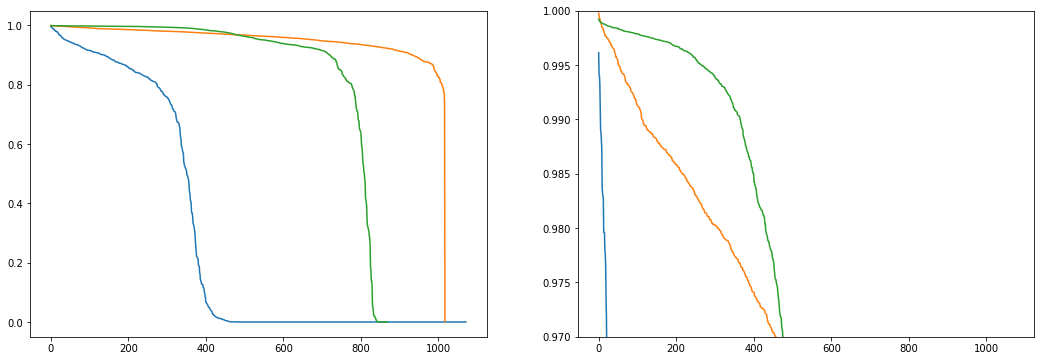

In [28]:
plt.figure(figsize=(18,6))
plt.subplot(1,2,1)
#plt.plot(sorted(old_proc_df.sort_values(['name', 'idotp']).drop_duplicates('name')['idotp'].values, reverse = True))
plt.plot(sorted(old_proc_df.sort_values(['name_fix', 'idotp']).drop_duplicates('name_fix')['idotp'].values, reverse = True))
#plt.plot(sorted(proc_df.sort_values(['name', 'idotp']).drop_duplicates('name')['idotp'].values, reverse = True))
plt.plot(sorted(proc_df.sort_values(['name_fix', 'idotp']).drop_duplicates('name_fix')['idotp'].values, reverse = True))
plt.plot(sorted(old_df.sort_values(['name', 'fit_to_theo_dist']).drop_duplicates('name')['fit_to_theo_dist'].values, reverse = True))
plt.subplot(1,2,2)
#plt.plot(sorted(old_proc_df.sort_values(['name', 'idotp']).drop_duplicates('name')['idotp'].values, reverse = True))
plt.plot(sorted(old_proc_df.sort_values(['name_fix', 'idotp']).drop_duplicates('name_fix')['idotp'].values, reverse = True))
#plt.plot(sorted(proc_df.sort_values(['name', 'idotp']).drop_duplicates('name')['idotp'].values, reverse = True))
plt.plot(sorted(proc_df.sort_values(['name_fix', 'idotp']).drop_duplicates('name_fix')['idotp'].values, reverse = True))
plt.plot(sorted(old_df.sort_values(['name', 'fit_to_theo_dist']).drop_duplicates('name')['fit_to_theo_dist'].values, reverse = True))
plt.ylim(0.97,1)

In [29]:
library_info['Drift Time MS1'] = library_info['im_mono'] / 200.0 * 13.781163434903 
proc_df['new_dt_ubound'] = library_info.iloc[proc_df['index'].values]['Drift Time MS1'].values * (1+0.06)
proc_df['new_dt_lbound'] = library_info.iloc[proc_df['index'].values]['Drift Time MS1'].values * (1-0.06)
old_df['old_dt_ubound'] = old_df['input_DTs'].values * (1+0.06)
old_df['old_dt_lbound'] = old_df['input_DTs'].values * (1-0.06)

In [30]:
mrg = old_df.merge(proc_df, on='name_fix')
mrg['idotp_diff'] = [x-y for x, y in zip(mrg['idotp'].values, mrg['fit_to_theo_dist'].values)] #negative diff is worse for new
mrg['rt_diff'] = [x-y for x, y in zip(mrg['rt'].values, mrg['input_RTs'].values)] #higher is worse
mrg['dt_diff'] = [x-y for x, y in zip(mrg['dt'], mrg['input_DTs'])]
mrg['ubound_diff'] = [x-y for x, y in zip(mrg['new_dt_ubound'].values, mrg['old_dt_ubound'].values)]
mrg['lbound_diff'] = [x-y for x, y in zip(mrg['new_dt_lbound'].values, mrg['old_dt_lbound'].values)]
mrg['ubound_diff_bins'] = mrg['ubound_diff'] * 200 / 13.781163434903
mrg['lbound_diff_bins'] = mrg['lbound_diff'] * 200 / 13.781163434903
mrg = mrg.loc[mrg['charge_x'] == mrg['charge_y']]
mrg = mrg.sort_values(['rt_diff', 'fit_to_theo_dist', 'idotp_diff'], ascending = [True, False, False])

In [31]:
test = mrg.loc[mrg['fit_to_theo_dist'] > 0.99]
#test = test.loc[abs(test['idotp_diff']) > 0.1]
test = test.loc[abs(test['rt_diff']) < 0.1]
test = test.loc[abs(test['dt_diff']) < 0.3]

In [32]:
test.sort_values(['idotp_diff', 'dt_diff', 'rt_diff', 'fit_to_theo_dist'], ascending = [True, True, False, False])[['index', 'dt_diff', 'dt', 'rt_diff', 'idotp', 'fit_to_theo_dist', 'idotp_diff']][:50]

index   dt_diff         dt   rt_diff     idotp  fit_to_theo_dist  \
7013    406 -0.062053   6.724650  0.051644  0.962665          0.996162   
6470    355 -0.132090   6.031345  0.013455  0.973739          0.998440   
893    1461 -0.093887   9.116639  0.051917  0.969868          0.992997   
881    1461 -0.093887   9.116639  0.035000  0.969868          0.992566   
3978   1304 -0.133713   5.960470  0.091819  0.975485          0.996287   
3260   1150 -0.163081   8.285672  0.060766  0.974570          0.992674   
5692   1213 -0.148935  11.277658  0.050004  0.975564          0.992351   
2039    323 -0.181466   5.981969  0.074294  0.982151          0.998373   
5684   1213 -0.148935  11.277658  0.016204  0.975564          0.991593   
583    1134 -0.113246   6.119441  0.090621  0.983640          0.998877   
1491   1544 -0.091037   6.418658  0.093232  0.983328          0.998525   
4764    511 -0.098270   5.303392  0.083572  0.977968          0.993085   
1503   1544 -0.091037   6.418658 -0.011068  0.983328          0.998339   
5580    289 -0.143177   6.228014  0.070432  0.983214          0.998166   
5403   1675 -0.178115   6.400832  0.064873  0.981237          0.996035   
5394   1675 -0.178115   6.400832  0.014139  0.981237          0.996035   
598    1134 -0.113246   6.119441  0.006087  0.983640          0.998357   
4520   1349 -0.110971   6.398724  0.000859  0.984233          0.998695   
4526   1349 -0.110971   6.398724  0.085393  0.984233          0.998419   
2580    705 -0.135173   6.305270  0.075353  0.984785          0.998259   
4083   1602 -0.156954   6.421994  0.099204  0.984360          0.996986   
4101    494 -0.122693   7.425783  0.078726  0.985717          0.998231   
2092   2437 -0.171173   7.862068  0.042118  0.988367          0.998539   
8105    539 -0.155828   6.561623  0.042872  0.989600          0.998071   
7489    667  0.093034   6.671982 -0.038575  0.990393          0.998793   
4258   1310 -0.105307   6.681397  0.087099  0.988896          0.997107   
4074   1600 -0.064882   8.245367  0.080224  0.990656          0.998744   
4069   1602 -0.156954   6.421994 -0.002246  0.984360          0.992111   
922    1357 -0.128470   9.082056  0.089045  0.991333          0.999059   
806     939 -0.146468   7.609765  0.046764  0.992283          0.998927   
4723    913 -0.108590   7.855399  0.069500  0.992629          0.999192   
5996    152 -0.080685   6.775271  0.061148  0.986843          0.993153   
1906     73 -0.125466   5.553204  0.055451  0.992520          0.998769   
4199    234 -0.060444   7.141772  0.038244  0.991285          0.997147   
6703   2046 -0.012098   8.090395  0.090751  0.992624          0.998272   
7854    906 -0.138939   7.063277  0.034358  0.992852          0.998102   
3311    442 -0.000744   6.312526  0.013902  0.989577          0.994804   
2668   1930 -0.109067  10.140240  0.078572  0.992281          0.997372   
4846    470 -0.120184   7.636049  0.088248  0.994963          0.999352   
7520    507 -0.177915   6.885797  0.038123  0.993628          0.997720   
7965    655 -0.123053  11.095783  0.086334  0.990251          0.994261   
7885    591 -0.138228  10.041827  0.061570  0.993374          0.997316   
4953    883 -0.168357   6.895355  0.045425  0.993340          0.997217   
3035    797 -0.118951   8.399054  0.085228  0.988241          0.992002   
7203   1119 -0.186584   6.877127  0.031646  0.991210          0.994916   
5379    476 -0.131391   7.763346  0.071606  0.994848          0.998495   
1028    812 -0.121981   6.526218  0.050297  0.990564          0.994155   
542     325 -0.114244   7.780492  0.009860  0.994266          0.997768   
2201     60 -0.100654   7.863335 -0.005586  0.994188          0.997576   
6667    136 -0.113421   7.019543  0.057176  0.994229          0.997476   

      idotp_diff  
7013   -0.033497  
6470   -0.024702  
893    -0.023128  
881    -0.022698  
3978   -0.020803  
3260   -0.018104  
5692   -0.016787  
2039   -0.016222  
5684   -0.016029  
583    -0.015237  
1491   -0.015198  
476

In [33]:
test.sort_values(['idotp_diff', 'dt_diff', 'rt_diff', 'fit_to_theo_dist'], ascending = [True, True, False, False])[['index', 'dt_diff', 'dt', 'rt_diff', 'idotp', 'fit_to_theo_dist', 'idotp_diff']]

index   dt_diff        dt   rt_diff     idotp  fit_to_theo_dist  \
7013    406 -0.062053  6.724650  0.051644  0.962665          0.996162   
6470    355 -0.132090  6.031345  0.013455  0.973739          0.998440   
893    1461 -0.093887  9.116639  0.051917  0.969868          0.992997   
881    1461 -0.093887  9.116639  0.035000  0.969868          0.992566   
3978   1304 -0.133713  5.960470  0.091819  0.975485          0.996287   
...     ...       ...       ...       ...       ...               ...   
8095    232 -0.133205  6.653498  0.036367  0.994751          0.990004   
4018   2258 -0.161410  7.941083  0.084388  0.998331          0.992824   
7673   1154  0.027731  8.615002  0.028936  0.997270          0.991450   
4904    752 -0.123099  7.425378  0.041843  0.998532          0.991804   
675    1549 -0.133664  6.860796 -0.022818  0.997626          0.990694   

      idotp_diff  
7013   -0.033497  
6470   -0.024702  
893    -0.023128  
881    -0.022698  
3978   -0.020803  
...          ...  
8095    0.004747  
4018    0.005507  
7673    0.005820  
4904    0.006728  
675     0.006932  

[192 rows x 7 columns]

In [35]:
i = 1213 #355 #406 TBD #1213 TBD #1150 confounding peak right on undeut #1461 very difficult factorization #695 #1555 #1836 #557

In [ ]:
#Idotp_check for single charge by lib_info index

ins = glob.glob("resources/tensors/"+str(i)+"_*UN*")

#make hxprot representation per sequence
name = library_info.iloc[i]['name']
charge = library_info.iloc[i]['charge']
seq = library_info.loc[library_info['name'] == name]['sequence'].values[0]
hx_prot = hxtools.hxprot(seq = seq)
dot_products = []

#Compute DataTensor init inputs
max_peak_center = len(seq)
total_isotopes = max_peak_center+high_mass_margin 
total_mass_window = low_mass_margin+total_isotopes
est_peak_gaps = [0] + list(np.linspace(c13_mass_diff, hd_mass_diff, 7)) + [hd_mass_diff for x in range(total_isotopes - 8)]
cum_peak_gaps = np.cumsum(est_peak_gaps)

mz_lows = library_info['obs_mz'].values[i] - (low_mass_margin/library_info['charge'].values[i])
mz_highs = library_info['obs_mz'].values[i] - (total_isotopes/library_info['charge'].values[i])
mz_centers = library_info['obs_mz'].values[i] + (cum_peak_gaps/library_info['charge'].values[i])
low_lims = mz_centers * ((1000000.0 - ppm_radius)/1000000.0)
high_lims = mz_centers * ((1000000.0 + ppm_radius)/1000000.0)

#find rt_group undeut tensors
undeut_fns = [fn for fn in glob.glob("resources/tensors/"+str(i)+"_*") if "UN" in fn]

print("Debug: Start undeut factorizations")
count = 1
undeut_ics = []
gauss_undeut_ics = []
DTs = []
charge_ic_int_mzs = []
for fn in ins:
    #read mzml 
    output = hx.limit_read(fn)

    #make DataTensor
    newDataTensor = hx.DataTensor(
                            source_file = fn,
                            tensor_idx = i,
                            timepoint_idx = 0, 
                            name = name, 
                            total_mass_window = total_mass_window,
                            n_concatenated = 1,
                            charge_states = [library_info["charge"].values[i]], 
                            rts = output[0], 
                            dts = output[1], 
                            seq_out = output[2], 
                            int_seq_out = None
                            )

    newDataTensor.lows = np.searchsorted(newDataTensor.mz_labels, low_lims)
    newDataTensor.highs = np.searchsorted(newDataTensor.mz_labels, high_lims)
    #newDataTensor.factorize()

    #Hacky, clean
    #[undeut_ics.append(ic) for i in range(len(newDataTensor.factors)) for ic in newDataTensor.factors[i].isotope_clusters]

    newDataTensor.factorize(gauss_params=(3,1))
    [gauss_undeut_ics.append(ic) for i in range(len(newDataTensor.factors)) for ic in newDataTensor.factors[i].isotope_clusters]
    DTs.append(newDataTensor)

    count += 1

for ic in gauss_undeut_ics:
    df = pd.DataFrame(ic.baseline_integrated_mz, columns = ['major_species_integrated_intensities'])
    fit = hx_prot.calculate_isotope_dist(df)
    ic.undeut_ground_dot_product = fit
    dot_products.append((fit, ic.charge_states, ic.baseline_integrated_mz))
    charge_ic_int_mzs.append(ic.baseline_integrated_mz)

if len(dot_products) > 0:
    best_idotp_idx = np.argmax(np.asarray(dot_products)[:,0])
    best_idotp = max(np.asarray(dot_products)[:,0])
else:
    best_idotp = 0

factors = [factor.integrated_mz_data for tensor in DTs for factor in tensor.factors] 
factor_frames = [[factor[:i]for i in range(8,12)] for factor in factors]
best_factor_idotp = [max([hx_prot.calculate_isotope_dist(pd.DataFrame(frame, columns = ['major_species_integrated_intensities']))for factor in factor_frames for frame in factor ]), np.argmax([hx_prot.calculate_isotope_dist(pd.DataFrame(frame, columns = ['major_species_integrated_intensities']))for factor in factor_frames for frame in factor ])]
#print("Debug: Loop Complete")


#best undeut peak w/ theor undeut
plt.figure(figsize=(20,6))
plt.plot(hx_prot.calculate_theo_isotope_dist())
plt.plot(dot_products[best_idotp_idx][2])
plt.show()
plt.close()

#all ics found w/ theor undeut
plt.figure(figsize=(20,6))
plt.plot(hx_prot.isotope_dist)
for ic in gauss_undeut_ics:
    plt.plot(ic.baseline_integrated_mz)
plt.show()
plt.close()

#all factor int mzs w/ theor undeut
for dt in DTs:
    plt.figure(figsize=(20,6))
    plt.plot(hx_prot.isotope_dist)
    for factor in dt.factors:
        plt.plot(factor.integrated_mz_data)
    plt.show()
    plt.close()

n_factors = [dt.factors[0].n_factors for dt in DTs]

print("Index: "+str(i)+", IdotP: "+str(best_idotp)+", Best Factor IdotP: "+str(best_factor_idotp))    
out = pd.DataFrame({'index': [i], 'name': [name], 'charge': [charge], 'idotp': [best_idotp],"factor_idotp": [best_factor_idotp], "best": [dot_products[best_idotp_idx][2]], "ic_mzs": [charge_ic_int_mzs], "factor_mzs": [factors], "n_factors": [n_factors]})
display(out)

Debug: Start undeut factorizations
Beginning Factorization...
Done: T+52.4138925075531
Beginning Factorization...
Done: T+54.583658933639526
Beginning Factorization...


In [ ]:
proc_df.loc[proc_df['name_fix'] == 'HEEH_rd4_0872.pdb'][['index', 'idotp']]

In [ ]:
old_df.loc[old_df['name'] == "HEEH_rd4_0872.pdb"]["fit_to_theo_dist"]

Debug: Start undeut factorizations
Beginning Factorization...


/projects/b1107/wes/HDX_LIMIT-Pipeline/workflow/scripts/auxiliary/LC_IM_MS_TensorAnalysis.py:149: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  self.seq_out = np.array(kwargs['seq_out'])


Done: T+11.18138599395752
Beginning Factorization...
Done: T+11.016045570373535
Beginning Factorization...
Done: T+10.83864426612854


/home/rwl0960/.conda/envs/dask_lab/lib/python3.7/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


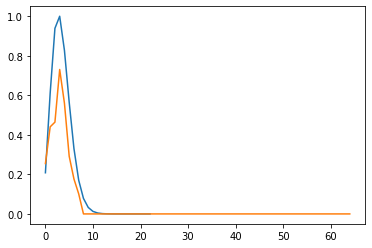

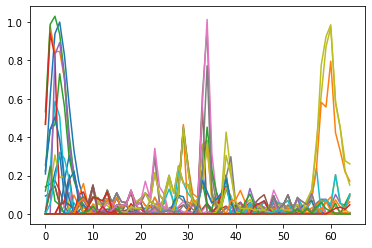

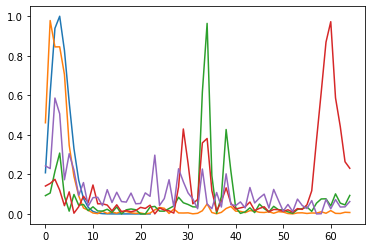

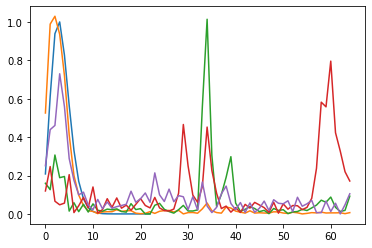

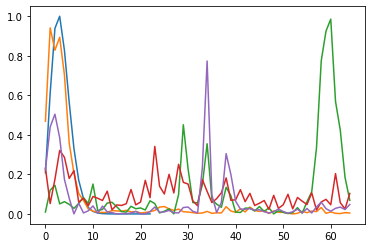

Index: 0, IdotP: 0.9811055519004781, Best Factor IdotP: [0.9808697569528619, 28]


ValueError: arrays must all be same length

In [5]:
#Iterator version
out = []
for i in range(len(library_info))[:1]:
    ins = glob.glob("resources/tensors/"+str(i)+"_*UN*")

    #make hxprot representation per sequence
    name = library_info.iloc[i]['name']
    charge = library_info.iloc[i]['charge']
    seq = library_info.loc[library_info['name'] == name]['sequence'].values[0]
    hx_prot = hxtools.hxprot(seq = seq)
    dot_products = []

    #Compute DataTensor init inputs
    max_peak_center = len(seq)
    total_isotopes = max_peak_center+high_mass_margin 
    total_mass_window = low_mass_margin+total_isotopes
    est_peak_gaps = [0] + list(np.linspace(c13_mass_diff, hd_mass_diff, 7)) + [hd_mass_diff for x in range(total_isotopes - 8)]
    cum_peak_gaps = np.cumsum(est_peak_gaps)

    mz_lows = library_info['obs_mz'].values[i] - (low_mass_margin/library_info['charge'].values[i])
    mz_highs = library_info['obs_mz'].values[i] - (total_isotopes/library_info['charge'].values[i])
    mz_centers = library_info['obs_mz'].values[i] + (cum_peak_gaps/library_info['charge'].values[i])
    low_lims = mz_centers * ((1000000.0 - ppm_radius)/1000000.0)
    high_lims = mz_centers * ((1000000.0 + ppm_radius)/1000000.0)

    #find rt_group undeut tensors
    undeut_fns = [fn for fn in glob.glob("resources/tensors/"+str(i)+"_*") if "UN" in fn]

    print("Debug: Start undeut factorizations")
    count = 1
    undeut_ics = []
    gauss_undeut_ics = []
    DTs = []
    charge_ic_int_mzs = []
    for fn in ins:
        #read mzml 
        output = hx.limit_read(fn)

        #make DataTensor
        newDataTensor = hx.DataTensor(
                                source_file = fn,
                                tensor_idx = i,
                                timepoint_idx = 0, 
                                name = name, 
                                total_mass_window = total_mass_window,
                                n_concatenated = 1,
                                charge_states = [library_info["charge"].values[i]], 
                                rts = output[0], 
                                dts = output[1], 
                                seq_out = output[2], 
                                int_seq_out = None
                                )

        newDataTensor.lows = np.searchsorted(newDataTensor.mz_labels, low_lims)
        newDataTensor.highs = np.searchsorted(newDataTensor.mz_labels, high_lims)
        #newDataTensor.factorize()

        #Hacky, clean
        #[undeut_ics.append(ic) for i in range(len(newDataTensor.factors)) for ic in newDataTensor.factors[i].isotope_clusters]

        newDataTensor.factorize(gauss_params=(3,1))
        [gauss_undeut_ics.append(ic) for i in range(len(newDataTensor.factors)) for ic in newDataTensor.factors[i].isotope_clusters]
        DTs.append(newDataTensor)

        count += 1

    for ic in gauss_undeut_ics:
        df = pd.DataFrame(ic.baseline_integrated_mz, columns = ['major_species_integrated_intensities'])
        fit = hx_prot.calculate_isotope_dist(df)
        ic.undeut_ground_dot_product = fit
        dot_products.append((fit, ic.charge_states, ic.baseline_integrated_mz))
        charge_ic_int_mzs.append(ic.baseline_integrated_mz)

    if len(dot_products) > 0:
        best_idotp_idx = np.argmax(np.asarray(dot_products)[:,0])
        best_idotp = max(np.asarray(dot_products)[:,0])
    else:
        best_idotp = 0

    factors = [factor.integrated_mz_data for tensor in DTs for factor in tensor.factors] 
    factor_frames = [[factor[:i]for i in range(8,12)] for factor in factors]
    best_factor_idotp = [max([hx_prot.calculate_isotope_dist(pd.DataFrame(frame, columns = ['major_species_integrated_intensities']))for factor in factor_frames for frame in factor ]), np.argmax([hx_prot.calculate_isotope_dist(pd.DataFrame(frame, columns = ['major_species_integrated_intensities']))for factor in factor_frames for frame in factor ])]
    #print("Debug: Loop Complete")
    

    #best undeut peak w/ theor undeut
    plt.figure()
    plt.plot(hx_prot.calculate_theo_isotope_dist())
    plt.plot(dot_products[best_idotp_idx][2])
    plt.show()
    plt.close()
    
    #all ics found w/ theor undeut
    plt.figure()
    plt.plot(hx_prot.isotope_dist)
    for ic in gauss_undeut_ics:
        plt.plot(ic.baseline_integrated_mz)
    plt.show()
    plt.close()
    
    #all factor int mzs w/ theor undeut
    for dt in DTs:
        plt.figure()
        plt.plot(hx_prot.isotope_dist)
        for factor in dt.factors:
            plt.plot(factor.integrated_mz_data)
        plt.show()
        plt.close()
    
    n_factors = [dt.factors[0].n_factors for dt in DTs]
    
    print("Index: "+str(i)+", IdotP: "+str(best_idotp)+", Best Factor IdotP: "+str(best_factor_idotp))    
    out.append(pd.DataFrame({'index': [i], 'name': [name], 'charge': [charge], 'idotp': [best_idotp],"factor_idotp": [best_factor_idotp], "best": [dot_products[best_idotp_idx][2]], "ic_mzs": [charge_ic_int_mzs], "factor_mzs": [factors], "n_factors": n_factors}))

In [ ]:
%debug

> /Users/rwl0960/opt/anaconda3/envs/dask_lab/lib/python3.7/site-packages/scipy/linalg/decomp_svd.py(126)svd()
    124     # perform decomposition
    125     u, s, v, info = gesXd(a1, compute_uv=compute_uv, lwork=lwork,
--> 126                           full_matrices=full_matrices, overwrite_a=overwrite_a)
    127 
    128     if info > 0:



ipdb>  u


> /Users/rwl0960/opt/anaconda3/envs/dask_lab/lib/python3.7/site-packages/tensorly/backend/core.py(695)partial_svd()
    693 
    694             # Default on standard SVD
--> 695             U, S, V = scipy.linalg.svd(matrix, full_matrices=full_matrices)
    696             U, S, V = U[:, :n_eigenvecs], S[:n_eigenvecs], V[:n_eigenvecs, :]
    697         else:



ipdb>  u


> /Users/rwl0960/opt/anaconda3/envs/dask_lab/lib/python3.7/site-packages/tensorly/decomposition/candecomp_parafac.py(64)initialize_factors()
     62         factors = []
     63         for mode in range(tl.ndim(tensor)):
---> 64             U, _, _ = svd_fun(unfold(tensor, mode), n_eigenvecs=rank)
     65 
     66             if tensor.shape[mode] < rank:



ipdb>  u


> /Users/rwl0960/opt/anaconda3/envs/dask_lab/lib/python3.7/site-packages/tensorly/decomposition/candecomp_parafac.py(154)parafac()
    152                                  random_state=random_state,
    153                                  non_negative=non_negative,
--> 154                                  normalize_factors=normalize_factors)
    155     rec_errors = []
    156     norm_tensor = tl.norm(tensor, 2)



ipdb>  u


> /Users/rwl0960/opt/anaconda3/envs/dask_lab/lib/python3.7/site-packages/tensorly/decomposition/candecomp_parafac.py(278)non_negative_parafac()
    276     """
    277     return parafac(tensor, rank, n_iter_max=n_iter_max, init=init, svd=svd,
--> 278                    tol=tol, random_state=random_state, verbose=verbose, non_negative=True)
    279 
    280 



ipdb>  u


> /Users/rwl0960/Documents/hdx/HDX_LIMIT-Pipeline/workflow/scripts/auxiliary/LC_IM_MS_TensorAnalysis.py(372)factorize()
    370             t1 = time.time()
    371             #print('Starting '+str(nf)+' Factors... T+'+str(t1-t))
--> 372             nnp = non_negative_parafac(grid, nf)
    373             t2 = time.time()
    374             #print('Factorization Duration: '+str(t2-t1))



ipdb>  u


> <ipython-input-2-dc1cd022191b>(60)<module>()
     58         #[undeut_ics.append(ic) for i in range(len(newDataTensor.factors)) for ic in newDataTensor.factors[i].isotope_clusters]
     59 
---> 60         newDataTensor.factorize(gauss_params=(3,1))
     61         [gauss_undeut_ics.append(ic) for i in range(len(newDataTensor.factors)) for ic in newDataTensor.factors[i].isotope_clusters]
     62         DTs.append(newDataTensor)



ipdb>  DTs


[<LC_IM_MS_TensorAnalysis.DataTensor object at 0x7fd094356110>, <LC_IM_MS_TensorAnalysis.DataTensor object at 0x7fd079239c50>]


ipdb>  DTs[0].factors[0].timepoint_idx


0


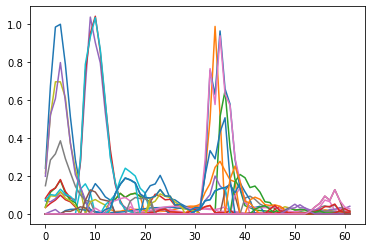

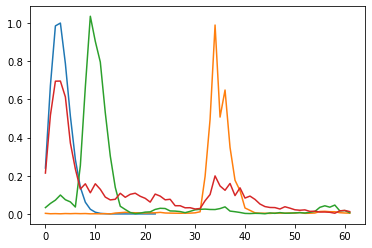

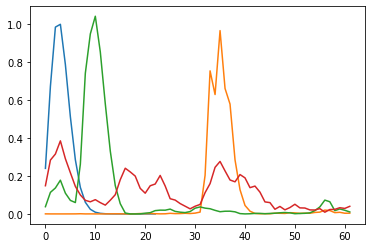

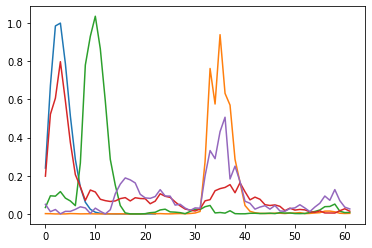

In [19]:
out = find_peaks(DTs[2].factors[2].integrated_mz_data, prominence = 0.01, width = 0.5)
ics = [[0]*out[1]['left_bases'][i]+DTs[2].factors[2].integrated_mz_data[out[1]['left_bases'][i]:(out[1]['left_bases'][i+1])+1]+[0]*(len(DTs[2].factors[2].integrated_mz_data)-(out[1]['left_bases'][i+1]+1)) for i in range(len(out[0])-1)]

IndexError: list index out of range

In [33]:
ic_idxs = [(out[1]['left_bases'][i], out[1]['left_bases'][i+1]) for i in range(len(out[0])-1)]

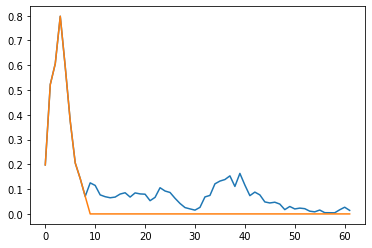

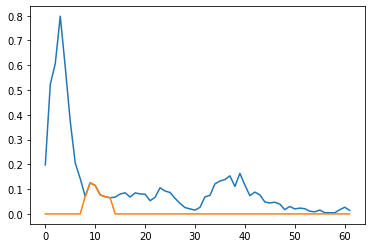

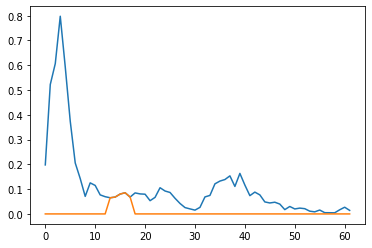

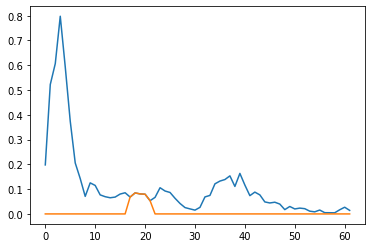

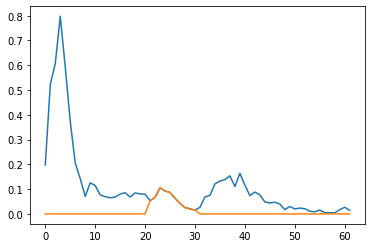

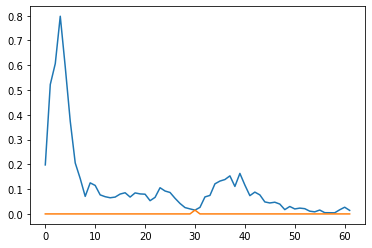

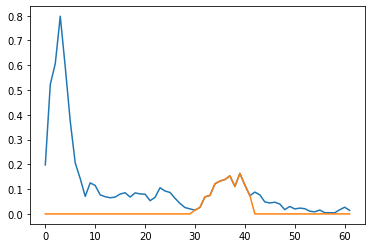

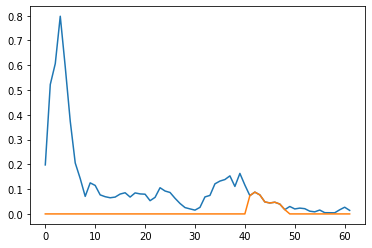

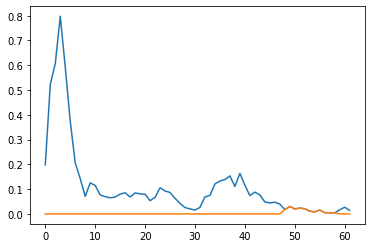

In [34]:
for ic in ics:
    plt.figure()
    plt.plot(DTs[2].factors[2].integrated_mz_data)
    plt.plot(ic)
    plt.show()
    plt.close()

In [35]:
len(ics)

9

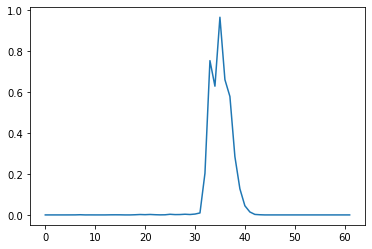

In [59]:
plt.plot(ics[0])

In [22]:
library_info.loc[library_info['name'].str.contains("HHH_rd1_0579.pdb")][["RT","im_mono",'charge']]

RT     im_mono  charge
557    7.422434  140.589610     4.0
558    7.446333   96.277339     5.0
559    7.536626   85.628227     6.0
560    7.530146   77.782315     7.0
561    7.591134   71.619563     8.0
3024  14.294685  116.387883     5.0

In [8]:
lst = lst.split()

In [9]:
lst = [i for i in lst if "conda-forge" not in i and "bioconda" not in i]

In [10]:
pairs = [[lst[i], lst[i+1]] for i in np.arange(0, len(lst), 3)]

In [11]:
mods = [i[0] for i in pairs]
vers = [i[1] for i in pairs]

In [12]:
vers_df = pd.DataFrame.from_dict({"module": mods, "version": vers})

In [14]:
vers_df.to_csv("dask_lab_module_list_df.csv")

In [15]:
vers_df['module'].values

array(['_libgcc_mutex', 'aioeasywebdav', 'aiohttp', 'appdirs', 'arrow',
       'async-timeout', 'attrs', 'backcall', 'bcrypt', 'binaryornot',
       'biopython', 'blas', 'bleach', 'bokeh', 'boto3', 'botocore',
       'bzip2', 'ca-certificates', 'cachetools', 'cairo', 'certifi',
       'cffi', 'chardet', 'click', 'cloudpickle', 'configargparse',
       'cookiecutter', 'cryptography', 'cycler', 'cytoolz', 'dask',
       'dask-core', 'datrie', 'dbus', 'decorator', 'defusedxml',
       'distributed', 'docutils', 'dropbox', 'entrypoints', 'expat',
       'fastdtw', 'fftw', 'filechunkio', 'fontconfig', 'freetype',
       'fsspec', 'ftputil', 'future', 'gettext', 'ghostscript', 'giflib',
       'gitdb2', 'gitpython', 'glib', 'gmp', 'google-api-core',
       'google-auth', 'google-cloud-core', 'google-cloud-storage',
       'google-resumable-media', 'googleapis-common-protos', 'graphite2',
       'graphviz', 'gst-plugins-base', 'gstreamer', 'harfbuzz',
       'heapdict', 'icu', 'idna', 'imagem

In [68]:
undeut_ics[0].abs_mz_com * undeut_ics[0].charge_states[0]

5497.932953834787

In [69]:
molmass.analyze(molmass.from_peptide(hx_prot.sequence)).split('\n')[3].split()[-1]

'5436.6717'

In [99]:
len(proc_df)

4310

In [100]:
len(old_df)

2123

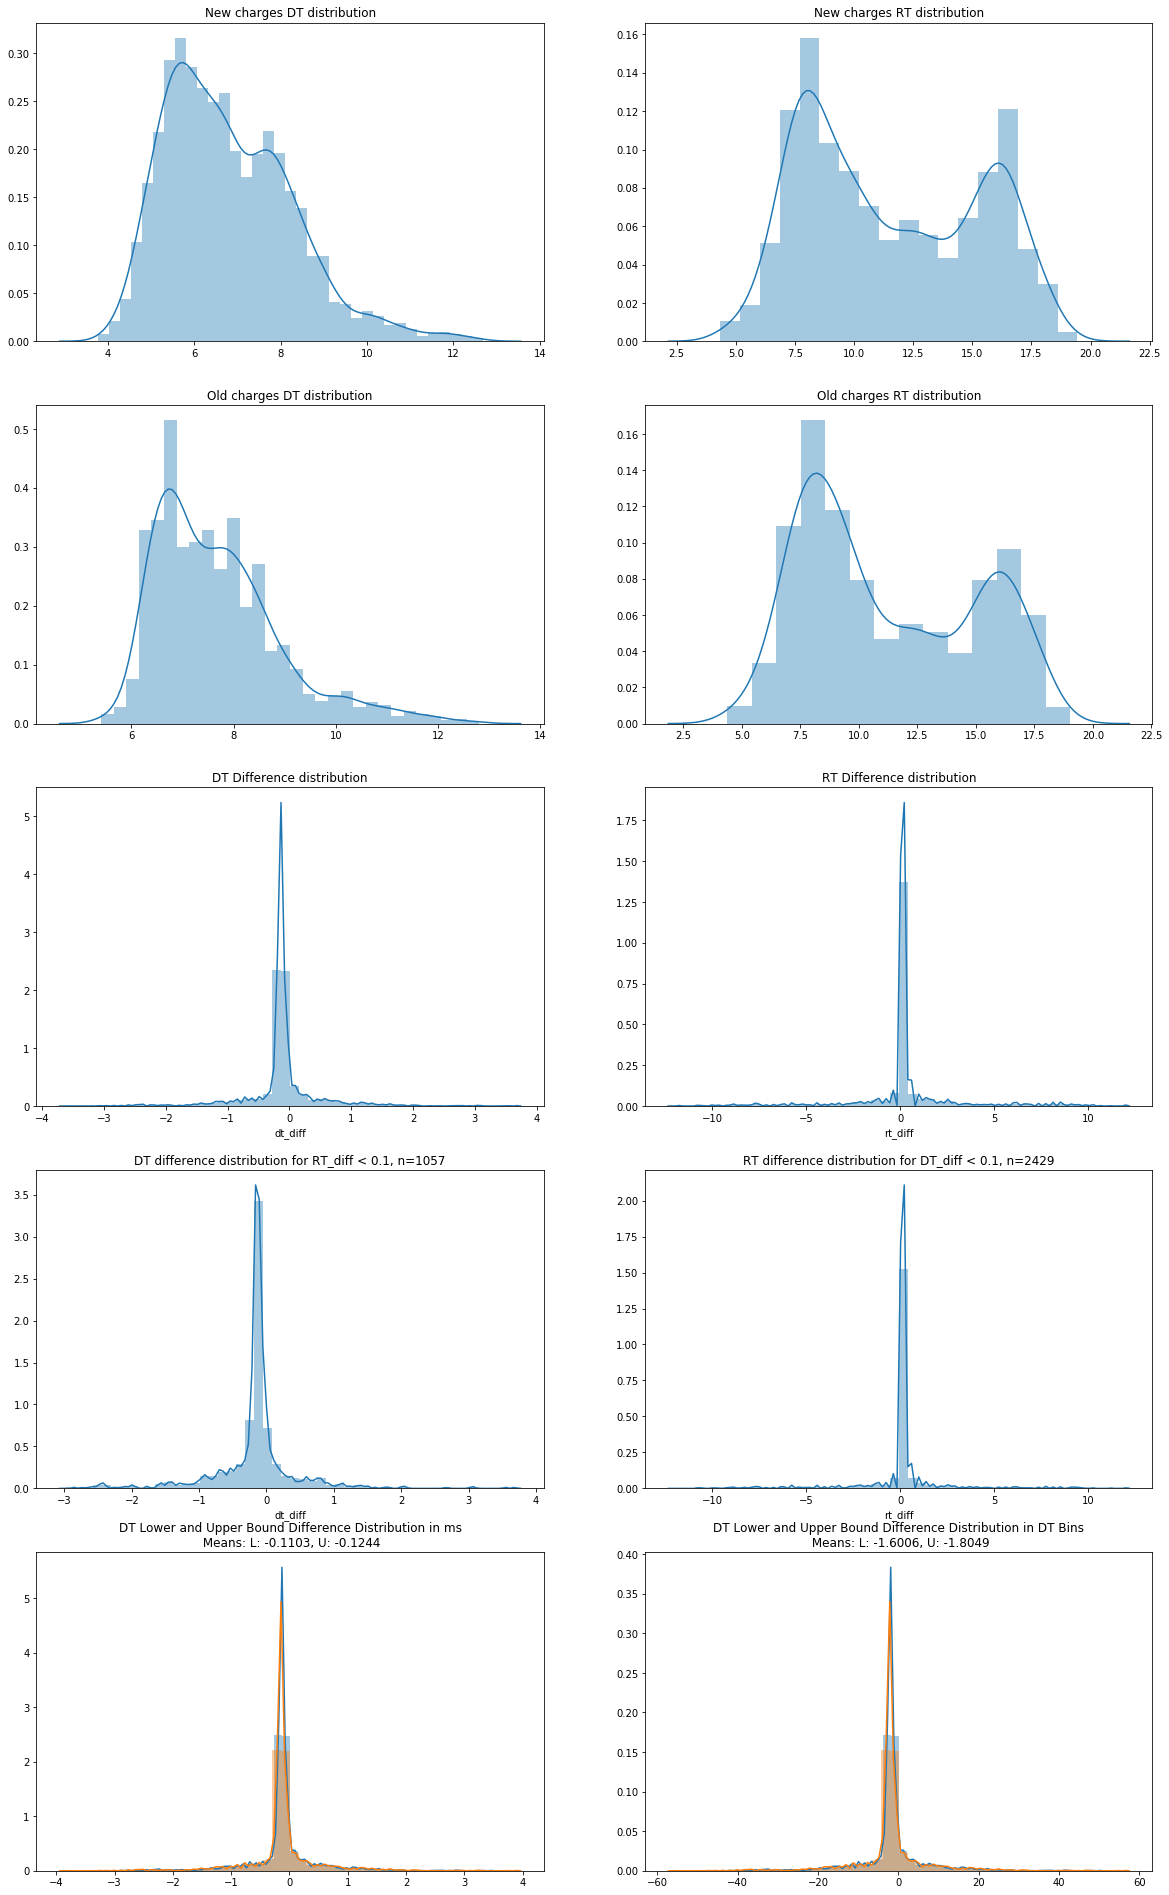

In [55]:
fig = plt.figure(figsize=(20,34))
ax1 = fig.add_subplot(521)
ax1.title.set_text('New charges DT distribution')
sns.distplot(proc_df['dt'].values)
ax2 = plt.subplot(523)
ax2.title.set_text('Old charges DT distribution')
sns.distplot(old_df['input_DTs'].values)
ax3 = plt.subplot(522)
ax3.title.set_text('New charges RT distribution')
sns.distplot(proc_df['rt'].values)
ax4 = plt.subplot(524)
ax4.title.set_text('Old charges RT distribution')
sns.distplot(old_df['input_RTs'].values)
ax5 = plt.subplot(525)
ax5.title.set_text('DT Difference distribution')
sns.distplot(mrg['dt_diff'])
ax6 = plt.subplot(526)
ax6.title.set_text('RT Difference distribution')
sns.distplot(mrg['rt_diff'])
ax7 = plt.subplot(527)
ax7.title.set_text('DT difference distribution for RT_diff < 0.1, n='+str(len(mrg.loc[mrg['rt_diff'] < 0.1]['dt_diff'])))
sns.distplot(mrg.loc[mrg['rt_diff'] < 0.1]['dt_diff'])
ax8 = plt.subplot(528)
ax8.title.set_text('RT difference distribution for DT_diff < 0.1, n='+str(len(mrg.loc[mrg['dt_diff'] < 0.1]['rt_diff'])))
sns.distplot(mrg.loc[mrg['dt_diff'] < 0.1]['rt_diff'])
ax9 = plt.subplot(529)
ax9.title.set_text('DT Lower and Upper Bound Difference Distribution in ms\n Means: L: '+str(np.round(np.mean(mrg['lbound_diff'].values), 4))+", U: "+str(np.round(np.mean(mrg['ubound_diff'].values), 4)))
sns.distplot(mrg['lbound_diff'].values)
sns.distplot(mrg['ubound_diff'].values)
ax10 = plt.subplot(5,2,10)
ax10.title.set_text('DT Lower and Upper Bound Difference Distribution in DT Bins\n Means: L: '+str(np.round(np.mean(mrg['lbound_diff_bins'].values), 4))+", U: "+str(np.round(np.mean(mrg['ubound_diff_bins'].values), 4)))
sns.distplot(mrg['lbound_diff_bins'].values)
sns.distplot(mrg['ubound_diff_bins'].values)
plt.savefig('9_14_dist_comparison.png')

In [2]:
zuns = sorted(glob.glob("resources/tensors/0_*UN*"))

In [5]:
data = hx.limit_read(zuns[0])

In [ ]:
hx.DataTensor(source_file = zuns[0],
        tensor_idx = 0, 
        timepoint_idx = 0, 
        name = library_info.iloc[0]['name'], 
        total_mass_window,
        n_concatenated,
        charge_states,data[0], data[1], data[2])

**IDOTP CHECK**

In [ ]:
#make hxprot representation per sequence
name = library_info.iloc[i]['name']
charge = library_info.iloc[i]['charge']
seq = library_info.loc[library_info['name'] == name]['sequence'].values[0]
hx_prot = hxtools.hxprot(seq=seq)
dot_products = []

#Compute DataTensor init inputs
max_peak_center = len(seq)
total_isotopes = max_peak_center+high_mass_margin 
total_mass_window = low_mass_margin+total_isotopes
est_peak_gaps = [0] + list(np.linspace(c13_mass_diff, hd_mass_diff, 7)) + [hd_mass_diff for x in range(total_isotopes - 8)]
cum_peak_gaps = np.cumsum(est_peak_gaps)

mz_lows = library_info['obs_mz'].values[i] - (low_mass_margin/library_info['charge'].values[i])
mz_highs = library_info['obs_mz'].values[i] - (total_isotopes/library_info['charge'].values[i])
mz_centers = library_info['obs_mz'].values[i] + (cum_peak_gaps/library_info['charge'].values[i])
low_lims = mz_centers * ((1000000.0 - ppm_radius)/1000000.0)
high_lims = mz_centers * ((1000000.0 + ppm_radius)/1000000.0)

#find rt_group undeut tensors
undeut_fns = [fn for fn in glob.glob("resources/tensors/"+str(i)+"_*") if "UN" in fn]

print("Debug: Start undeut factorizations")
count = 1
undeut_ics = []
for fn in zuns:
    #read mzml 
    print("Loop: "+str(count)+", Debug 1")
    output = hx.limit_read(fn)
    print("Loop: "+str(count)+", Debug 2")
    #make DataTensor
    newDataTensor = hx.DataTensor(
                            source_file = fn,
                            tensor_idx = i,
                            timepoint_idx = 0, 
                            name = name, 
                            total_mass_window = total_mass_window,
                            n_concatenated = 1,
                            charge_states = [library_info["charge"].values[i]], 
                            rts = output[0], 
                            dts = output[1], 
                            seq_out = output[2], 
                            int_seq_out = None
                            )
    print("Loop: "+str(count)+", Debug 3")
    print("Tensor Dims: "+str(np.shape(newDataTensor.full_grid_out)))
    
    newDataTensor.lows = np.searchsorted(newDataTensor.mz_labels, low_lims)
    newDataTensor.highs = np.searchsorted(newDataTensor.mz_labels, high_lims)
    newDataTensor.factorize()
    print("Loop: "+str(count)+", Debug 4")
    #Hacky, clean
    [undeut_ics.append(ic) for i in range(len(newDataTensor.factors)) for ic in newDataTensor.factors[i].isotope_clusters]

    print("Loop: "+str(count)+", Debug 5")
    count += 1

for ic in undeut_ics:
    df = pd.DataFrame(ic.baseline_integrated_mz, columns = ['major_species_integrated_intensities'])
    fit = hx_prot.calculate_isotope_dist(df)
    ic.undeut_ground_dot_product = fit
    dot_products.append((fit, ic.charge_states))

if len(dot_products) > 0:
    best_idotp = max(np.asarray(dot_products)[:,0])
else:
    best_idotp = 0

print("Debug: Loop Complete")

pd.DataFrame({'index': [i], 'name': [name], 'charge': [charge], 'idotp': [best_idotp]})

Debug: Start undeut factorizations
Loop: 1, Debug 1
Loop: 1, Debug 2
Loop: 1, Debug 3
Tensor Dims: (47, 14, 751)
Beginning Factorization...


In [9]:
%debug

> /projects/b1107/wes/HDX_LIMIT-Pipeline/workflow/scripts/auxiliary/LC_IM_MS_TensorAnalysis.py(240)<listcomp>()
    238         retention_labels, drift_labels, sparse_data = data
    239 
--> 240         min_mz = min([min(x[:,0]) for x in sparse_data])
    241         max_mz = max([max(x[:,0]) for x in sparse_data])
    242         #print (min_mz, max_mz)



ipdb>  x


array([], shape=(0, 2), dtype=float32)


ipdb>  sparse_data


*** NameError: name 'sparse_data' is not defined


ipdb>  sparse_data


*** NameError: name 'sparse_data' is not defined


ipdb>  self.rts


*** NameError: name 'self' is not defined


ipdb>  self


*** NameError: name 'self' is not defined


ipdb>  u


> /projects/b1107/wes/HDX_LIMIT-Pipeline/workflow/scripts/auxiliary/LC_IM_MS_TensorAnalysis.py(240)sparse_to_full_tensor()
    238         retention_labels, drift_labels, sparse_data = data
    239 
--> 240         min_mz = min([min(x[:,0]) for x in sparse_data])
    241         max_mz = max([max(x[:,0]) for x in sparse_data])
    242         #print (min_mz, max_mz)



ipdb>  self


ipdb>  sparse_data


array([array([[1142.1599,   39.    ]], dtype=float32),
       array([], shape=(0, 2), dtype=float32),
       array([], shape=(0, 2), dtype=float32),
       array([], shape=(0, 2), dtype=float32),
       array([], shape=(0, 2), dtype=float32),
       array([[1130.0481,   34.    ],
       [1130.0629,   74.    ]], dtype=float32),
       array([], shape=(0, 2), dtype=float32),
       array([], shape=(0, 2), dtype=float32),
       array([[1132.339,   45.   ]], dtype=float32),
       array([[1133.6764,   27.    ]], dtype=float32),
       array([[1136.7952,   30.    ],
       [1136.8099,   45.    ],
       [1139.9476,   33.    ]], dtype=float32),
       array([], shape=(0, 2), dtype=float32),
       array([], shape=(0, 2), dtype=float32),
       array([], shape=(0, 2), dtype=float32),
       array([], shape=(0, 2), dtype=float32),
       array([[1138.1647,   55.    ],
       [1138.1793,   26.    ]], dtype=float32),
       array([[1131.1492,   45.    ]], dtype=float32),
       array([], shape=

ipdb>  len(sparse_data)


658


ipdb>  u


> /projects/b1107/wes/HDX_LIMIT-Pipeline/workflow/scripts/auxiliary/LC_IM_MS_TensorAnalysis.py(221)__init__()
    219             """
    220 
--> 221             self.retention_labels, self.drift_labels, self.mz_labels, self.min_mz, self.max_mz, self.full_grid_out = self.sparse_to_full_tensor((self.rts, self.dts, self.seq_out))
    222             self.full_gauss_grids = self.gauss(self.full_grid_out)
    223 



ipdb>  d


> /projects/b1107/wes/HDX_LIMIT-Pipeline/workflow/scripts/auxiliary/LC_IM_MS_TensorAnalysis.py(240)sparse_to_full_tensor()
    238         retention_labels, drift_labels, sparse_data = data
    239 
--> 240         min_mz = min([min(x[:,0]) for x in sparse_data])
    241         max_mz = max([max(x[:,0]) for x in sparse_data])
    242         #print (min_mz, max_mz)



ipdb>  quit


In [3]:
old_df = pd.read_csv('resources/library_info/old_master_df.csv')

old_proc_df = pd.read_csv('resources/library_info/idotp_proc_df_9_2020.csv')

In [2]:
#make table of all new charges and find matching old charge rt(s?, probably was filtering for single cluster/charge from naming conventions)

In [8]:
proc_df.columns

Index(['Unnamed: 0', 'index', 'name', 'charge', 'idotp', 'rt'], dtype='object')

In [9]:
proc_df.sort_values(['rt', 'idotp'])

Unnamed: 0  index                        name  charge         idotp  \
0              0      0    HHH_rd4_0891.pdb_4.33802     5.0  9.646407e-01   
4              0      4   HEEH_rd1_0125.pdb_4.41988     4.0  8.268960e-01   
10             0     10   HEEH_rd3_0224.pdb_4.43963     7.0  8.484195e-09   
6              0      6   HEEH_rd1_0125.pdb_4.41988     6.0  8.761886e-01   
2              0      2   HEEH_rd1_0966.pdb_4.37754     6.0  8.813491e-01   
...          ...    ...                         ...     ...           ...   
4308           0   4309  HEEH_rd4_0276.pdb_18.72244     7.0  0.000000e+00   
4307           0   4308  HEEH_rd4_0276.pdb_18.72244     6.0  0.000000e+00   
4313           0   4314   HHH_rd4_0269.pdb_18.98777     5.0  9.591543e-01   
4312           0   4313  HEEH_rd4_0246.pdb_18.86922     6.0  8.163959e-01   
4314           0   4315    HEEH_rd4_0528.pdb_19.191     4.0  8.931023e-01   

             rt  
0      4.349178  
4      4.383614  
10     4.400998  
6      4.439518  
2      4.453601  
...         ...  
4308  18.967132  
4307  18.989288  
4313  19.004371  
4312  19.109474  
4314  19.439584  

[4315 rows x 6 columns]

In [13]:
proc_df[['name', 'rt']].values[0][0]

'HHH_rd4_0891.pdb_4.33802'

In [4]:
proc_df['rt_group_diff'] = [tup[1] - float(tup[0].split('_')[-1]) for tup in proc_df[['name','rt']].values]

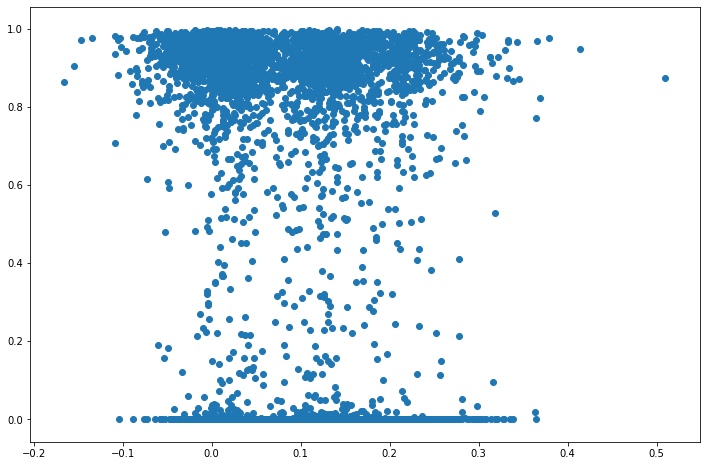

In [25]:
plt.figure(figsize=(12,8))
plt.scatter(list(proc_df.sort_values('rt_group_diff')['rt_group_diff'].values), list(proc_df.sort_values('rt_group_diff')['idotp'].values))

In [15]:
old_df.columns

Index(['Unnamed: 0', 'output', 'input_RTs', 'input_DTs', 'peak_centroids',
       'integrated_intensities', 'total_intensity', 'centroid',
       'undeut_centroid', 'major_species',
       'major_species_integrated_intensities', 'major_species_median',
       'major_species_total_intensity', 'major_species_centroid',
       'interference_height_ratio', 'interference_integral_ratio',
       'max_interference_integral_ratio', 'name', 'charge',
       'major_species_widths', 'fit_to_theo_dist'],
      dtype='object')

In [34]:
old_undeut_df = old_df.iloc[[j for i in np.arange(0,len(old_df), 23) for j in range(i,i+3)]]

In [35]:
proc_df['old'] = [0 for i in range(len(proc_df))]
old_undeut_df['old'] = [1 for i in range(len(old_undeut_df))]

/home/rwl0960/.conda/envs/dask_lab/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [47]:
proc_df['name_fix'] = ['_'.join(name.split('_')[:-1]) for name in proc_df['name'].values]

In [87]:
proc_df['rt_group_avg'] = [float(name.split('_')[-1]) for name in proc_df['name'].values]

In [49]:
old_undeut_df['name_fix'] = list(old_undeut_df['name'].values)

/home/rwl0960/.conda/envs/dask_lab/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [88]:
cdf = proc_df.merge(old_undeut_df, on='name_fix' )

In [82]:
cdf.columns

Index(['Unnamed: 0_x', 'index', 'name_x', 'charge_x', 'idotp', 'rt',
       'rt_group_diff', 'old_x', 'name_fix', 'rt_group_avg', 'Unnamed: 0_y',
       'output', 'input_RTs', 'input_DTs', 'peak_centroids',
       'integrated_intensities', 'total_intensity', 'centroid',
       'undeut_centroid', 'major_species',
       'major_species_integrated_intensities', 'major_species_median',
       'major_species_total_intensity', 'major_species_centroid',
       'interference_height_ratio', 'interference_integral_ratio',
       'max_interference_integral_ratio', 'name_y', 'charge_y',
       'major_species_widths', 'fit_to_theo_dist', 'old_y'],
      dtype='object')

In [89]:
charge_matches = cdf.loc[cdf['charge_x'] == cdf['charge_y']]

In [90]:
charge_matches['old_rt_diff'] = [abs(charge_matches.iloc[i]['rt_group_avg'] - charge_matches.iloc[i]['input_RTs']) for i in range(len(charge_matches))]

/home/rwl0960/.conda/envs/dask_lab/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [91]:
charge_matches.sort_values(['rt', 'name_x', 'charge_x', 'old_rt_diff', 'rt_group_diff',])

Unnamed: 0_x  index                      name_x  charge_x     idotp  \
1                 0      0    HHH_rd4_0891.pdb_4.33802       5.0  0.964641   
0                 0      0    HHH_rd4_0891.pdb_4.33802       5.0  0.964641   
2                 0      0    HHH_rd4_0891.pdb_4.33802       5.0  0.964641   
4                 0      0    HHH_rd4_0891.pdb_4.33802       5.0  0.964641   
3                 0      0    HHH_rd4_0891.pdb_4.33802       5.0  0.964641   
...             ...    ...                         ...       ...       ...   
31324             0   4313  HEEH_rd4_0246.pdb_18.86922       6.0  0.816396   
31325             0   4313  HEEH_rd4_0246.pdb_18.86922       6.0  0.816396   
31322             0   4313  HEEH_rd4_0246.pdb_18.86922       6.0  0.816396   
31321             0   4313  HEEH_rd4_0246.pdb_18.86922       6.0  0.816396   
31320             0   4313  HEEH_rd4_0246.pdb_18.86922       6.0  0.816396   

              rt  rt_group_diff  old_x           name_fix  rt_group_avg  ...  \
1       4.349178       0.011158      0   HHH_rd4_0891.pdb       4.33802  ...   
0       4.349178       0.011158      0   HHH_rd4_0891.pdb       4.33802  ...   
2       4.349178       0.011158      0   HHH_rd4_0891.pdb       4.33802  ...   
4       4.349178       0.011158      0   HHH_rd4_0891.pdb       4.33802  ...   
3       4.349178       0.011158      0   HHH_rd4_0891.pdb       4.33802  ...   
...          ...            ...    ...                ...           ...  ...   
31324  19.109474       0.240254      0  HEEH_rd4_0246.pdb      18.86922  ...   
31325  19.109474       0.240254      0  HEEH_rd4_0246.pdb      18.86922  ...   
31322  19.109474       0.240254      0  HEEH_rd4_0246.pdb      18.86922  ...   
31321  19.109474       0.240254      0  HEEH_rd4_0246.pdb      18.86922  ...   
31320  19.109474       0.240254      0  HEEH_rd4_0246.pdb      18.86922  ...   

       major_species_centroid interference_height_ratio  \
1                    2.580339                  0.210290   
0                    2.514853                  0.183812   
2                    2.513623                  0.111394   
4                    5.605512                  0.087165   
3                    5.567468                  0.076315   
...                       ...                       ...   
31324                2.933230                  0.720670   
31325                2.978854                  0.223020   
31322                3.000631                  0.108068   
31321                2.944223                  0.090663   
31320                3.001709                  0.067167   

       interference_integral_ratio  max_interference_integral_ratio  \
1                         0.237726                         0.259399   
0                         0.259399                         0.259399   
2                         0.234696                         0.259399   
4                         0.244685                         0.743382   
3                         0.272614                         0.743382   
...                            ...                              ...   
31324                     1.352218                         1.372103   
31325                     0.866788                         1.372103   
31322                     0.612531                         2.571534   
31321                     0.495855                         2.571534   
31320                     0.417797                         2.571534   

                  name_y charge_y  major_species_widths  fit_to_theo_dist  \
1       HHH_rd4_0891.pdb        5                     8          0.958226   
0       HHH_rd4_0891.pdb        5                     7          0.958226   
2       HHH_rd4_0891.pdb        5                     7          0.958226   
4       HHH_rd4_0891.pdb        5                    11          0.721479   
3       HHH_rd4_0891.pdb        5                    10          0.721479   
...                  ...      ...                   ...               ...   
31324  H

In [92]:
best_charge_matches = charge_matches.drop_duplicates(['name_x','charge_x'])

In [107]:
best_charge_matches.to_csv('resources/library_info/09_2020_idotp_comparison.csv')

In [102]:
best_charge_matches['idotp_diff'] = best_charge_matches['idotp'] - best_charge_matches['fit_to_theo_dist'] #negative is worse

/home/rwl0960/.conda/envs/dask_lab/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [103]:
best_charge_matches['idotp_diff']

0        0.006415
12      -0.060355
24      -0.078419
45      -0.036281
75      -0.022555
           ...   
32853   -0.055225
32874   -0.011206
32883   -0.025757
32895   -0.078690
32910   -0.995894
Name: idotp_diff, Length: 2080, dtype: float64

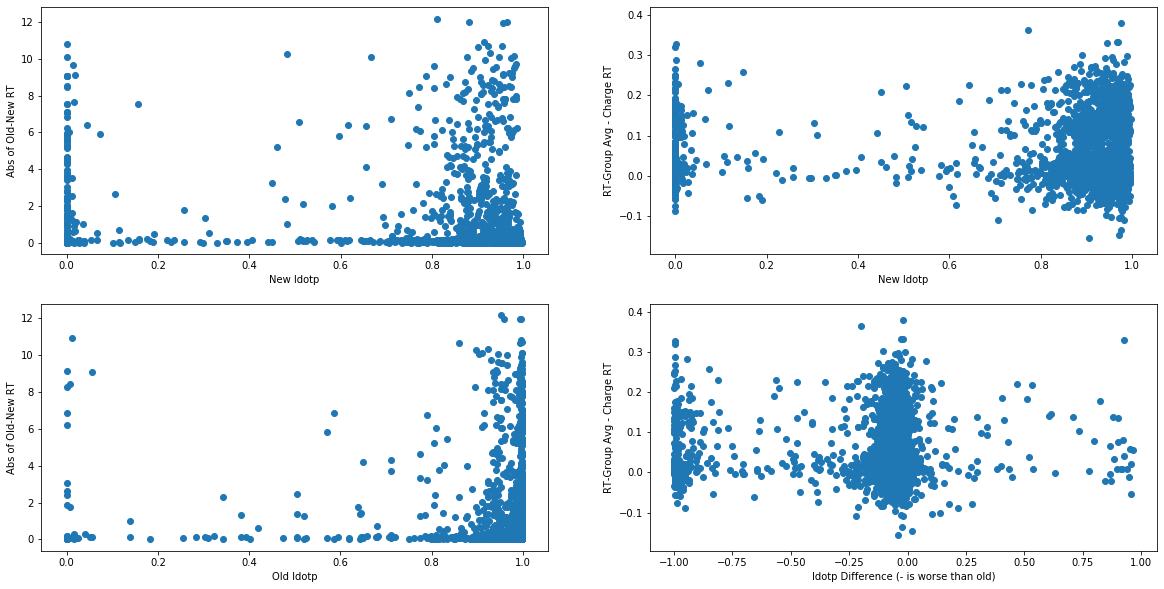

In [106]:
plt.figure(figsize=(20,10))
plt.subplot(2,2,1)
plt.scatter(list(best_charge_matches.sort_values('old_rt_diff')['idotp'].values), list(best_charge_matches.sort_values('old_rt_diff')['old_rt_diff'].values))
plt.xlabel('New Idotp')
plt.ylabel('Abs of Old-New RT')
plt.subplot(2,2,2)
plt.scatter(list(best_charge_matches.sort_values('rt_group_diff')['idotp'].values), list(best_charge_matches.sort_values('rt_group_diff')['rt_group_diff'].values))
plt.xlabel('New Idotp')
plt.ylabel('RT-Group Avg - Charge RT')
plt.subplot(2,2,3)
plt.scatter(list(best_charge_matches.sort_values('old_rt_diff')['fit_to_theo_dist'].values), list(best_charge_matches.sort_values('old_rt_diff')['old_rt_diff'].values))
plt.xlabel('Old Idotp')
plt.ylabel('Abs of Old-New RT')
plt.subplot(2,2,4)
plt.scatter(list(best_charge_matches.sort_values('rt_group_diff')['idotp_diff'].values), list(best_charge_matches.sort_values('rt_group_diff')['rt_group_diff'].values))
plt.xlabel('Idotp Difference (- is worse than old)')
plt.ylabel('RT-Group Avg - Charge RT')
plt.show()
plt.close()

In [18]:
new_names = list(proc_df.sort_values('name')['name'].values)
new_rts = list(proc_df.sort_values('name')['rt'].values)
new_charges = list(proc_df.sort_values('name')['charge'].values)
new_rt_dict = ddict.fromkeys(new_names)
for key in new_rt_dict:
    new_rt_dict[key] = []
for key, value in zip(new_names, new_rts):
    new_rt_dict[key].append(value)

old_undeut_names = [old_df.iloc[i]['name'] for i in np.arange(0,len(old_df),23)]
old_undeut_charges = [list(old_df.iloc[i:i+3]['charge'].values) for i in np.arange(0,len(old_df),23)]
old_undeut_rts = [list(old_df.iloc[i:i+3]['input_RTs'].values) for i in np.arange(0,len(old_df),23)]
old_undeut_intensities = [list(old_df.iloc[i:i+3]['major_species_total_intensity'].values) for i in np.arange(0,len(old_df),23)]

old_rt_dict = ddict.fromkeys(old_undeut_names)
for key, rt, charge, intensity in zip(old_undeut_names, old_undeut_rts, old_undeut_charges, old_undeut_intensity):
    old_rt_dict[key] = pd.DataFrame().from_dict({})

KeyError: 's'

In [11]:
#for each rt-group, finds all old charge rts, pairwise abs diff by index of charge rt in rt-group
comparison_map = ddict.fromkeys(new_rt_dict.keys())
for key in new_rt_dict.keys():
    search_key = '_'.join(key.split('_')[:-1])
    if search_key in old_rt_dict.keys():
        if any([any([abs(rt-new_rt) < 0.1 for rt in old_rt_dict[search_key]]) for new_rt in new_rt_dict[key]]):
            comparison_map.append([[abs(rt-new_rt) for rt in old_rt_dict[search_key]] for new_rt in new_rt_dict[key]])
        else:
            comparison_map.append([[] for rt in new_rt_dict[key]])

In [12]:
comparison_map

[[[0.14868472403606248, 0.1655847840360618, 0.06415150403606162],
  [0.0732606174012771, 0.09016067740127642, 0.011272602598723758],
  [0.027791952009568632, 0.04469201200956796, 0.05674126799043222],
  [0.00650647199376575, 0.010393588006233578, 0.0910396919937666]],
 [[]],
 [[]],
 [[], []],
 [[], [], [], []],
 [[0.07984848265360078, 0.07984848265360078, 0.00493459734639945],
  [0.07201411726408313, 0.07201411726408313, 0.0127689627359171],
  [0.06880162406291657, 0.06880162406291657, 0.015981455937083666]],
 [[]],
 [[0.14434334384622272, 0.14436003384622254, 0.056710213846222324],
  [0.030158882899637085, 0.030175572899636904, 0.05747424710036331],
  [0.0707768734791916, 0.07079356347919141, 0.0168562565208088],
  [0.10243475517820766, 0.10245144517820748, 0.014801625178207267]],
 [[0.008286225012308357, 0.025186285012308574, 0.07649685498769276],
  [0.036366944230747045, 0.05326700423074726, 0.048416135769254076]],
 [[]],
 [[0.1239343887834865, 0.14085113878348654, 0.039150828783486

In [126]:
#all old names are covered (this does not prove all old charges are covered, requires inverse check), some by multiple rt-groups
len(old_rt_dict.keys()), len([x for x in comparison_map if x != [[]]]) 

(868, 1007)

In [158]:
cm = comparison_map

In [153]:
#shows coverage of old charges by rt-difference cutoff
count = 0
for key in old_rt_dict.keys():
    fix_new_keys = ['_'.join(new.split('_')[:-1]) for new in new_rt_dict.keys()]
    if key in fix_new_keys:
        match_keys = [new_key for new_key in new_rt_dict.keys() if key in new_key]
        if any([any([abs(new_rt - old_rt) < 0.01 for new_rt in new_rt_dict[match_key] for old_rt in old_rt_dict[key]]) for match_key in match_keys]):
            count+=1

count/868

In [87]:
count = 0
for name, rt in new_rts:
    search_name = "_".join(name.split("_")[:-1])
    if search_name in old_rt_dict.keys():
        if any([abs(old_rt - rt) < 0.1 for old_rt in old_rt_dict[search_name]]):
            count += 1    

In [52]:
len(old_undeut_rts), len(old_undeut_rts[0])

(2123, 3)

In [34]:
len(new_rts), len(old_rts)/23

(4315, 2123.0)

In [50]:
old_df.columns

Index(['Unnamed: 0', 'output', 'input_RTs', 'input_DTs', 'peak_centroids',
       'integrated_intensities', 'total_intensity', 'centroid',
       'undeut_centroid', 'major_species',
       'major_species_integrated_intensities', 'major_species_median',
       'major_species_total_intensity', 'major_species_centroid',
       'interference_height_ratio', 'interference_integral_ratio',
       'max_interference_integral_ratio', 'name', 'charge',
       'major_species_widths', 'fit_to_theo_dist'],
      dtype='object')

In [49]:
old_df['name', ].values

array(['HEEH_rd2_0682.pdb', 'HEEH_rd2_0682.pdb', 'HEEH_rd2_0682.pdb', ...,
       'HHH_rd2_0018.pdb', 'HHH_rd2_0018.pdb', 'HHH_rd2_0018.pdb'],
      dtype=object)

In [45]:
old_undeut_rts[0][2]

6.82969999

In [ ]:
old_undeut_rts = np.asarray(old_df['input_RTs'].values)

In [ ]:
proc_df['old_rt_diff'] = 

In [23]:
proc_df.sort_values('name')[['idotp'].values

array(['EEHEE_rd1_0123.pdb_6.52278', 'EEHEE_rd1_0229.pdb_4.71485',
       'EEHEE_rd1_0229.pdb_4.71485', ..., 'HHH_rd4_1000.pdb_7.66427',
       'HHH_rd4_1000.pdb_9.04626', 'HHH_rd4_1000.pdb_9.04626'],
      dtype=object)

In [15]:
old_df.columns

Index(['output', 'input_RTs', 'input_DTs', 'peak_centroids',
       'integrated_intensities', 'total_intensity', 'centroid',
       'undeut_centroid', 'major_species',
       'major_species_integrated_intensities', 'major_species_median',
       'major_species_total_intensity', 'major_species_centroid',
       'interference_height_ratio', 'interference_integral_ratio',
       'max_interference_integral_ratio', 'name', 'charge',
       'major_species_widths', 'fit_to_theo_dist'],
      dtype='object')

In [19]:
old_df.sort_values('input_RTs')['input_RTs'].values[0]

4.23701668

In [3]:
alt_lib_info = pd.read_csv("../hdx_pipeline_runs/180604_Mix2_MES_nonlin/data/library_info/library_info.csv")

In [4]:
len(alt_lib_info)

4311

In [5]:
#the only tensor to fail at 16GB
ins = "resources/tensors/852_180604_Mix2_MES_nonlin_UN.mzML.gz.cpickle.zlib, resources/tensors/852_180604_Mix2_MES_nonlin_UN2.mzML.gz.cpickle.zlib, resources/tensors/852_180604_Mix2_MES_nonlin_UN3.mzML.gz.cpickle.zlib".split(', ')

In [12]:
i = int(ins[0].split('/')[-1].split('_')[0])

hd_mass_diff = 1.006277
c13_mass_diff = 1.00335
low_mass_margin = 10
high_mass_margin = 17
ppm_radius = 30

#make hxprot representation per sequence
name = library_info.iloc[i]['name']
charge = library_info.iloc[i]['charge']
seq = library_info.loc[library_info['name'] == name]['sequence'].values[0]
hx_prot = hxtools.hxprot(seq=seq)
dot_products = []

#Compute DataTensor init inputs
max_peak_center = len(seq)
total_isotopes = max_peak_center+high_mass_margin 
total_mass_window = low_mass_margin+total_isotopes
est_peak_gaps = [0] + list(np.linspace(c13_mass_diff, hd_mass_diff, 7)) + [hd_mass_diff for x in range(total_isotopes - 8)]
cum_peak_gaps = np.cumsum(est_peak_gaps)

mz_lows = library_info['obs_mz'].values[i] - (low_mass_margin/library_info['charge'].values[i])
mz_highs = library_info['obs_mz'].values[i] - (total_isotopes/library_info['charge'].values[i])
mz_centers = library_info['obs_mz'].values[i] + (cum_peak_gaps/library_info['charge'].values[i])
low_lims = mz_centers * ((1000000.0 - ppm_radius)/1000000.0)
high_lims = mz_centers * ((1000000.0 + ppm_radius)/1000000.0)



#find rt_group undeut tensors
#undeut_fns = [fn for fn in glob.glob("resources/tensors/"+str(i)+"_*") if "UN" in fn]

print("Debug: Start undeut factorizations")
count = 1
undeut_ics = []
for fn in ins:
    #read mzml 
    print("Loop: "+str(count)+", Debug 1")
    output = hx.limit_read(fn)
    print("Loop: "+str(count)+", Debug 2")
    #make DataTensor
    newDataTensor = hx.DataTensor(
                            source_file = fn,
                            tensor_idx = i,
                            timepoint_idx = 0, 
                            name = name, 
                            total_mass_window = total_mass_window,
                            n_concatenated = 1,
                            charge_states = [library_info["charge"].values[i]], 
                            rts = output[0], 
                            dts= output[1], 
                            seq_out = output[2], 
                            int_seq_out = None
                            )
    print("Loop: "+str(count)+", Debug 3")
    print("Tensor Dims: "+str(np.shape(newDataTensor.full_grid_out)))
    
    newDataTensor.lows = np.searchsorted(newDataTensor.mz_bins, low_lims)
    newDataTensor.highs = np.searchsorted(newDataTensor.mz_bins, high_lims)
    newDataTensor.factorize()
    print("Loop: "+str(count)+", Debug 4")
    #Hacky, clean
    [undeut_ics.append(ic) for i in range(len(newDataTensor.factors)) for ic in newDataTensor.factors[i].isotope_clusters]

    print("Loop: "+str(count)+", Debug 5")
    count += 1

for ic in undeut_ics:
    df = pd.DataFrame(ic.baseline_integrated_mz, columns = ['major_species_integrated_intensities'])
    fit = hx_prot.calculate_isotope_dist(df)
    ic.undeut_ground_dot_product = fit
    dot_products.append((fit, ic.charge_states))

if len(dot_products) > 0:
	best_idotp = max(np.asarray(dot_products)[:,0])
else:
	best_idotp = 0

print("Debug: Loop Complete")

display(pd.DataFrame({'index': [i], 'name': [name], 'charge': [charge], 'idotp': [best_idotp]}))
display(old_c)

Debug: Start undeut factorizations
Loop: 1, Debug 1
Loop: 1, Debug 2
Loop: 1, Debug 3
Tensor Dims: (47, 1, 1224)
Beginning Factorization...
Done: T+20.727168560028076
Loop: 1, Debug 4
Loop: 1, Debug 5
Loop: 2, Debug 1
Loop: 2, Debug 2
Loop: 2, Debug 3
Tensor Dims: (47, 1, 1222)
Beginning Factorization...
Done: T+20.27945566177368
Loop: 2, Debug 4
Loop: 2, Debug 5
Loop: 3, Debug 1
Loop: 3, Debug 2
Loop: 3, Debug 3
Tensor Dims: (47, 1, 1158)
Beginning Factorization...
Done: T+18.483741283416748
Loop: 3, Debug 4
Loop: 3, Debug 5
Debug: Loop Complete


index                            name  charge  idotp
0    852  HHH_rd1_0012.pdb_SPIKE_7.79299     3.0      0

In [7]:
type(newDataTensor.full_grid_out[0][0][0])

numpy.float64

In [8]:
8 * 47000

376000

In [14]:
np.shape(hx.limit_read(big_ins[0]))

(3,)

In [6]:
olds = glob.glob(old_data_dir+"*.pickle")

In [7]:
len(library_info)

4316

In [4]:
idotp_proc = glob.glob("resources/idotp_filter/*")
proc_df = pd.DataFrame()
for fn in idotp_proc:
    proc_df = pd.concat([proc_df, hx.limit_read(fn)])
proc_df = proc_df.sort_values('index')
proc_df['rt'] = library_info.iloc[proc_df['index'].values]['RT'].values

In [6]:
proc_df.columns

Index(['index', 'name', 'charge', 'idotp', 'rt'], dtype='object')

In [ ]:
plt.plot

In [5]:
old_df = old_df.iloc[np.arange(0, len(old_df), 23)]

'HHH_rd4_0891.pdb'

In [36]:
idotp_proc = glob.glob("resources/idotp_filter/*")
proc_df = pd.DataFrame()
for fn in idotp_proc:
    proc_df = pd.concat([proc_df, hx.limit_read(fn)])
proc_df = proc_df.sort_values('index')
proc_df['rt'] = library_info.iloc[proc_df['index'].values]['RT'].values

old_proc_df['name_fix'] = ["_".join(name.split("_")[:-1]) for name in old_proc_df['name'].values]
proc_df['name_fix'] = ["_".join(name.split("_")[:-1]) for name in proc_df['name'].values]
old_df['name_fix'] = old_df['name']

plt.figure(figsize=(18,6))
plt.subplot(1,2,1)
plt.plot(sorted(old_proc_df.sort_values(['name', 'idotp']).drop_duplicates('name')['idotp'].values, reverse = True))
plt.plot(sorted(old_proc_df.sort_values(['name_fix', 'idotp']).drop_duplicates('name_fix')['idotp'].values, reverse = True))
plt.plot(sorted(proc_df.sort_values(['name', 'idotp']).drop_duplicates('name')['idotp'].values, reverse = True))
plt.plot(sorted(proc_df.sort_values(['name_fix', 'idotp']).drop_duplicates('name_fix')['idotp'].values, reverse = True))
plt.plot(sorted(old_df.sort_values(['name', 'fit_to_theo_dist']).drop_duplicates('name')['fit_to_theo_dist'].values, reverse = True))
plt.subplot(1,2,2)
plt.plot(sorted(old_proc_df.sort_values(['name', 'idotp']).drop_duplicates('name')['idotp'].values, reverse = True))
plt.plot(sorted(old_proc_df.sort_values(['name_fix', 'idotp']).drop_duplicates('name_fix')['idotp'].values, reverse = True))
plt.plot(sorted(proc_df.sort_values(['name', 'idotp']).drop_duplicates('name')['idotp'].values, reverse = True))
plt.plot(sorted(proc_df.sort_values(['name_fix', 'idotp']).drop_duplicates('name_fix')['idotp'].values, reverse = True))
plt.plot(sorted(old_df.sort_values(['name', 'fit_to_theo_dist']).drop_duplicates('name')['fit_to_theo_dist'].values, reverse = True))
plt.ylim(0.97,1)

In [88]:
mrg = old_df.merge(proc_df, on='name_fix')

mrg['idotp_diff'] = [x-y for x, y in zip(mrg['idotp'].values, mrg['fit_to_theo_dist'].values)] #negative diff is worse for new

mrg['rt_diff'] = [abs(x-y) for x, y in zip(mrg['input_RTs'].values, mrg['rt'].values)] #higher is worse

mrg = mrg.loc[mrg['charge_x'] == mrg['charge_y']]

mrg = mrg.sort_values(['rt_diff', 'fit_to_theo_dist', 'idotp_diff'], ascending = [True, False, False])

test = mrg.loc[mrg['fit_to_theo_dist'] > 0.99]

test = test.loc[abs(test['idotp_diff']) > .1]

In [96]:
library_info.columns

Index(['Unnamed: 0', 'name', 'RT', 'im_mono', 'ab_cluster_total', 'MW',
       'charge', 'expect_mz', 'obs_mz', 'ppm', 'abs_ppm', 'cluster', 'pred_RT',
       'UN', 'dup', 'sequence', 'idx', 'med_RT', 'RT_0_0', 'RT_0_1', 'RT_0_2',
       'RT_1_0', 'RT_2_0', 'RT_3_0', 'RT_4_0', 'RT_5_0', 'RT_6_0', 'RT_7_0',
       'RT_8_0', 'RT_9_0', 'RT_10_0', 'RT_11_0', 'RT_12_0', 'RT_13_0',
       'RT_14_0', 'RT_15_0', 'RT_16_0', 'RT_17_0', 'RT_18_0', 'RT_19_0',
       'RT_20_0', 'rt_group_mean_RT_0_0', 'rt_group_mean_RT_0_1',
       'rt_group_mean_RT_0_2', 'rt_group_mean_RT_1_0', 'rt_group_mean_RT_2_0',
       'rt_group_mean_RT_3_0', 'rt_group_mean_RT_4_0', 'rt_group_mean_RT_5_0',
       'rt_group_mean_RT_6_0', 'rt_group_mean_RT_7_0', 'rt_group_mean_RT_8_0',
       'rt_group_mean_RT_9_0', 'rt_group_mean_RT_10_0',
       'rt_group_mean_RT_11_0', 'rt_group_mean_RT_12_0',
       'rt_group_mean_RT_13_0', 'rt_group_mean_RT_14_0',
       'rt_group_mean_RT_15_0', 'rt_group_mean_RT_16_0',
       'rt_group_m

In [78]:
test['dt'] = [library_info.iloc[idx]['im_mono'] for idx in test['index'].values]

test['dt_diff'] = [abs(x-y) for x, y in zip(test['dt'], test['input_DTs'])]

test.sort_values(['dt_diff', 'rt_diff', 'fit_to_theo_dist', 'idotp_diff'], ascending = [True, True, False, True])[['dt_diff', 'dt', '' 'rt_diff', 'fit_to_theo_dist', 'idotp_diff']]

test.iloc[0]

mrg[['idotp_diff', 'rt_diff', 'fit_to_theo_dist']].values[:, ]

In [55]:
mrg.iloc[5]

Unnamed: 0                                                                              0
output                                  {'peak_centroids': array([1019.51086267, 1019....
input_RTs                                                                         8.79638
input_DTs                                                                          6.6482
peak_centroids                          [1019.51086267 1019.67808767 1019.84539397 102...
integrated_intensities                  [ 14643   8867  14358  11213  16953  19556  36...
total_intensity                                                                   1434957
centroid                                                                           13.681
undeut_centroid                                                                   5.09343
major_species                           [0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. ...
major_species_integrated_intensities    [     0.      0.      0.      0.  16953.  1955...
major_spec

In [54]:
mrg.head(50)[['rt_diff', 'idotp_diff']]

rt_diff  idotp_diff
6129   0.000276   -0.025707
9838   0.000278    0.006112
7173   0.000284    0.019664
5335   0.000326   -0.017251
6057   0.000859   -0.016555
2937   0.001515    0.795322
3745   0.001668   -0.003039
8185   0.001681   -0.001786
3992   0.001880   -0.003425
8954   0.002122   -0.957711
5476   0.002246   -0.008069
8270   0.002320   -0.003079
3927   0.002558    0.028819
9439   0.002718    0.118237
10857  0.002745    0.023318
6047   0.002802    0.411267
1354   0.002816   -0.003205
6415   0.002921    0.767193
2338   0.002924   -0.004856
8757   0.003156    0.018646
9997   0.003270   -0.003206
5197   0.003419    0.007546
7908   0.003683    0.001639
10713  0.004591   -0.044267
6238   0.004731    0.023532
5050   0.004796   -0.031960
5332   0.004826   -0.002855
7837   0.005055    0.005855
3014   0.005586   -0.004649
2066   0.005684   -0.000991
594    0.005751   -0.005511
3641   0.005806    0.850766
835    0.006087   -0.014852
6362   0.006300   -0.002790
10397  0.006506   -0.010620
3461   0.006556   -0.007917
5554   0.006674    0.937677
3889   0.006745    0.003352
7013   0.006763   -0.004828
7156   0.006791   -0.005064
3485   0.007105   -0.017757
9912   0.007447   -0.004078
3476   0.007712   -0.009964
5958   0.007777   -0.010145
9931   0.007861   -0.002532
481    0.007918    0.000760
9188   0.008056    0.033918
3863   0.008057    0.019575
9707   0.008140    0.028259
128    0.008630   -0.010942

NameError: name 'old_fits' is not defined

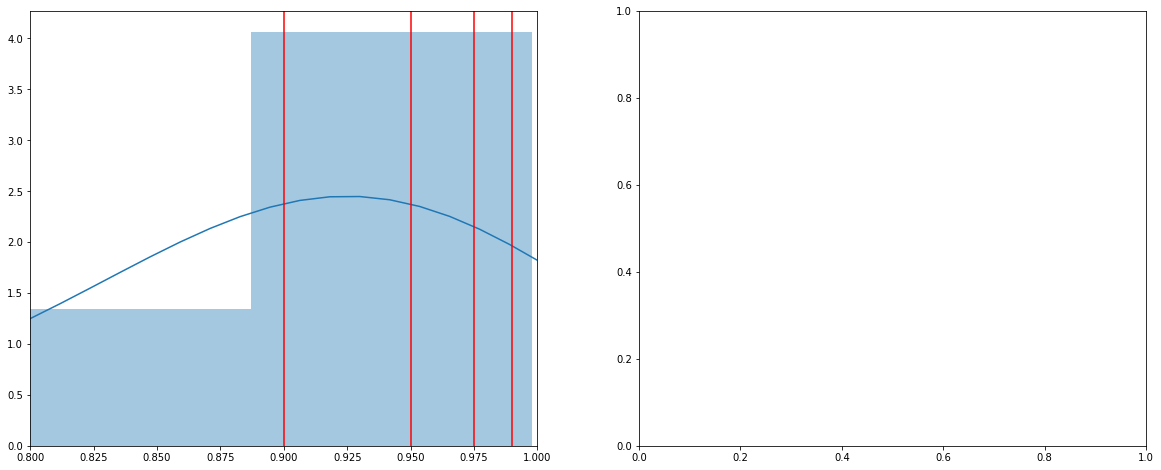

In [8]:
plt.figure(figsize=(20, 8))
plt.subplot(1,2,1)
sns.distplot(proc_df['idotp'].values)
plt.axvline(0.9, color = 'r')
plt.axvline(0.95, color = 'r')
plt.axvline(0.975, color = 'r')
plt.axvline(0.99, color = 'r')
plt.xlim(0.8, 1)
plt.subplot(1,2,2)
sns.distplot(old_fits)
plt.axvline(0.9, color = 'r')
plt.axvline(0.95, color = 'r')
plt.axvline(0.975, color = 'r')
plt.axvline(0.99, color = 'r')
plt.xlim(0.8, 1)
plt.show()
plt.close()

In [41]:
99268 / 4316

23.0

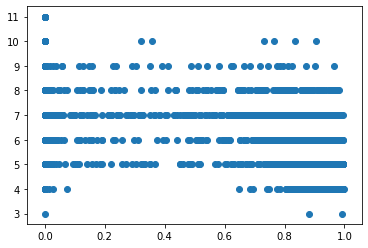

In [105]:
plt.scatter(proc_df['idotp'].values, proc_df['charge'].values)

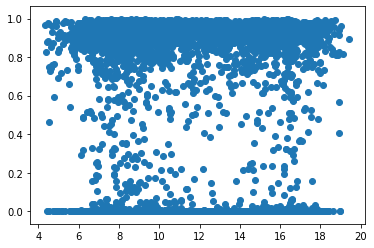

In [106]:
plt.scatter(list(proc_df['rt']), list(proc_df['idotp'].values))

In [120]:
old_fits = list(old_df['fit_to_theo_dist'].values)[::23]

In [150]:
old_rts = list(old_df['input_RTs'].values)[::23]

In [157]:
new_fits = list(proc_df['idotp'].values)

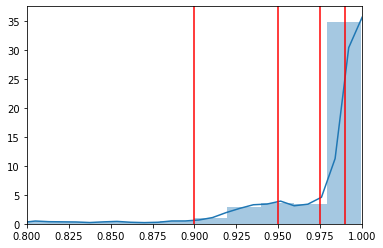

In [134]:
plt.figure()
sns.distplot(old_fits)
plt.axvline(0.9, color = 'r')
plt.axvline(0.95, color = 'r')
plt.axvline(0.975, color = 'r')
plt.axvline(0.99, color = 'r')
plt.xlim(0.8, 1)
plt.show()
plt.close()

In [158]:
[len([x for x in new_fits if x > y]) for y in [0.9, 0.925, 0.95, 0.975, 0.99]]

[1801, 1386, 900, 313, 82]

In [136]:
[len([x for x in old_fits if x > y]) for y in [0.9, 0.925, 0.95, 0.975, 0.99]]

[1942, 1872, 1703, 1519, 1304]

In [144]:
rt_bins = []
for i,j in zip(range(4, 20), range(5, 21)):
    subdf = proc_df.loc[(proc_df['rt'] > i) & (proc_df['rt'] < j)]
    rt_bins.append(list(subdf.sort_values('rt')['idotp'].values))

In [145]:
len(rt_bins), len(range(4,21))

(16, 17)

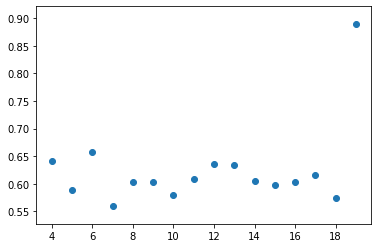

In [146]:
plt.scatter(range(4,20), [np.mean(rt) for rt in rt_bins])

In [ ]:
rt_bins = []
for i,j in zip(range(4, 20), range(5, 21)):

In [74]:
len(procdf.loc[procdf['idotp'] > 0.99])

72

In [48]:
proc_df.columns

Index(['index', 'name', 'charge', 'idotp'], dtype='object')

In [47]:
procdf = proc_df

In [36]:
library_info.columns

Index(['Unnamed: 0', 'name', 'RT', 'im_mono', 'ab_cluster_total', 'MW',
       'charge', 'expect_mz', 'obs_mz', 'ppm', 'abs_ppm', 'cluster', 'pred_RT',
       'UN', 'dup', 'sequence', 'idx', 'med_RT', 'RT_0_0', 'RT_0_1', 'RT_0_2',
       'RT_1_0', 'RT_2_0', 'RT_3_0', 'RT_4_0', 'RT_5_0', 'RT_6_0', 'RT_7_0',
       'RT_8_0', 'RT_9_0', 'RT_10_0', 'RT_11_0', 'RT_12_0', 'RT_13_0',
       'RT_14_0', 'RT_15_0', 'RT_16_0', 'RT_17_0', 'RT_18_0', 'RT_19_0',
       'RT_20_0', 'rt_group_mean_RT_0_0', 'rt_group_mean_RT_0_1',
       'rt_group_mean_RT_0_2', 'rt_group_mean_RT_1_0', 'rt_group_mean_RT_2_0',
       'rt_group_mean_RT_3_0', 'rt_group_mean_RT_4_0', 'rt_group_mean_RT_5_0',
       'rt_group_mean_RT_6_0', 'rt_group_mean_RT_7_0', 'rt_group_mean_RT_8_0',
       'rt_group_mean_RT_9_0', 'rt_group_mean_RT_10_0',
       'rt_group_mean_RT_11_0', 'rt_group_mean_RT_12_0',
       'rt_group_mean_RT_13_0', 'rt_group_mean_RT_14_0',
       'rt_group_mean_RT_15_0', 'rt_group_mean_RT_16_0',
       'rt_group_m

In [39]:
catdf['ab_cluster_total'].values[0]

46875.0

In [45]:
print(library_info.iloc[0].to_dict())

{'Unnamed: 0': 0, 'name': 'HHH_rd4_0891.pdb_4.33802', 'RT': 4.349177838693458, 'im_mono': 118.2256557181065, 'ab_cluster_total': 207025.7, 'MW': 5649.89215, 'charge': 5.0, 'expect_mz': 1130.9857, 'obs_mz': 1130.9862005079565, 'ppm': 0.4, 'abs_ppm': 0.4425411699315873, 'cluster': 139, 'pred_RT': 4.338017964071857, 'UN': 0, 'dup': False, 'sequence': 'HMDEEELLKDALRAYKEGDEDRLEEIVRRLNVDKKQVVDRAQRLEGSG', 'idx': 4173, 'med_RT': 4.338017964071857, 'RT_0_0': 4.3210818363273455, 'RT_0_1': 4.270273453093812, 'RT_0_2': 4.4057624750499, 'RT_1_0': 4.253337325349301, 'RT_2_0': 4.2025289421157686, 'RT_3_0': 4.23640119760479, 'RT_4_0': 4.168656686626747, 'RT_5_0': 4.23640119760479, 'RT_6_0': 4.3210818363273455, 'RT_7_0': 4.3210818363273455, 'RT_8_0': 4.388826347305389, 'RT_9_0': 4.185592814371256, 'RT_10_0': 4.185592814371256, 'RT_11_0': 4.270273453093812, 'RT_12_0': 4.3210818363273455, 'RT_13_0': 4.338017964071857, 'RT_14_0': 4.168656686626747, 'RT_15_0': 4.168656686626747, 'RT_16_0': 4.21946506986027

In [40]:
catdf.iloc[0]

name                EEHEE_rd1_0123.pdb
RT                             6.63273
im_mono                        81.9736
ab_cluster_total                 46875
MW                             4782.25
charge                               6
expect_mz                       798.05
obs_mz                         798.051
ppm                                1.4
abs_ppm                         1.3782
cluster                           3631
Name: 0, dtype: object

In [13]:
catdf.columns

Index(['name', 'RT', 'im_mono', 'ab_cluster_total', 'MW', 'charge',
       'expect_mz', 'obs_mz', 'ppm', 'abs_ppm', 'cluster'],
      dtype='object')

In [38]:
catdf = pd.concat([pd.read_csv(fn) for fn in sorted(glob.glob("resources/library_info/*_intermediate.csv"))])
catdf = catdf.sort_values(['name','charge','RT'])
catdf.index = range(len(catdf))

In [12]:
catdf

name        RT     im_mono  ab_cluster_total           MW  \
0     EEHEE_rd1_0123.pdb  6.632732   81.973595           46875.0  4782.253953   
1     EEHEE_rd1_0229.pdb  4.703894  109.573928          378912.8  5533.640409   
2     EEHEE_rd1_0229.pdb  4.840902  109.184688          343546.9  5533.640409   
3     EEHEE_rd1_0229.pdb  4.738192   97.353775          908463.6  5533.640409   
4     EEHEE_rd1_0229.pdb  4.860805   97.322173         1021822.2  5533.640409   
...                  ...       ...         ...               ...          ...   
7143    HHH_rd4_1000.pdb  9.249983   93.823296          120403.3  5313.821553   
7144    HHH_rd4_1000.pdb  7.671762   94.046766          910568.3  5313.821553   
7145    HHH_rd4_1000.pdb  7.682615   94.176751          523660.4  5313.821553   
7146    HHH_rd4_1000.pdb  7.812090   79.056210          830990.4  5313.821553   
7147    HHH_rd4_1000.pdb  7.792346   73.148947          273120.9  5313.821553   

      charge    expect_mz       obs_mz  ppm   abs_ppm  cluster  
0        6.0   798.049596   798.050695  1.4  1.378199     3631  
1        4.0  1384.417372  1384.410288 -5.1  5.116900     1141  
2        4.0  1384.417372  1384.424161  4.9  4.903972     1214  
3        6.0   923.280672   923.278534 -2.3  2.315316      350  
4        6.0   923.280672   923.279136 -1.7  1.662935     1183  
...      ...          ...          ...  ...       ...      ...  
7143     5.0  1063.771581  1063.776613  4.7  4.730592     7349  
7144     6.0   886.644196   886.639732 -5.0  5.034662     2192  
7145     6.0   886.644196   886.642273 -2.2  2.167789     5070  
7146     7.0   760.124635   760.122631 -2.6  2.635464     5048  
7147     8.0   665.234964   665.231393 -5.4  5.368119     5197  

[7148 rows x 11 columns]

In [4]:
hd_mass_diff = 1.006277
c13_mass_diff = 1.00335
low_mass_margin = 10
high_mass_margin = 17
ppm_radius = 30

In [5]:
olds =  glob.glob(old_data_dir+"*.pickle")

In [10]:
olds[0].split('/')[-1].split('_')[4:7]

['HEEH', 'rd2', '0682.pdb']

In [9]:
#make df of all old data
old_df = pd.DataFrame()
for fn in glob.glob(old_data_dir+"*.pickle"):
    #make hxprot representation per sequence
    ts = pickle.load(open(fn, 'rb'))
    name =  '_'.join(fn.split('/')[-1].split('_')[4:7])
    ts['name'] = name
    ts['charge'] = int(fn.split('.')[-3][-1])
    ts['major_species_widths'] = [len(np.nonzero(x)[0]) for x in ts['major_species_integrated_intensities']]
    seq = names_and_seqs[names_and_seqs['name'].str.contains(name)]['sequence'].values[0]
    hx_prot = hxtools.hxprot(seq=seq)
    #Test fits to undeut
    undeut_amds = [{'major_species_integrated_intensities': ts['major_species_integrated_intensities'][i]} for i in range(3)]  
    ts['fit_to_theo_dist'] = max([hx_prot.calculate_isotope_dist(d) for d in undeut_amds])
    old_df = pd.concat([old_df, pd.DataFrame.from_dict(ts)])

In [20]:
len(old_df)/23

2123.0

In [25]:
old_df['charge'].values

array([5, 5, 5, ..., 5, 5, 5])

In [26]:
old_df.to_csv('resources/library_info/old_master_df.csv')

In [5]:
old_df = pd.read_csv('resources/library_info/old_master_df.csv')

In [17]:
%debug

> <ipython-input-16-b7d57ff6d3cf>(10)<module>()
      8     ts['charge'] = int(fn.split('.')[-3][-1])
      9     ts['major_species_widths'] = [len(np.nonzero(x)[0]) for x in ts['major_species_integrated_intensities']]
---> 10     seq = names_and_seqs.loc[names_and_seqs['name'] == name]['sequence'].values[0]
     11     hx_prot = hxtools.hxprot(seq=seq)
     12     #Test fits to undeut



ipdb>  name


'HHH_rd1_0012.pdb'


ipdb>  names_and_seqs['name'].str.contains('rd1_0012')


0       False
1       False
2       False
3       False
4       False
        ...  
1319    False
1320    False
1321    False
1322    False
1323     True
Name: name, Length: 1324, dtype: bool


ipdb>  names_and_seqs[names_and_seqs['name'].str.contains('rd1_0012')]


      Unnamed: 0                    name  \
1323        1323  HHH_rd1_0012.pdb_SPIKE   

                                          raw_seq  \
1323  PEEDIKRKAKELLKEGNKEKAKRLLEKAGFSPDEAEQILNEIS   

                                             sequence  
1323  GSHMPEEDIKRKAKELLKEGNKEKAKRLLEKAGFSPDEAEQILNEIS  


ipdb>  quit


In [35]:
#open undeuterated files for each charge in master list and determine idotp
new_df = {}
old_df = {}
for i in range(len(library_info))[:1]:
    #make hxprot representation per sequence
    name = library_info.iloc[i]['name']
    charge = library_info.iloc[i]['charge']
    seq = library_info.loc[library_info['name'] == name]['sequence'].values[0]
    hx_prot = hxtools.hxprot(seq=seq)
    dot_products = []
    
    #Compute DataTensor init inputs
    max_peak_center = len(seq)
    total_isotopes = max_peak_center+high_mass_margin 
    total_mass_window = low_mass_margin+total_isotopes
    est_peak_gaps = [0] + list(np.linspace(c13_mass_diff, hd_mass_diff, 7)) + [hd_mass_diff for x in range(total_isotopes - 8)]
    cum_peak_gaps = np.cumsum(est_peak_gaps)
    
    mz_lows = library_info['obs_mz'].values[i] - (low_mass_margin/library_info['charge'].values[i])
    mz_highs = library_info['obs_mz'].values[i] - (total_isotopes/library_info['charge'].values[i])
    mz_centers = library_info['obs_mz'].values[i] + (cum_peak_gaps/library_info['charge'].values[i])
    low_lims = mz_centers * ((1000000.0 - ppm_radius)/1000000.0)
    high_lims = mz_centers * ((1000000.0 + ppm_radius)/1000000.0)
    
    #find rt_group undeut tensors
    undeut_fns = [fn for fn in glob.glob("resources/tensors/"+str(i)+"_*") if "UN" in fn]
    
    #test old undeut idotps
    #Find old files for charge, redundant, saves all old charges with same name regardless of RT
    old_files = sorted([fn for fn in glob.iglob(old_data_dir+"*.pickle") if "_".join(name.split("/")[-1].split("_")[:3]) in fn]) #hardcode 3 for undeut idxs
    print(len(old_files))
    if len(old_files) > 0:
        #Collect relevant values
        old_df[name] = []
        old_data = []
        for fn in old_files:
            ts = pickle.load(open(fn, 'rb'))
            ts['name'] = fn.split('/')[-1]
            ts['charge'] = int(fn.split('.')[-3][-1])
            ts['major_species_widths'] = [len(np.nonzero(x)[0]) for x in ts['major_species_integrated_intensities']]
            old_data.append(ts)

        #Test fits to undeut
        for charge_dict in old_data:
            undeut_amds = [{'major_species_integrated_intensities': charge_dict['major_species_integrated_intensities'][i]} for i in range(3)]  
            charge_dict['fit_to_theo_dist'] = max([hx_prot.calculate_isotope_dist(d) for d in undeut_amds])
            old_df[name].append(pd.DataFrame.from_dict(charge_dict))
    else:
        old_df[name].append(pd.DataFrame())
        
    #start new undeut
    undeut_ics = []
    for fn in undeut_fns:
        #read mzml 
        output = hx.limit_read(fn)
    
        #make DataTensor
        newDataTensor = hx.DataTensor(
                                source_file = fn,
                                tensor_idx = i,
                                timepoint_idx = 0, 
                                name = name, 
                                total_mass_window = total_mass_window,
                                n_concatenated = 1,
                                charge_states = [library_info["charge"].values[i]], 
                                rts = output[0], 
                                dts= output[1], 
                                seq_out = output[2], 
                                int_seq_out = None
                                )
        
        newDataTensor.lows = np.searchsorted(newDataTensor.mz_bins, low_lims)
        newDataTensor.highs = np.searchsorted(newDataTensor.mz_bins, high_lims)
        newDataTensor.factorize()
        #Hacky, clean
        [undeut_ics.append(ic) for i in range(len(newDataTensor.factors)) for ic in newDataTensor.factors[i].isotope_clusters]
    
    for ic in undeut_ics:
        df = pd.DataFrame(ic.baseline_integrated_mz, columns = ['major_species_integrated_intensities'])
        fit = hx_prot.calculate_isotope_dist(df)
        ic.undeut_ground_dot_product = fit
        dot_products.append((fit, ic.charge_states))
    
    if len(dot_products) > 0:
        best_idotp = max(np.asarray(dot_products)[:,0])
    else: 
        best_idotp = 0
    
    print("I: "+str(i)+", Max charge idotp: "+str(best_idotp))

    new_df[name] = pd.DataFrame.from_dict({'index': [i], 'name': [name], 'charge': [charge], 'idotp': [best_idotp]})
    print(old_df[name][0].keys())
    display(new_df[name])
    [display(df[['name','charge','fit_to_theo_dist', 'major_species_total_intensity']]) for df in old_df[name]]
    print(name+" idotp: "+str(best_idotp))
    print("Old idotps: "+str(old_df[name]['idotp'].values))
    

4
Beginning Factorization...
Done: T+6.057860612869263
Beginning Factorization...
Done: T+9.182021617889404
Beginning Factorization...
Done: T+9.717897653579712
I: 0, Max charge idotp: 0.964640663799057
Index(['output', 'input_RTs', 'input_DTs', 'peak_centroids',
       'integrated_intensities', 'total_intensity', 'centroid',
       'undeut_centroid', 'major_species',
       'major_species_integrated_intensities', 'major_species_median',
       'major_species_total_intensity', 'major_species_centroid',
       'interference_height_ratio', 'interference_integral_ratio',
       'max_interference_integral_ratio', 'name', 'charge',
       'major_species_widths', 'fit_to_theo_dist'],
      dtype='object')


index                      name  charge     idotp
0      0  HHH_rd4_0891.pdb_4.33802     5.0  0.964641

name  charge  fit_to_theo_dist  \
0   mix2_MES_n_2109_HHH_rd4_0891.pdb_z5.0.pickle       5          0.958226   
1   mix2_MES_n_2109_HHH_rd4_0891.pdb_z5.0.pickle       5          0.958226   
2   mix2_MES_n_2109_HHH_rd4_0891.pdb_z5.0.pickle       5          0.958226   
3   mix2_MES_n_2109_HHH_rd4_0891.pdb_z5.0.pickle       5          0.958226   
4   mix2_MES_n_2109_HHH_rd4_0891.pdb_z5.0.pickle       5          0.958226   
5   mix2_MES_n_2109_HHH_rd4_0891.pdb_z5.0.pickle       5          0.958226   
6   mix2_MES_n_2109_HHH_rd4_0891.pdb_z5.0.pickle       5          0.958226   
7   mix2_MES_n_2109_HHH_rd4_0891.pdb_z5.0.pickle       5          0.958226   
8   mix2_MES_n_2109_HHH_rd4_0891.pdb_z5.0.pickle       5          0.958226   
9   mix2_MES_n_2109_HHH_rd4_0891.pdb_z5.0.pickle       5          0.958226   
10  mix2_MES_n_2109_HHH_rd4_0891.pdb_z5.0.pickle       5          0.958226   
11  mix2_MES_n_2109_HHH_rd4_0891.pdb_z5.0.pickle       5          0.958226   
12  mix2_MES_n_2109_HHH_rd4_0891.pdb_z5.0.pickle       5          0.958226   
13  mix2_MES_n_2109_HHH_rd4_0891.pdb_z5.0.pickle       5          0.958226   
14  mix2_MES_n_2109_HHH_rd4_0891.pdb_z5.0.pickle       5          0.958226   
15  mix2_MES_n_2109_HHH_rd4_0891.pdb_z5.0.pickle       5          0.958226   
16  mix2_MES_n_2109_HHH_rd4_0891.pdb_z5.0.pickle       5          0.958226   
17  mix2_MES_n_2109_HHH_rd4_0891.pdb_z5.0.pickle       5          0.958226   
18  mix2_MES_n_2109_HHH_rd4_0891.pdb_z5.0.pickle       5          0.958226   
19  mix2_MES_n_2109_HHH_rd4_0891.pdb_z5.0.pickle       5          0.958226   
20  mix2_MES_n_2109_HHH_rd4_0891.pdb_z5.0.pickle       5          0.958226   
21  mix2_MES_n_2109_HHH_rd4_0891.pdb_z5.0.pickle       5          0.958226   
22  mix2_MES_n_2109_HHH_rd4_0891.pdb_z5.0.pickle       5          0.958226   

    major_species_total_intensity  
0                        548749.0  
1                        519414.0  
2                        514767.0  
3                        494020.0  
4                        489827.0  
5                        458503.0  
6                        509959.0  
7                        414326.0  
8                        439609.0  
9                        487465.0  
10                       486179.0  
11                       461870.0  
12                       515894.0  
13                       445371.0  
14                       544945.0  
15                       504959.0  
16                       475994.0  
17                       512564.0  
18                       473908.0  
19                       445865.0  
20                       428805.0  
21                       415728.0  
22                       449639.0

name  charge  fit_to_theo_dist  \
0   mix2_MES_n_2110_HHH_rd4_0891.pdb_z5.0.pickle       5          0.721479   
1   mix2_MES_n_2110_HHH_rd4_0891.pdb_z5.0.pickle       5          0.721479   
2   mix2_MES_n_2110_HHH_rd4_0891.pdb_z5.0.pickle       5          0.721479   
3   mix2_MES_n_2110_HHH_rd4_0891.pdb_z5.0.pickle       5          0.721479   
4   mix2_MES_n_2110_HHH_rd4_0891.pdb_z5.0.pickle       5          0.721479   
5   mix2_MES_n_2110_HHH_rd4_0891.pdb_z5.0.pickle       5          0.721479   
6   mix2_MES_n_2110_HHH_rd4_0891.pdb_z5.0.pickle       5          0.721479   
7   mix2_MES_n_2110_HHH_rd4_0891.pdb_z5.0.pickle       5          0.721479   
8   mix2_MES_n_2110_HHH_rd4_0891.pdb_z5.0.pickle       5          0.721479   
9   mix2_MES_n_2110_HHH_rd4_0891.pdb_z5.0.pickle       5          0.721479   
10  mix2_MES_n_2110_HHH_rd4_0891.pdb_z5.0.pickle       5          0.721479   
11  mix2_MES_n_2110_HHH_rd4_0891.pdb_z5.0.pickle       5          0.721479   
12  mix2_MES_n_2110_HHH_rd4_0891.pdb_z5.0.pickle       5          0.721479   
13  mix2_MES_n_2110_HHH_rd4_0891.pdb_z5.0.pickle       5          0.721479   
14  mix2_MES_n_2110_HHH_rd4_0891.pdb_z5.0.pickle       5          0.721479   
15  mix2_MES_n_2110_HHH_rd4_0891.pdb_z5.0.pickle       5          0.721479   
16  mix2_MES_n_2110_HHH_rd4_0891.pdb_z5.0.pickle       5          0.721479   
17  mix2_MES_n_2110_HHH_rd4_0891.pdb_z5.0.pickle       5          0.721479   
18  mix2_MES_n_2110_HHH_rd4_0891.pdb_z5.0.pickle       5          0.721479   
19  mix2_MES_n_2110_HHH_rd4_0891.pdb_z5.0.pickle       5          0.721479   
20  mix2_MES_n_2110_HHH_rd4_0891.pdb_z5.0.pickle       5          0.721479   
21  mix2_MES_n_2110_HHH_rd4_0891.pdb_z5.0.pickle       5          0.721479   
22  mix2_MES_n_2110_HHH_rd4_0891.pdb_z5.0.pickle       5          0.721479   

    major_species_total_intensity  
0                       1073172.0  
1                       1036325.0  
2                        934096.0  
3                        787852.0  
4                        755114.0  
5                        787197.0  
6                        806839.0  
7                        662333.0  
8                        773966.0  
9                        814297.0  
10                       754213.0  
11                       806302.0  
12                       903744.0  
13                       806507.0  
14                       731900.0  
15                       723188.0  
16                       720179.0  
17                       707931.0  
18                       798194.0  
19                       680983.0  
20                       748411.0  
21                       818986.0  
22                       777756.0

name  charge  fit_to_theo_dist  \
0   mix2_MES_n_2111_HHH_rd4_0891.pdb_z5.0.pickle       5          0.997902   
1   mix2_MES_n_2111_HHH_rd4_0891.pdb_z5.0.pickle       5          0.997902   
2   mix2_MES_n_2111_HHH_rd4_0891.pdb_z5.0.pickle       5          0.997902   
3   mix2_MES_n_2111_HHH_rd4_0891.pdb_z5.0.pickle       5          0.997902   
4   mix2_MES_n_2111_HHH_rd4_0891.pdb_z5.0.pickle       5          0.997902   
5   mix2_MES_n_2111_HHH_rd4_0891.pdb_z5.0.pickle       5          0.997902   
6   mix2_MES_n_2111_HHH_rd4_0891.pdb_z5.0.pickle       5          0.997902   
7   mix2_MES_n_2111_HHH_rd4_0891.pdb_z5.0.pickle       5          0.997902   
8   mix2_MES_n_2111_HHH_rd4_0891.pdb_z5.0.pickle       5          0.997902   
9   mix2_MES_n_2111_HHH_rd4_0891.pdb_z5.0.pickle       5          0.997902   
10  mix2_MES_n_2111_HHH_rd4_0891.pdb_z5.0.pickle       5          0.997902   
11  mix2_MES_n_2111_HHH_rd4_0891.pdb_z5.0.pickle       5          0.997902   
12  mix2_MES_n_2111_HHH_rd4_0891.pdb_z5.0.pickle       5          0.997902   
13  mix2_MES_n_2111_HHH_rd4_0891.pdb_z5.0.pickle       5          0.997902   
14  mix2_MES_n_2111_HHH_rd4_0891.pdb_z5.0.pickle       5          0.997902   
15  mix2_MES_n_2111_HHH_rd4_0891.pdb_z5.0.pickle       5          0.997902   
16  mix2_MES_n_2111_HHH_rd4_0891.pdb_z5.0.pickle       5          0.997902   
17  mix2_MES_n_2111_HHH_rd4_0891.pdb_z5.0.pickle       5          0.997902   
18  mix2_MES_n_2111_HHH_rd4_0891.pdb_z5.0.pickle       5          0.997902   
19  mix2_MES_n_2111_HHH_rd4_0891.pdb_z5.0.pickle       5          0.997902   
20  mix2_MES_n_2111_HHH_rd4_0891.pdb_z5.0.pickle       5          0.997902   
21  mix2_MES_n_2111_HHH_rd4_0891.pdb_z5.0.pickle       5          0.997902   
22  mix2_MES_n_2111_HHH_rd4_0891.pdb_z5.0.pickle       5          0.997902   

    major_species_total_intensity  
0                       3793094.0  
1                       3047148.0  
2                       3135836.0  
3                       3171420.0  
4                       3152626.0  
5                       2733075.0  
6                       3092616.0  
7                       1808749.0  
8                       2227351.0  
9                       2735052.0  
10                      2500060.0  
11                      2301090.0  
12                      3006064.0  
13                      2844425.0  
14                      2346267.0  
15                      2260818.0  
16                      2032844.0  
17                      1773220.0  
18                      2370232.0  
19                      2721398.0  
20                      2636194.0  
21                      2604166.0  
22                      2165907.0

name  charge  fit_to_theo_dist  \
0   mix2_MES_n_2112_HHH_rd4_0891.pdb_z6.0.pickle       6          0.961556   
1   mix2_MES_n_2112_HHH_rd4_0891.pdb_z6.0.pickle       6          0.961556   
2   mix2_MES_n_2112_HHH_rd4_0891.pdb_z6.0.pickle       6          0.961556   
3   mix2_MES_n_2112_HHH_rd4_0891.pdb_z6.0.pickle       6          0.961556   
4   mix2_MES_n_2112_HHH_rd4_0891.pdb_z6.0.pickle       6          0.961556   
5   mix2_MES_n_2112_HHH_rd4_0891.pdb_z6.0.pickle       6          0.961556   
6   mix2_MES_n_2112_HHH_rd4_0891.pdb_z6.0.pickle       6          0.961556   
7   mix2_MES_n_2112_HHH_rd4_0891.pdb_z6.0.pickle       6          0.961556   
8   mix2_MES_n_2112_HHH_rd4_0891.pdb_z6.0.pickle       6          0.961556   
9   mix2_MES_n_2112_HHH_rd4_0891.pdb_z6.0.pickle       6          0.961556   
10  mix2_MES_n_2112_HHH_rd4_0891.pdb_z6.0.pickle       6          0.961556   
11  mix2_MES_n_2112_HHH_rd4_0891.pdb_z6.0.pickle       6          0.961556   
12  mix2_MES_n_2112_HHH_rd4_0891.pdb_z6.0.pickle       6          0.961556   
13  mix2_MES_n_2112_HHH_rd4_0891.pdb_z6.0.pickle       6          0.961556   
14  mix2_MES_n_2112_HHH_rd4_0891.pdb_z6.0.pickle       6          0.961556   
15  mix2_MES_n_2112_HHH_rd4_0891.pdb_z6.0.pickle       6          0.961556   
16  mix2_MES_n_2112_HHH_rd4_0891.pdb_z6.0.pickle       6          0.961556   
17  mix2_MES_n_2112_HHH_rd4_0891.pdb_z6.0.pickle       6          0.961556   
18  mix2_MES_n_2112_HHH_rd4_0891.pdb_z6.0.pickle       6          0.961556   
19  mix2_MES_n_2112_HHH_rd4_0891.pdb_z6.0.pickle       6          0.961556   
20  mix2_MES_n_2112_HHH_rd4_0891.pdb_z6.0.pickle       6          0.961556   
21  mix2_MES_n_2112_HHH_rd4_0891.pdb_z6.0.pickle       6          0.961556   
22  mix2_MES_n_2112_HHH_rd4_0891.pdb_z6.0.pickle       6          0.961556   

    major_species_total_intensity  
0                       2282360.0  
1                       2182206.0  
2                       1780429.0  
3                       1713988.0  
4                       1851393.0  
5                       1589661.0  
6                       1858508.0  
7                       1291103.0  
8                       1376120.0  
9                       1713409.0  
10                      1600225.0  
11                      1475079.0  
12                      1745590.0  
13                      1686643.0  
14                      1540226.0  
15                      1399979.0  
16                      1320229.0  
17                      1241763.0  
18                      1508728.0  
19                      1493894.0  
20                      1551986.0  
21                      1500862.0  
22                      1380828.0

HHH_rd4_0891.pdb_4.33802 idotp: 0.964640663799057


TypeError: list indices must be integers or slices, not str

In [2]:
proc_files = glob.glob("resources/ic_time_series/*.cpickle.zlib")

In [3]:
proc_files[0].split('/')[-1].split('all')[0][:-1]

'HHH_rd2_0215.pdb_6.73279'

In [ ]:
for 

In [4]:
names = [fn.split('/')[-1].split('all')[0][:-1] for fn in proc_files]
for fn in proc_files:
    
    name = fn.split('/')[-1].split('all')[0][:-1]
    
    all_tp_clusters = hx.limit_read(fn)

    po = hx.PathOptimizer(name, all_tp_clusters, library_info, timepoints, n_undeut_runs = 3, old_data_dir = "resources/old_data/")

    po.optimize_paths()

    source_frame, old_df = po.bokeh_plot("results/plots/"+name+"_time_series.html")

/projects/p30802/wes/hdx_analysis/HDX_LIMIT-Pipeline/workflow/scripts/auxiliary/LC_IM_MS_TensorAnalysis.py:1995: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  old_df = pd.concat([ts_df, ic_df])


internal n_timepoints: 21


ERROR:bokeh.core.validation.check:E-1024 (CDSVIEW_FILTERS_WITH_CONNECTED): CDSView filters are not compatible with glyphs with connected topology suchs as Line and Patch: GlyphRenderer(id=3753, glyph=Line(id='3751', ...), ...)
ERROR:bokeh.core.validation.check:E-1024 (CDSVIEW_FILTERS_WITH_CONNECTED): CDSView filters are not compatible with glyphs with connected topology suchs as Line and Patch: GlyphRenderer(id=3762, glyph=Line(id='3759', ...), ...)
/home/rwl0960/.conda/envs/dask_lab/lib/python3.7/site-packages/numpy/lib/function_base.py:390: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
/home/rwl0960/.conda/envs/dask_lab/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/rwl0960/.local/lib/python3.7/site-packages/scipy/stats/stats.py:333: RuntimeWarning: Mean of empty slice.
  return np.exp(log_a.mean(axis=axis))


internal n_timepoints: 21


ERROR:bokeh.core.validation.check:E-1024 (CDSVIEW_FILTERS_WITH_CONNECTED): CDSView filters are not compatible with glyphs with connected topology suchs as Line and Patch: GlyphRenderer(id=11526, glyph=Line(id='11524', ...), ...)
ERROR:bokeh.core.validation.check:E-1024 (CDSVIEW_FILTERS_WITH_CONNECTED): CDSView filters are not compatible with glyphs with connected topology suchs as Line and Patch: GlyphRenderer(id=11535, glyph=Line(id='11532', ...), ...)


internal n_timepoints: 21


ERROR:bokeh.core.validation.check:E-1024 (CDSVIEW_FILTERS_WITH_CONNECTED): CDSView filters are not compatible with glyphs with connected topology suchs as Line and Patch: GlyphRenderer(id=19299, glyph=Line(id='19297', ...), ...)
ERROR:bokeh.core.validation.check:E-1024 (CDSVIEW_FILTERS_WITH_CONNECTED): CDSView filters are not compatible with glyphs with connected topology suchs as Line and Patch: GlyphRenderer(id=19308, glyph=Line(id='19305', ...), ...)


internal n_timepoints: 21


ERROR:bokeh.core.validation.check:E-1024 (CDSVIEW_FILTERS_WITH_CONNECTED): CDSView filters are not compatible with glyphs with connected topology suchs as Line and Patch: GlyphRenderer(id=27072, glyph=Line(id='27070', ...), ...)
ERROR:bokeh.core.validation.check:E-1024 (CDSVIEW_FILTERS_WITH_CONNECTED): CDSView filters are not compatible with glyphs with connected topology suchs as Line and Patch: GlyphRenderer(id=27081, glyph=Line(id='27078', ...), ...)


internal n_timepoints: 21


ERROR:bokeh.core.validation.check:E-1024 (CDSVIEW_FILTERS_WITH_CONNECTED): CDSView filters are not compatible with glyphs with connected topology suchs as Line and Patch: GlyphRenderer(id=34845, glyph=Line(id='34843', ...), ...)
ERROR:bokeh.core.validation.check:E-1024 (CDSVIEW_FILTERS_WITH_CONNECTED): CDSView filters are not compatible with glyphs with connected topology suchs as Line and Patch: GlyphRenderer(id=34854, glyph=Line(id='34851', ...), ...)


internal n_timepoints: 21


ERROR:bokeh.core.validation.check:E-1024 (CDSVIEW_FILTERS_WITH_CONNECTED): CDSView filters are not compatible with glyphs with connected topology suchs as Line and Patch: GlyphRenderer(id=42618, glyph=Line(id='42616', ...), ...)
ERROR:bokeh.core.validation.check:E-1024 (CDSVIEW_FILTERS_WITH_CONNECTED): CDSView filters are not compatible with glyphs with connected topology suchs as Line and Patch: GlyphRenderer(id=42627, glyph=Line(id='42624', ...), ...)


internal n_timepoints: 21


ERROR:bokeh.core.validation.check:E-1024 (CDSVIEW_FILTERS_WITH_CONNECTED): CDSView filters are not compatible with glyphs with connected topology suchs as Line and Patch: GlyphRenderer(id=50391, glyph=Line(id='50389', ...), ...)
ERROR:bokeh.core.validation.check:E-1024 (CDSVIEW_FILTERS_WITH_CONNECTED): CDSView filters are not compatible with glyphs with connected topology suchs as Line and Patch: GlyphRenderer(id=50400, glyph=Line(id='50397', ...), ...)


internal n_timepoints: 21


ERROR:bokeh.core.validation.check:E-1024 (CDSVIEW_FILTERS_WITH_CONNECTED): CDSView filters are not compatible with glyphs with connected topology suchs as Line and Patch: GlyphRenderer(id=58164, glyph=Line(id='58162', ...), ...)
ERROR:bokeh.core.validation.check:E-1024 (CDSVIEW_FILTERS_WITH_CONNECTED): CDSView filters are not compatible with glyphs with connected topology suchs as Line and Patch: GlyphRenderer(id=58173, glyph=Line(id='58170', ...), ...)


internal n_timepoints: 21


ERROR:bokeh.core.validation.check:E-1024 (CDSVIEW_FILTERS_WITH_CONNECTED): CDSView filters are not compatible with glyphs with connected topology suchs as Line and Patch: GlyphRenderer(id=65937, glyph=Line(id='65935', ...), ...)
ERROR:bokeh.core.validation.check:E-1024 (CDSVIEW_FILTERS_WITH_CONNECTED): CDSView filters are not compatible with glyphs with connected topology suchs as Line and Patch: GlyphRenderer(id=65946, glyph=Line(id='65943', ...), ...)


internal n_timepoints: 21


ERROR:bokeh.core.validation.check:E-1024 (CDSVIEW_FILTERS_WITH_CONNECTED): CDSView filters are not compatible with glyphs with connected topology suchs as Line and Patch: GlyphRenderer(id=73710, glyph=Line(id='73708', ...), ...)
ERROR:bokeh.core.validation.check:E-1024 (CDSVIEW_FILTERS_WITH_CONNECTED): CDSView filters are not compatible with glyphs with connected topology suchs as Line and Patch: GlyphRenderer(id=73719, glyph=Line(id='73716', ...), ...)


len(PO.prefiltered_ics[5]) == 0len(PO.prefiltered_ics[5]) == 0len(PO.prefiltered_ics[5]) == 0len(PO.prefiltered_ics[5]) == 0len(PO.prefiltered_ics[5]) == 0len(PO.prefiltered_ics[5]) == 0len(PO.prefiltered_ics[5]) == 0len(PO.prefiltered_ics[5]) == 0len(PO.prefiltered_ics[5]) == 0len(PO.prefiltered_ics[5]) == 0len(PO.prefiltered_ics[5]) == 0len(PO.prefiltered_ics[5]) == 0len(PO.prefiltered_ics[5]) == 0len(PO.prefiltered_ics[5]) == 0len(PO.prefiltered_ics[5]) == 0len(PO.prefiltered_ics[5]) == 0len(PO.prefiltered_ics[5]) == 0len(PO.prefiltered_ics[5]) == 0len(PO.prefiltered_ics[5]) == 0len(PO.prefiltered_ics[5]) == 0len(PO.prefiltered_ics[5]) == 0len(PO.prefiltered_ics[5]) == 0len(PO.prefiltered_ics[5]) == 0len(PO.prefiltered_ics[5]) == 0len(PO.prefiltered_ics[5]) == 0len(PO.prefiltered_ics[5]) == 0len(PO.prefiltered_ics[5]) == 0len(PO.prefiltered_ics[5]) == 0len(PO.prefiltered_ics[5]) == 0len(PO.prefiltered_ics[5]) == 0len(PO.prefiltered_ics[5]) == 0len(PO.prefiltered_ics[5]) == 0len(PO.p

ERROR:bokeh.core.validation.check:E-1024 (CDSVIEW_FILTERS_WITH_CONNECTED): CDSView filters are not compatible with glyphs with connected topology suchs as Line and Patch: GlyphRenderer(id=81483, glyph=Line(id='81481', ...), ...)
ERROR:bokeh.core.validation.check:E-1024 (CDSVIEW_FILTERS_WITH_CONNECTED): CDSView filters are not compatible with glyphs with connected topology suchs as Line and Patch: GlyphRenderer(id=81492, glyph=Line(id='81489', ...), ...)


internal n_timepoints: 21


ERROR:bokeh.core.validation.check:E-1024 (CDSVIEW_FILTERS_WITH_CONNECTED): CDSView filters are not compatible with glyphs with connected topology suchs as Line and Patch: GlyphRenderer(id=89256, glyph=Line(id='89254', ...), ...)
ERROR:bokeh.core.validation.check:E-1024 (CDSVIEW_FILTERS_WITH_CONNECTED): CDSView filters are not compatible with glyphs with connected topology suchs as Line and Patch: GlyphRenderer(id=89265, glyph=Line(id='89262', ...), ...)


internal n_timepoints: 21


ERROR:bokeh.core.validation.check:E-1024 (CDSVIEW_FILTERS_WITH_CONNECTED): CDSView filters are not compatible with glyphs with connected topology suchs as Line and Patch: GlyphRenderer(id=97029, glyph=Line(id='97027', ...), ...)
ERROR:bokeh.core.validation.check:E-1024 (CDSVIEW_FILTERS_WITH_CONNECTED): CDSView filters are not compatible with glyphs with connected topology suchs as Line and Patch: GlyphRenderer(id=97038, glyph=Line(id='97035', ...), ...)


internal n_timepoints: 21


ERROR:bokeh.core.validation.check:E-1024 (CDSVIEW_FILTERS_WITH_CONNECTED): CDSView filters are not compatible with glyphs with connected topology suchs as Line and Patch: GlyphRenderer(id=104802, glyph=Line(id='104800', ...), ...)
ERROR:bokeh.core.validation.check:E-1024 (CDSVIEW_FILTERS_WITH_CONNECTED): CDSView filters are not compatible with glyphs with connected topology suchs as Line and Patch: GlyphRenderer(id=104811, glyph=Line(id='104808', ...), ...)


internal n_timepoints: 21


ERROR:bokeh.core.validation.check:E-1024 (CDSVIEW_FILTERS_WITH_CONNECTED): CDSView filters are not compatible with glyphs with connected topology suchs as Line and Patch: GlyphRenderer(id=112575, glyph=Line(id='112573', ...), ...)
ERROR:bokeh.core.validation.check:E-1024 (CDSVIEW_FILTERS_WITH_CONNECTED): CDSView filters are not compatible with glyphs with connected topology suchs as Line and Patch: GlyphRenderer(id=112584, glyph=Line(id='112581', ...), ...)


internal n_timepoints: 21


ERROR:bokeh.core.validation.check:E-1024 (CDSVIEW_FILTERS_WITH_CONNECTED): CDSView filters are not compatible with glyphs with connected topology suchs as Line and Patch: GlyphRenderer(id=120348, glyph=Line(id='120346', ...), ...)
ERROR:bokeh.core.validation.check:E-1024 (CDSVIEW_FILTERS_WITH_CONNECTED): CDSView filters are not compatible with glyphs with connected topology suchs as Line and Patch: GlyphRenderer(id=120357, glyph=Line(id='120354', ...), ...)


internal n_timepoints: 21


ERROR:bokeh.core.validation.check:E-1024 (CDSVIEW_FILTERS_WITH_CONNECTED): CDSView filters are not compatible with glyphs with connected topology suchs as Line and Patch: GlyphRenderer(id=128121, glyph=Line(id='128119', ...), ...)
ERROR:bokeh.core.validation.check:E-1024 (CDSVIEW_FILTERS_WITH_CONNECTED): CDSView filters are not compatible with glyphs with connected topology suchs as Line and Patch: GlyphRenderer(id=128130, glyph=Line(id='128127', ...), ...)


internal n_timepoints: 21


ERROR:bokeh.core.validation.check:E-1024 (CDSVIEW_FILTERS_WITH_CONNECTED): CDSView filters are not compatible with glyphs with connected topology suchs as Line and Patch: GlyphRenderer(id=135894, glyph=Line(id='135892', ...), ...)
ERROR:bokeh.core.validation.check:E-1024 (CDSVIEW_FILTERS_WITH_CONNECTED): CDSView filters are not compatible with glyphs with connected topology suchs as Line and Patch: GlyphRenderer(id=135903, glyph=Line(id='135900', ...), ...)


internal n_timepoints: 21


ERROR:bokeh.core.validation.check:E-1024 (CDSVIEW_FILTERS_WITH_CONNECTED): CDSView filters are not compatible with glyphs with connected topology suchs as Line and Patch: GlyphRenderer(id=143667, glyph=Line(id='143665', ...), ...)
ERROR:bokeh.core.validation.check:E-1024 (CDSVIEW_FILTERS_WITH_CONNECTED): CDSView filters are not compatible with glyphs with connected topology suchs as Line and Patch: GlyphRenderer(id=143676, glyph=Line(id='143673', ...), ...)


internal n_timepoints: 21


ERROR:bokeh.core.validation.check:E-1024 (CDSVIEW_FILTERS_WITH_CONNECTED): CDSView filters are not compatible with glyphs with connected topology suchs as Line and Patch: GlyphRenderer(id=151440, glyph=Line(id='151438', ...), ...)
ERROR:bokeh.core.validation.check:E-1024 (CDSVIEW_FILTERS_WITH_CONNECTED): CDSView filters are not compatible with glyphs with connected topology suchs as Line and Patch: GlyphRenderer(id=151449, glyph=Line(id='151446', ...), ...)


internal n_timepoints: 21


ERROR:bokeh.core.validation.check:E-1024 (CDSVIEW_FILTERS_WITH_CONNECTED): CDSView filters are not compatible with glyphs with connected topology suchs as Line and Patch: GlyphRenderer(id=159213, glyph=Line(id='159211', ...), ...)
ERROR:bokeh.core.validation.check:E-1024 (CDSVIEW_FILTERS_WITH_CONNECTED): CDSView filters are not compatible with glyphs with connected topology suchs as Line and Patch: GlyphRenderer(id=159222, glyph=Line(id='159219', ...), ...)


internal n_timepoints: 21


ERROR:bokeh.core.validation.check:E-1024 (CDSVIEW_FILTERS_WITH_CONNECTED): CDSView filters are not compatible with glyphs with connected topology suchs as Line and Patch: GlyphRenderer(id=166986, glyph=Line(id='166984', ...), ...)
ERROR:bokeh.core.validation.check:E-1024 (CDSVIEW_FILTERS_WITH_CONNECTED): CDSView filters are not compatible with glyphs with connected topology suchs as Line and Patch: GlyphRenderer(id=166995, glyph=Line(id='166992', ...), ...)


In [ ]:
%debug

> /projects/p30802/wes/hdx_analysis/HDX_LIMIT-Pipeline/workflow/scripts/auxiliary/LC_IM_MS_TensorAnalysis.py(1479)clusters_close_to_line()
   1477                         import sys
   1478                         sys.stdout.write("len(PO.prefiltered_ics["+str(tp)+"]) == 0")
-> 1479                         os.kill(os.getpid())
   1480 
   1481 



In [9]:
flat = []
proc_buf = []
for fn in proc_files:
    fn_buf = []
    tps = hx.limit_read(fn)
    for tp in tps:
        if len(tp) > 0:
            ic = tp[0]
            flat.append(ic.n_factors)
            fn_buf.append(ic.n_factors)
        else:
            pass
    proc_buf.append(fn_buf)

In [10]:
sflat = sorted(flat)

In [11]:
counts = ddict().fromkeys(sflat)
for i in sflat:
    if counts[i] is None:
        counts[i] = 1
    else:
        counts[i] += 1

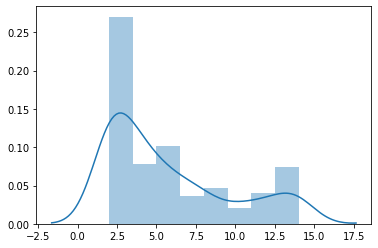

In [12]:
sns.distplot(sflat)

In [8]:
conda list

# packages in environment at /home/rwl0960/.conda/envs/dask_lab:
#
_libgcc_mutex             0.1                        main  
aioeasywebdav             2.4.0                 py37_1000    conda-forge
aiohttp                   3.6.2            py37h516909a_0    conda-forge
appdirs                   1.4.3                      py_1    conda-forge
arrow                     0.15.5                   py37_0    conda-forge
async-timeout             3.0.1                   py_1000    conda-forge
attrs                     19.1.0                   py37_1  
backcall                  0.1.0                    py37_0  
bcrypt                    3.1.7            py37h516909a_0    conda-forge
binaryornot               0.4.4                      py_1    conda-forge
biopython                 1.74             py37h516909a_0    conda-forge
blas                      1.0                         mkl  
bleach                    3.1.0                    py37_0  
bokeh                     2.0.0                  

In [33]:
nb_conda_list = """_libgcc_mutex             0.1                        main  
aioeasywebdav             2.4.0                 py37_1000    conda-forge
aiohttp                   3.6.2            py37h516909a_0    conda-forge
appdirs                   1.4.3                      py_1    conda-forge
arrow                     0.15.5                   py37_0    conda-forge
async-timeout             3.0.1                   py_1000    conda-forge
attrs                     19.1.0                   py37_1  
backcall                  0.1.0                    py37_0  
bcrypt                    3.1.7            py37h516909a_0    conda-forge
binaryornot               0.4.4                      py_1    conda-forge
biopython                 1.74             py37h516909a_0    conda-forge
blas                      1.0                         mkl  
bleach                    3.1.0                    py37_0  
bokeh                     2.0.0                    py37_0  
boto3                     1.11.0                     py_0    conda-forge
botocore                  1.14.0                     py_0    conda-forge
bzip2                     1.0.8                h516909a_2    conda-forge
ca-certificates           2019.8.28                     0  
cachetools                3.1.1                      py_0    conda-forge
cairo                     1.14.12              h8948797_3  
certifi                   2019.9.11                py37_0  
cffi                      1.13.2           py37h8022711_0    conda-forge
chardet                   3.0.4                 py37_1003    conda-forge
click                     7.0                      py37_0  
cloudpickle               1.2.2                      py_0  
configargparse            0.13.0                     py_1    conda-forge
cookiecutter              1.7.0                      py_0    conda-forge
cryptography              2.8              py37h72c5cf5_1    conda-forge
cycler                    0.10.0                   py37_0  
cytoolz                   0.10.0           py37h7b6447c_0  
dask                      2.5.2                      py_0  
dask-core                 2.5.2                      py_0  
datrie                    0.8              py37h516909a_0    conda-forge
dbus                      1.13.6               h746ee38_0  
decorator                 4.4.0                    py37_1  
defusedxml                0.6.0                      py_0  
distributed               2.5.2                      py_0  
docutils                  0.15.2                   py37_0    conda-forge
dropbox                   9.4.0                      py_0    conda-forge
entrypoints               0.3                      py37_0  
expat                     2.2.6                he6710b0_0  
fastdtw                   0.2.0                      py_1    bioconda
fftw                      3.3.8           nompi_h7f3a6c3_1110    conda-forge
filechunkio               1.8                        py_2    conda-forge
fontconfig                2.13.0               h9420a91_0  
freetype                  2.9.1                h8a8886c_1  
fsspec                    0.5.1                      py_0  
ftputil                   3.4                        py_0    conda-forge
future                    0.18.2                   py37_0    conda-forge
gettext                   0.19.8.1          hc5be6a0_1002    conda-forge
ghostscript               9.18                          1    bioconda
giflib                    5.1.9                h516909a_0    conda-forge
gitdb2                    2.0.6                      py_0    conda-forge
gitpython                 3.0.5                      py_0    conda-forge
glib                      2.56.2               hd408876_0  
gmp                       6.1.2                h6c8ec71_1  
google-api-core           1.15.0                   py37_0    conda-forge
google-auth               1.10.0                     py_0    conda-forge
google-cloud-core         1.1.0                      py_0    conda-forge
google-cloud-storage      1.24.1                   py37_0    conda-forge
google-resumable-media    0.5.0                      py_0    conda-forge
googleapis-common-protos  1.6.0                    py37_0    conda-forge
graphite2                 1.3.13            hf484d3e_1000    conda-forge
graphviz                  2.38.0            hcf1ce16_1009    conda-forge
gst-plugins-base          1.14.0               hbbd80ab_1  
gstreamer                 1.14.0               hb453b48_1  
harfbuzz                  1.9.0             he243708_1001    conda-forge
heapdict                  1.0.1                      py_0  
icu                       58.2                 h9c2bf20_1  
idna                      2.8                   py37_1000    conda-forge
imagemagick               7.0.8_11        pl526hc610aec_0    conda-forge
intel-openmp              2019.4                      243  
ipdb                      0.12.3                    <pip>
ipykernel                 5.1.2            py37h39e3cac_0  
ipython                   7.8.0            py37h39e3cac_0  
ipython_genutils          0.2.0                    py37_0  
jbig                      2.1               h14c3975_2001    conda-forge
jedi                      0.15.1                   py37_0  
jinja2                    2.10.1                   py37_0  
jinja2-time               0.2.0                      py_2    conda-forge
jmespath                  0.9.4                      py_0    conda-forge
joblib                    0.14.0                     py_0  
jpeg                      9c                h14c3975_1001    conda-forge
json5                     0.8.5                      py_0  
jsonschema                3.0.2                    py37_0  
jupyter_client            5.3.3                    py37_1  
jupyter_core              4.5.0                      py_0  
jupyterlab                1.1.4              pyhf63ae98_0  
jupyterlab_server         1.0.6                      py_0  
kiwisolver                1.1.0            py37he6710b0_0  
libedit                   3.1.20181209         hc058e9b_0  
libffi                    3.2.1                hd88cf55_4  
libgcc                    7.2.0                h69d50b8_2    conda-forge
libgcc-ng                 9.1.0                hdf63c60_0  
libgfortran-ng            7.3.0                hdf63c60_0  
libpng                    1.6.37               hbc83047_0  
libprotobuf               3.11.2               h8b12597_0    conda-forge
libsodium                 1.0.16               h1bed415_0  
libstdcxx-ng              9.1.0                hdf63c60_0  
libtiff                   4.0.10               h2733197_2  
libtool                   2.4.6             h14c3975_1002    conda-forge
libuuid                   1.0.3                h1bed415_2  
libwebp                   0.5.2                         7    conda-forge
libxcb                    1.13                 h1bed415_1  
libxml2                   2.9.9                hea5a465_1  
locket                    0.2.0                    py37_1  
markupsafe                1.1.1            py37h7b6447c_0  
matplotlib                3.1.1            py37h5429711_0  
mistune                   0.8.4            py37h7b6447c_0  
mkl                       2019.4                      243  
mkl-service               2.3.0            py37he904b0f_0  
mkl_fft                   1.0.14           py37ha843d7b_0  
mkl_random                1.1.0            py37hd6b4f25_0  
msgpack-python            0.6.1            py37hfd86e86_1  
multidict                 4.7.3            py37h516909a_0    conda-forge
nbconvert                 5.6.0                    py37_1  
nbformat                  4.4.0                    py37_0  
ncurses                   6.1                  he6710b0_1  
networkx                  2.4                        py_0    conda-forge
nodejs                    10.13.0              he6710b0_0  
notebook                  6.0.1                    py37_0  
numpy                     1.17.2           py37haad9e8e_0  
numpy-base                1.17.2           py37hde5b4d6_0  
olefile                   0.46                     py37_0  
openjpeg                  2.3.1                h21c5421_1    conda-forge
openssl                   1.1.1d               h7b6447c_2  
packaging                 19.2                       py_0  
pandas                    0.25.1           py37he6710b0_0  
pandoc                    2.2.3.2                       0  
pandocfilters             1.4.2                    py37_1  
pango                     1.40.14              he752989_2    conda-forge
paramiko                  2.7.1                    py37_0    conda-forge
parso                     0.5.1                      py_0  
partd                     1.0.0                      py_0  
patsy                     0.5.1                    py37_0  
pcre                      8.43                 he6710b0_0  
perl                      5.26.2            h516909a_1006    conda-forge
pexpect                   4.7.0                    py37_0  
pickleshare               0.7.5                    py37_0  
pillow                    6.1.0            py37h34e0f95_0  
pip                       19.2.3                   py37_0  
pixman                    0.38.0            h516909a_1003    conda-forge
pkg-config                0.29.2            h516909a_1006    conda-forge
poyo                      0.5.0                      py_0    conda-forge
prettytable               0.7.2                      py_3    conda-forge
prometheus_client         0.7.1                      py_0  
prompt_toolkit            2.0.9                    py37_0  
protobuf                  3.11.2           py37he1b5a44_0    conda-forge
psutil                    5.6.3            py37h7b6447c_0  
ptyprocess                0.6.0                    py37_0  
pyasn1                    0.4.8                      py_0    conda-forge
pyasn1-modules            0.2.7                      py_0    conda-forge
pycparser                 2.19                     py37_1    conda-forge
pygments                  2.4.2                      py_0  
pygraphviz                1.5             py37h516909a_1001    conda-forge
pynacl                    1.3.0           py37h516909a_1001    conda-forge
pyopenssl                 19.1.0                   py37_0    conda-forge
pyparsing                 2.4.2                      py_0  
pypdf2                    1.26.0                     py_2    conda-forge
pyqt                      5.9.2            py37h05f1152_2  
pyrsistent                0.15.4           py37h7b6447c_0  
pysftp                    0.2.9                      py_1    conda-forge
pysocks                   1.7.1                    py37_0    conda-forge
python                    3.7.4                h265db76_1  
python-dateutil           2.8.0                    py37_0  
python-irodsclient        0.7.0                      py_0    conda-forge
pytz                      2019.2                     py_0  
pyyaml                    5.1.2            py37h7b6447c_0  
pyzmq                     18.1.0           py37he6710b0_0  
qt                        5.9.7                h5867ecd_1  
ratelimiter               1.2.0                 py37_1000    conda-forge
readline                  7.0                  h7b6447c_5  
requests                  2.22.0                   py37_1    conda-forge
rsa                       4.0                        py_0    conda-forge
s3transfer                0.3.0                    py37_0    conda-forge
scikit-learn              0.21.3           py37hd81dba3_0  
scipy                     1.5.2            py37h0b6359f_0  
seaborn                   0.9.0                    py37_0  
send2trash                1.5.0                    py37_0  
setuptools                41.2.0                   py37_0  
simanneal                 0.4.2                      py_0    conda-forge
sip                       4.19.8           py37hf484d3e_0  
six                       1.12.0                   py37_0  
smmap2                    2.0.5                      py_0    conda-forge
snakemake                 5.9.1                         0    bioconda
snakemake-minimal         5.9.1                      py_0    bioconda
sortedcontainers          2.1.0                    py37_0  
sqlite                    3.30.0               h7b6447c_0  
statsmodels               0.10.1           py37hdd07704_0  
tblib                     1.4.0                      py_0  
terminado                 0.8.2                    py37_0  
testpath                  0.4.2                    py37_0  
tk                        8.6.8                hbc83047_0  
toolz                     0.10.0                     py_0  
tornado                   6.0.3            py37h7b6447c_0  
traitlets                 4.3.2                    py37_0  
typing_extensions         3.7.4.1                  py37_0  
urllib3                   1.25.7                   py37_0    conda-forge
wcwidth                   0.1.7                    py37_0  
webencodings              0.5.1                    py37_1  
wheel                     0.33.6                   py37_0  
whichcraft                0.6.1                      py_0    conda-forge
wrapt                     1.11.2           py37h516909a_0    conda-forge
xmlrunner                 1.7.7                      py_0    conda-forge
xorg-kbproto              1.0.7             h14c3975_1002    conda-forge
xorg-libice               1.0.10               h516909a_0    conda-forge
xorg-libsm                1.2.2                h470a237_5    conda-forge
xorg-libx11               1.6.9                h516909a_0    conda-forge
xorg-libxext              1.3.4                h516909a_0    conda-forge
xorg-libxpm               3.5.13               h516909a_0    conda-forge
xorg-libxrender           0.9.10            h516909a_1002    conda-forge
xorg-libxt                1.1.5             h516909a_1003    conda-forge
xorg-renderproto          0.11.1            h14c3975_1002    conda-forge
xorg-xextproto            7.3.0             h14c3975_1002    conda-forge
xorg-xproto               7.0.31            h14c3975_1007    conda-forge
xz                        5.2.4                h14c3975_4  
yaml                      0.1.7                had09818_2  
yarl                      1.3.0           py37h516909a_1000    conda-forge
zeromq                    4.3.1                he6710b0_3  
zict                      1.0.0                      py_0  
zlib                      1.2.11               h7b6447c_3  
zstd                      1.3.7                h0b5b093_0  """

term_conda_list = """_libgcc_mutex             0.1                        main  
aioeasywebdav             2.4.0                 py37_1000    conda-forge
aiohttp                   3.6.2            py37h516909a_0    conda-forge
appdirs                   1.4.3                      py_1    conda-forge
arrow                     0.15.5                   py37_0    conda-forge
async-timeout             3.0.1                   py_1000    conda-forge
attrs                     19.1.0                   py37_1  
backcall                  0.1.0                    py37_0  
bcrypt                    3.1.7            py37h516909a_0    conda-forge
binaryornot               0.4.4                      py_1    conda-forge
biopython                 1.74             py37h516909a_0    conda-forge
blas                      1.0                         mkl  
bleach                    3.1.0                    py37_0  
bokeh                     2.0.0                    py37_0  
boto3                     1.11.0                     py_0    conda-forge
botocore                  1.14.0                     py_0    conda-forge
bzip2                     1.0.8                h516909a_2    conda-forge
ca-certificates           2019.8.28                     0  
cachetools                3.1.1                      py_0    conda-forge
cairo                     1.14.12              h8948797_3  
certifi                   2019.9.11                py37_0  
cffi                      1.13.2           py37h8022711_0    conda-forge
chardet                   3.0.4                 py37_1003    conda-forge
click                     7.0                      py37_0  
cloudpickle               1.2.2                      py_0  
configargparse            0.13.0                     py_1    conda-forge
cookiecutter              1.7.0                      py_0    conda-forge
cryptography              2.8              py37h72c5cf5_1    conda-forge
cycler                    0.10.0                   py37_0  
cytoolz                   0.10.0           py37h7b6447c_0  
dask                      2.5.2                      py_0  
dask-core                 2.5.2                      py_0  
datrie                    0.8              py37h516909a_0    conda-forge
dbus                      1.13.6               h746ee38_0  
decorator                 4.4.0                    py37_1  
defusedxml                0.6.0                      py_0  
distributed               2.5.2                      py_0  
docutils                  0.15.2                   py37_0    conda-forge
dropbox                   9.4.0                      py_0    conda-forge
entrypoints               0.3                      py37_0  
expat                     2.2.6                he6710b0_0  
fastdtw                   0.2.0                      py_1    bioconda
fftw                      3.3.8           nompi_h7f3a6c3_1110    conda-forge
filechunkio               1.8                        py_2    conda-forge
fontconfig                2.13.0               h9420a91_0  
freetype                  2.9.1                h8a8886c_1  
fsspec                    0.5.1                      py_0  
ftputil                   3.4                        py_0    conda-forge
future                    0.18.2                   py37_0    conda-forge
gettext                   0.19.8.1          hc5be6a0_1002    conda-forge
ghostscript               9.18                          1    bioconda
giflib                    5.1.9                h516909a_0    conda-forge
gitdb2                    2.0.6                      py_0    conda-forge
gitpython                 3.0.5                      py_0    conda-forge
glib                      2.56.2               hd408876_0  
gmp                       6.1.2                h6c8ec71_1  
google-api-core           1.15.0                   py37_0    conda-forge
google-auth               1.10.0                     py_0    conda-forge
google-cloud-core         1.1.0                      py_0    conda-forge
google-cloud-storage      1.24.1                   py37_0    conda-forge
google-resumable-media    0.5.0                      py_0    conda-forge
googleapis-common-protos  1.6.0                    py37_0    conda-forge
graphite2                 1.3.13            hf484d3e_1000    conda-forge
graphviz                  2.38.0            hcf1ce16_1009    conda-forge
gst-plugins-base          1.14.0               hbbd80ab_1  
gstreamer                 1.14.0               hb453b48_1  
harfbuzz                  1.9.0             he243708_1001    conda-forge
heapdict                  1.0.1                      py_0  
icu                       58.2                 h9c2bf20_1  
idna                      2.8                   py37_1000    conda-forge
imagemagick               7.0.8_11        pl526hc610aec_0    conda-forge
intel-openmp              2019.4                      243  
ipdb                      0.12.3                    <pip>
ipykernel                 5.1.2            py37h39e3cac_0  
ipython                   7.8.0            py37h39e3cac_0  
ipython_genutils          0.2.0                    py37_0  
jbig                      2.1               h14c3975_2001    conda-forge
jedi                      0.15.1                   py37_0  
jinja2                    2.10.1                   py37_0  
jinja2-time               0.2.0                      py_2    conda-forge
jmespath                  0.9.4                      py_0    conda-forge
joblib                    0.14.0                     py_0  
jpeg                      9c                h14c3975_1001    conda-forge
json5                     0.8.5                      py_0  
jsonschema                3.0.2                    py37_0  
jupyter_client            5.3.3                    py37_1  
jupyter_core              4.5.0                      py_0  
jupyterlab                1.1.4              pyhf63ae98_0  
jupyterlab_server         1.0.6                      py_0  
kiwisolver                1.1.0            py37he6710b0_0  
libedit                   3.1.20181209         hc058e9b_0  
libffi                    3.2.1                hd88cf55_4  
libgcc                    7.2.0                h69d50b8_2    conda-forge
libgcc-ng                 9.1.0                hdf63c60_0  
libgfortran-ng            7.3.0                hdf63c60_0  
libpng                    1.6.37               hbc83047_0  
libprotobuf               3.11.2               h8b12597_0    conda-forge
libsodium                 1.0.16               h1bed415_0  
libstdcxx-ng              9.1.0                hdf63c60_0  
libtiff                   4.0.10               h2733197_2  
libtool                   2.4.6             h14c3975_1002    conda-forge
libuuid                   1.0.3                h1bed415_2  
libwebp                   0.5.2                         7    conda-forge
libxcb                    1.13                 h1bed415_1  
libxml2                   2.9.9                hea5a465_1  
locket                    0.2.0                    py37_1  
markupsafe                1.1.1            py37h7b6447c_0  
matplotlib                3.1.1            py37h5429711_0  
mistune                   0.8.4            py37h7b6447c_0  
mkl                       2019.4                      243  
mkl-service               2.3.0            py37he904b0f_0  
mkl_fft                   1.0.14           py37ha843d7b_0  
mkl_random                1.1.0            py37hd6b4f25_0  
msgpack-python            0.6.1            py37hfd86e86_1  
multidict                 4.7.3            py37h516909a_0    conda-forge
nbconvert                 5.6.0                    py37_1  
nbformat                  4.4.0                    py37_0  
ncurses                   6.1                  he6710b0_1  
networkx                  2.4                        py_0    conda-forge
nodejs                    10.13.0              he6710b0_0  
notebook                  6.0.1                    py37_0  
numpy                     1.17.2           py37haad9e8e_0  
numpy-base                1.17.2           py37hde5b4d6_0  
olefile                   0.46                     py37_0  
openjpeg                  2.3.1                h21c5421_1    conda-forge
openssl                   1.1.1d               h7b6447c_2  
packaging                 19.2                       py_0  
pandas                    0.25.1           py37he6710b0_0  
pandoc                    2.2.3.2                       0  
pandocfilters             1.4.2                    py37_1  
pango                     1.40.14              he752989_2    conda-forge
paramiko                  2.7.1                    py37_0    conda-forge
parso                     0.5.1                      py_0  
partd                     1.0.0                      py_0  
patsy                     0.5.1                    py37_0  
pcre                      8.43                 he6710b0_0  
perl                      5.26.2            h516909a_1006    conda-forge
pexpect                   4.7.0                    py37_0  
pickleshare               0.7.5                    py37_0  
pillow                    6.1.0            py37h34e0f95_0  
pip                       19.2.3                   py37_0  
pixman                    0.38.0            h516909a_1003    conda-forge
pkg-config                0.29.2            h516909a_1006    conda-forge
poyo                      0.5.0                      py_0    conda-forge
prettytable               0.7.2                      py_3    conda-forge
prometheus_client         0.7.1                      py_0  
prompt_toolkit            2.0.9                    py37_0  
protobuf                  3.11.2           py37he1b5a44_0    conda-forge
psutil                    5.6.3            py37h7b6447c_0  
ptyprocess                0.6.0                    py37_0  
pyasn1                    0.4.8                      py_0    conda-forge
pyasn1-modules            0.2.7                      py_0    conda-forge
pycparser                 2.19                     py37_1    conda-forge
pygments                  2.4.2                      py_0  
pygraphviz                1.5             py37h516909a_1001    conda-forge
pynacl                    1.3.0           py37h516909a_1001    conda-forge
pyopenssl                 19.1.0                   py37_0    conda-forge
pyparsing                 2.4.2                      py_0  
pypdf2                    1.26.0                     py_2    conda-forge
pyqt                      5.9.2            py37h05f1152_2  
pyrsistent                0.15.4           py37h7b6447c_0  
pysftp                    0.2.9                      py_1    conda-forge
pysocks                   1.7.1                    py37_0    conda-forge
python                    3.7.4                h265db76_1  
python-dateutil           2.8.0                    py37_0  
python-irodsclient        0.7.0                      py_0    conda-forge
pytz                      2019.2                     py_0  
pyyaml                    5.1.2            py37h7b6447c_0  
pyzmq                     18.1.0           py37he6710b0_0  
qt                        5.9.7                h5867ecd_1  
ratelimiter               1.2.0                 py37_1000    conda-forge
readline                  7.0                  h7b6447c_5  
requests                  2.22.0                   py37_1    conda-forge
rsa                       4.0                        py_0    conda-forge
s3transfer                0.3.0                    py37_0    conda-forge
scikit-learn              0.21.3           py37hd81dba3_0  
scipy                     1.5.2            py37h0b6359f_0  
seaborn                   0.9.0                    py37_0  
send2trash                1.5.0                    py37_0  
setuptools                41.2.0                   py37_0  
simanneal                 0.4.2                      py_0    conda-forge
sip                       4.19.8           py37hf484d3e_0  
six                       1.12.0                   py37_0  
smmap2                    2.0.5                      py_0    conda-forge
snakemake                 5.9.1                         0    bioconda
snakemake-minimal         5.9.1                      py_0    bioconda
sortedcontainers          2.1.0                    py37_0  
sqlite                    3.30.0               h7b6447c_0  
statsmodels               0.10.1           py37hdd07704_0  
tblib                     1.4.0                      py_0  
terminado                 0.8.2                    py37_0  
testpath                  0.4.2                    py37_0  
tk                        8.6.8                hbc83047_0  
toolz                     0.10.0                     py_0  
tornado                   6.0.3            py37h7b6447c_0  
traitlets                 4.3.2                    py37_0  
typing_extensions         3.7.4.1                  py37_0  
urllib3                   1.25.7                   py37_0    conda-forge
wcwidth                   0.1.7                    py37_0  
webencodings              0.5.1                    py37_1  
wheel                     0.33.6                   py37_0  
whichcraft                0.6.1                      py_0    conda-forge
wrapt                     1.11.2           py37h516909a_0    conda-forge
xmlrunner                 1.7.7                      py_0    conda-forge
xorg-kbproto              1.0.7             h14c3975_1002    conda-forge
xorg-libice               1.0.10               h516909a_0    conda-forge
xorg-libsm                1.2.2                h470a237_5    conda-forge
xorg-libx11               1.6.9                h516909a_0    conda-forge
xorg-libxext              1.3.4                h516909a_0    conda-forge
xorg-libxpm               3.5.13               h516909a_0    conda-forge
xorg-libxrender           0.9.10            h516909a_1002    conda-forge
xorg-libxt                1.1.5             h516909a_1003    conda-forge
xorg-renderproto          0.11.1            h14c3975_1002    conda-forge
xorg-xextproto            7.3.0             h14c3975_1002    conda-forge
xorg-xproto               7.0.31            h14c3975_1007    conda-forge
xz                        5.2.4                h14c3975_4  
yaml                      0.1.7                had09818_2  
yarl                      1.3.0           py37h516909a_1000    conda-forge
zeromq                    4.3.1                he6710b0_3  
zict                      1.0.0                      py_0  
zlib                      1.2.11               h7b6447c_3  
zstd                      1.3.7                h0b5b093_0  """

In [34]:
nb_lib_vers = [[j for j in i.split(' ') if j is not ''][:2] for i in nb_conda_list.split("\n")]
nb_libs = [i[0] for i in nb_lib_vers]

term_lib_vers = [[j for j in i.split(' ') if j is not ''][:2] for i in term_conda_list.split("\n")]
term_libs = [i[0] for i in term_lib_vers]

In [36]:
version_dict = ddict()
for i in nb_lib_vers:
    version_dict[i[0]] = i[1]

In [38]:
keys = version_dict.keys()
for i in term_lib_vers:
    if i[0] in keys:
        if version_dict[i[0]] == i[1]:
            pass
        else:
            print('version_mismatch: '+i[0])
    else:
        print('module mismatch: '+i[0])

In [2]:
1800/25*8/60

9.6

In [3]:
lines = [line]

In [7]:
#Generate rt-group ics
for i in range(len(library_info))[:1]:
    paths = glob.glob("resources/tensors/"+str(line)+"_*")    
    tp_inputs = [[fn for fn in paths if tp_name in fn] for tp_name in tp_names]
    name = library_info.iloc[line]['name']

    t = hx.TensorGenerator(name, library_info, tp_inputs, timepoints)
    t.generate_tensors()
    
    fatc = []
    for tp in t.all_tp_clusters:
        fatc.append([ic for ic in tp if ic.baseline_peak_error/ic.baseline_auc < 0.25])
        
    hx.limit_write(fatc, "resources/ic_time_series/"+t.name+"_all_tp_clusters.cpickle.zlib")

NameError: name 'line' is not defined

In [25]:
for tp in t.all_tp_clusters:
    print(len(tp))

NameError: name 't' is not defined

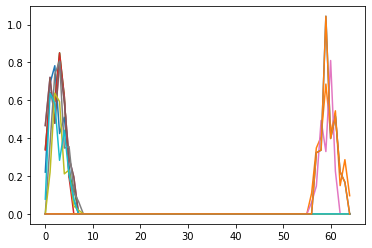

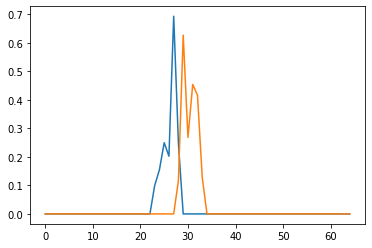

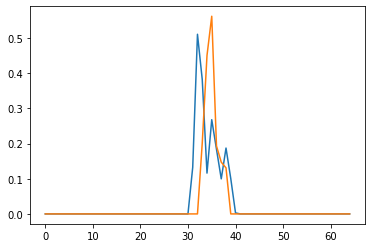

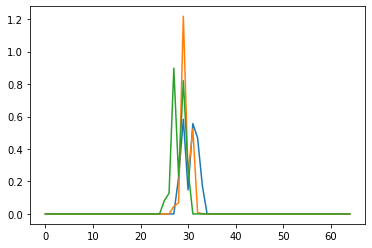

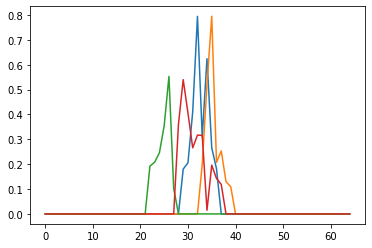

<Figure size 432x288 with 0 Axes>

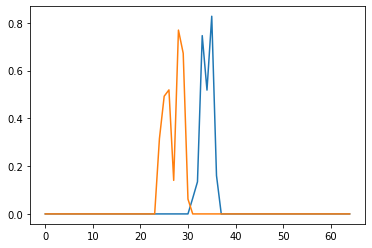

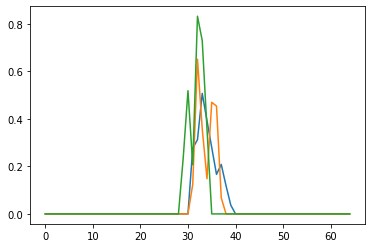

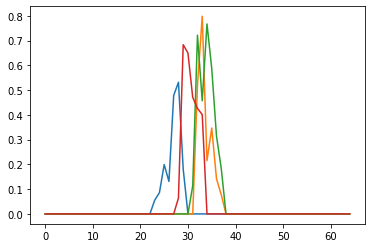

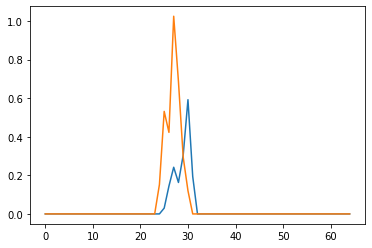

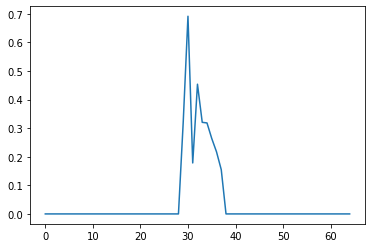

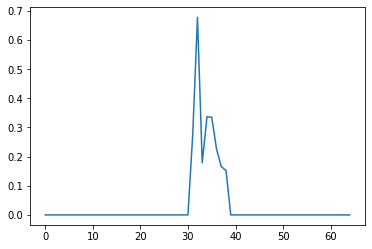

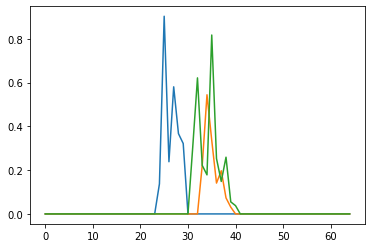

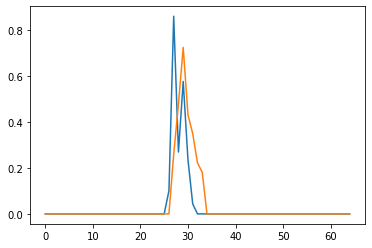

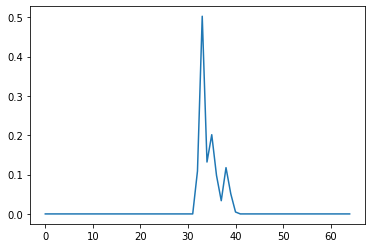

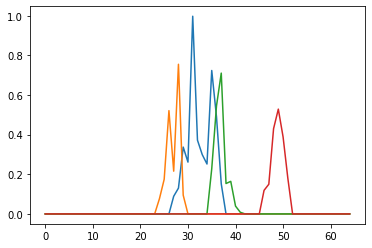

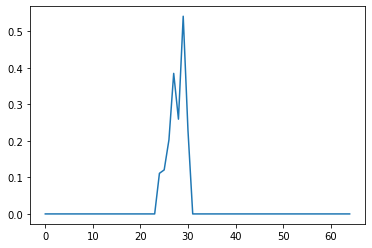

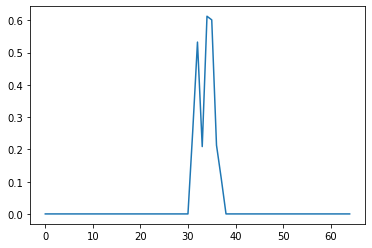

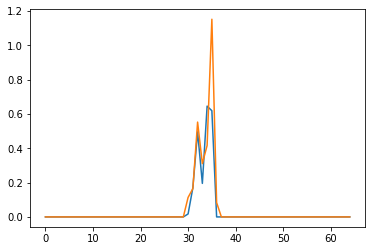

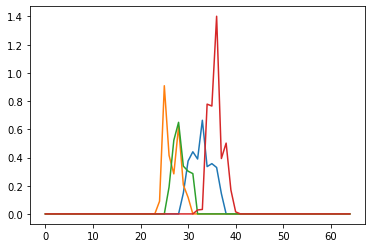

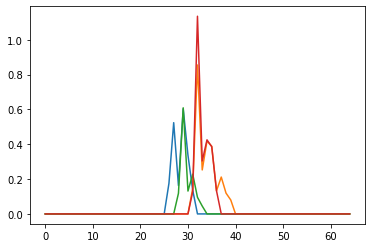

In [5]:
for tp in t.all_tp_clusters:
    plt.figure()
    for ic in tp:
        plt.plot(ic.baseline_integrated_mz)
    plt.show()
    plt.close()

In [ ]:
#PO and bokeh plot
for line in subset_indices[:2]:
    
    name = library_info.iloc[line]['name']
    
    all_tp_clusters = hx.limit_read("data/ic_time_series/"+library_info.iloc[line]['name']+"_all_tp_clusters.cpickle.zlib")
    
    po = hx.PathOptimizer(name, all_tp_clusters, library_info, timepoints, n_undeut_runs = 3, old_data_dir = "/Users/rwl0960/Documents/hdx/local_LIMIT/data/old_data/")

    po.optimize_paths()

    source_frame, old_df = po.bokeh_plot("plots/"+name+"_time_series.html")